# **XGBoost**

## **전처리**

In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 1.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#method : scaling, log transformation, cube Root normalization, Box-Cox transformation
from scipy.stats import skew 
from scipy.stats import boxcox

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/content/drive/MyDrive/heart_2020_cleaned.csv')
df.shape

(319795, 18)

In [5]:
df = df.drop_duplicates()
df.shape

(301717, 18)

In [6]:
# noise 처리
df = df[(df['BMI'] < 80) & (df['SleepTime'] != 24)]
df.shape

(301653, 18)

In [7]:
def yesno_tolabel(x):
    if (x == 'Yes') | (x == 'Yes (during pregnancy)') :
        return 1
    else:
        return 0

In [8]:
sex_map = {'Female' : 0, 'Male' : 1}
health_map = {'Excellent' : 4, 'Very good' : 3, 'Good' : 2, 'Fair' : 1, 'Poor' : 0}
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
age_map = {'18-24' : 20, '25-29' : 25, '30-34' : 30, '35-39' : 35, '40-44' : 40, '45-49' : 45, '50-54' : 50, '55-59' : 55, '60-64' : 60, '65-69' : 65, '70-74' : 70, '75-79' : 75, '80 or older' : 80}
columns = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
for column in columns:
    df[column] = df[column].apply(lambda x : yesno_tolabel(x))

df['Sex'] = df['Sex'].map(sex_map)
df['GenHealth'] = df['GenHealth'].map(health_map)
df['Diabetic'] = df['Diabetic'].map(diabetic_map)
df['AgeCategory'] = df['AgeCategory'].map(age_map)

In [ ]:
df

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0                  0  16.60        1                0       0             3.0   
1                  0  20.34        0                0       1             0.0   
2                  0  26.58        1                0       0            20.0   
3                  0  24.21        0                0       0             0.0   
4                  0  23.71        0                0       0            28.0   
...              ...    ...      ...              ...     ...             ...   
319790             1  27.41        1                0       0             7.0   
319791             0  29.84        1                0       0             0.0   
319792             0  24.24        0                0       0             0.0   
319793             0  32.81        0                0       0             0.0   
319794             0  46.56        0                0       0             0.0   

        MentalHealth  DiffWalking  Sex  AgeCategory      Race  Diabetic  \
0               30.0            0    0           55     White         2   
1                0.0            0    0           80     White         0   
2               30.0            0    1           65     White         2   
3                0.0            0    0           75     White         0   
4                0.0            1    0           40     White         0   
...              ...          ...  ...          ...       ...       ...   
319790           0.0            1    1           60  Hispanic         2   
319791           0.0            0    1           35  Hispanic         0   
319792           0.0            0    0           45  Hispanic         0   
319793           0.0            0    0           25  Hispanic         0   
319794           0.0            0    0           80  Hispanic         0   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
0                      1          3        5.0       1              0   
1                      1          3        7.0       0              0   
2                      1          1        8.0       1              0   
3                      0          2        6.0       0              0   
4                      1          3        8.0       0              0   
...                  ...        ...        ...     ...            ...   
319790                 0          1        6.0       1              0   
319791                 1          3        5.0       1              0   
319792                 1          2        6.0       0              0   
319793                 0          2       12.0       0              0   
319794                 1          2        8.0       0              0   

        SkinCancer  
0                1  
1                0  
2                0  
3                1  
4                0  
...            ...  
319790           0  
319791           0  
319792           0  
319793           0  
319794           0  

[301653 rows x 18 columns]

In [9]:
def quantile_operation(outlier_df, column):
    quantile_1 = outlier_df[column].quantile(0.25)
    quantile_3 = outlier_df[column].quantile(0.75)
    iqr = quantile_3 - quantile_1
    Lower_tail = quantile_1 - 1.5 * iqr
    Upper_tail = quantile_3 + 1.5 * iqr

    return Lower_tail, Upper_tail

In [10]:

df['PhysicalHealth'] = df['PhysicalHealth'] + 1
df['MentalHealth'] = df['MentalHealth'] + 1
outlier_columns = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
for column in outlier_columns:
    Lower_tail, Upper_tail = quantile_operation(df, column)
    df[column] = boxcox(df[column])[0]

In [11]:
#Race 인코딩 - Binary
import category_encoders as ce
import pandas as pd

ce_binary = ce.BinaryEncoder(cols = ['Race'], return_df = True)
ce_binary_encoded = ce_binary.fit_transform(df['Race'])

df = pd.concat([df, ce_binary_encoded], axis = 1).drop(['Race'], axis = 1)

In [ ]:
df

HeartDisease       BMI  Smoking  AlcoholDrinking  Stroke  \
0                  0  1.403407        1                0       0   
1                  0  1.442302        0                0       1   
2                  0  1.487128        1                0       0   
3                  0  1.472250        0                0       0   
4                  0  1.468816        0                0       0   
...              ...       ...      ...              ...     ...   
319790             1  1.491857        1                0       0   
319791             0  1.504497        1                0       0   
319792             0  1.472452        0                0       0   
319793             0  1.517915        0                0       0   
319794             0  1.561599        0                0       0   

        PhysicalHealth  MentalHealth  DiffWalking  Sex  AgeCategory  Diabetic  \
0             0.669364      1.089487            0    0           55         2   
1             0.000000      0.000000            0    0           80         0   
2             0.801003      1.089487            0    1           65         2   
3             0.000000      0.000000            0    0           75         0   
4             0.807551      0.000000            1    0           40         0   
...                ...           ...          ...  ...          ...       ...   
319790        0.755892      0.000000            1    1           60         2   
319791        0.000000      0.000000            0    1           35         0   
319792        0.000000      0.000000            0    0           45         0   
319793        0.000000      0.000000            0    0           25         0   
319794        0.000000      0.000000            0    0           80         0   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
0                      1          3   3.488639       1              0   
1                      1          3   5.054525       0              0   
2                      1          1   5.813435       1              0   
3                      0          2   4.280563       0              0   
4                      1          3   5.813435       0              0   
...                  ...        ...        ...     ...            ...   
319790                 0          1   4.280563       1              0   
319791                 1          3   3.488639       1              0   
319792                 1          2   4.280563       0              0   
319793                 0          2   8.734516       0              0   
319794                 1          2   5.813435       0              0   

        SkinCancer  Race_0  Race_1  Race_2  
0                1       0       0       1  
1                0       0       0       1  
2                0       0       0       1  
3                1       0       0       1  
4                0       0       0       1  
...            ...     ...     ...     ...  
319790           0       1       1       0  
319791           0       1       1       0  
319792           0       1       1       0  
319793           0       1       1       0  
319794           0       1       1       0  

[301653 rows x 20 columns]

In [12]:
# x y분리
x=df.drop('HeartDisease', axis=1)
x_columns=x.columns
y=df['HeartDisease']

In [13]:
# train test 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.2,random_state = 42)

In [ ]:
# 데이터 불균형 처리 전 상태

print('origin target data :\n', df['HeartDisease'].value_counts())

origin target data :
 0    274401
1     27252
Name: HeartDisease, dtype: int64


In [14]:
##오버샘플링 처리
from imblearn.over_sampling import *

#SMOTE
x_train_SMOTE, y_train_SMOTE =SMOTE(random_state=42).fit_resample(x_train, y_train) # 거의 10초

#BorderlineSMOTE
x_train_BorderlineSM, y_train_BorderlineSM =BorderlineSMOTE(random_state=42).fit_resample(x_train, y_train) #거의 1분30초

#SVMSMOTE
x_train_SVMSMOTE, y_train_SVMSMOTE =SVMSMOTE(random_state=42).fit_resample(x_train, y_train) #14분 11초

#ADASYN
x_train_ADASYN, y_train_ADASYN =ADASYN(random_state=42).fit_resample(x_train, y_train) #거의 2분걸림'''

In [15]:
# 복합 샘플링 진행 
from imblearn.combine import *

## SMOTETomek <- 얘는 사용 안하기로 해서 주석처리 하겠습니다.
#x_train_SMOTETomek, y_train_SMOTETomek =SMOTETomek(random_state=42).fit_resample(x_train, y_train)  #33분 16초

#SMOTETENN
x_train_SMOTEENN, y_train_SMOTEENN =SMOTEENN(random_state=42).fit_resample(x_train, y_train) #56분 19초

# **ROC**

Accuracy 0.910725829175714
Precision 0.5672043010752689
Recall 0.07692307692307693
F1 0.13547351524879617
AUC 0.8402111232706417
[[54523   322]
 [ 5064   422]]


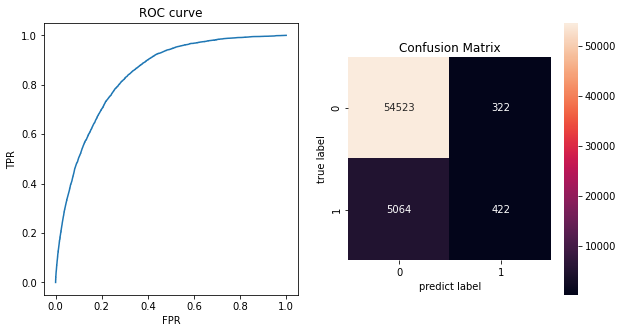

In [16]:
import xgboost as xgb
from sklearn import metrics

#불균형 적용x
model = xgb.XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7829308315791218
Precision 0.24524638457418318
Recall 0.6676995989792198
F1 0.3587307805308001
AUC 0.8174271910760871
[[43572 11273]
 [ 1823  3663]]


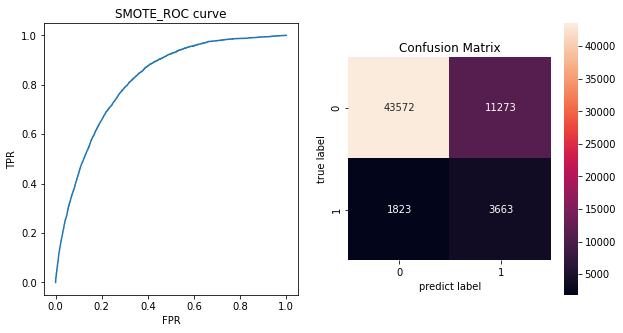

In [17]:
#SMOTE
model = xgb.XGBClassifier()
model.fit(x_train_SMOTE, y_train_SMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7801296182725299
Precision 0.245468228519076
Recall 0.6837404301859278
F1 0.36124620792603646
AUC 0.8228850523533211
[[43315 11530]
 [ 1735  3751]]


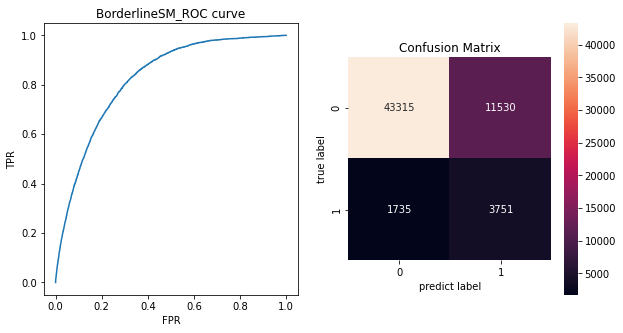

In [18]:
#BorderlineSMote
model = xgb.XGBClassifier()
model.fit(x_train_BorderlineSM, y_train_BorderlineSM)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('BorderlineSM_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.8145563640582785
Precision 0.27355043685464653
Recall 0.6277798031352534
F1 0.38105775614073906
AUC 0.8316779179530475
[[45699  9146]
 [ 2042  3444]]


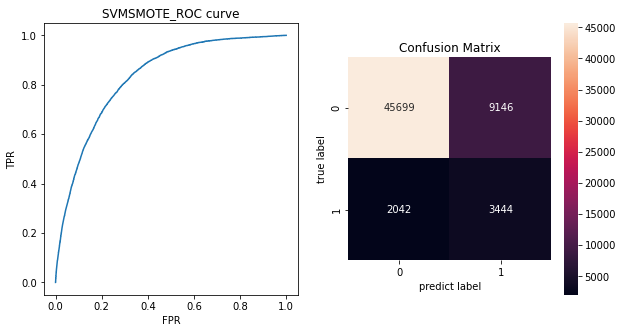

In [19]:
#SVMSMote
model = xgb.XGBClassifier()
model.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SVMSMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7704496858994547
Precision 0.2344236265481105
Recall 0.6728034998177178
F1 0.3476991192124723
AUC 0.8115573345317748
[[42791 12054]
 [ 1795  3691]]


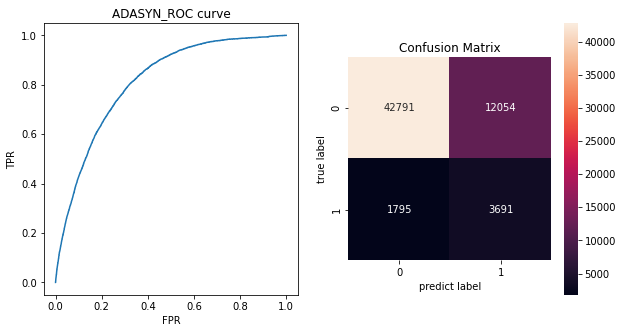

In [20]:
#ADASYN
model = xgb.XGBClassifier()
model.fit(x_train_ADASYN, y_train_ADASYN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ADASYN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7529628217665877
Precision 0.23356342650220663
Recall 0.7524608093328472
F1 0.35647668393782384
AUC 0.8301272847713506
[[41299 13546]
 [ 1358  4128]]


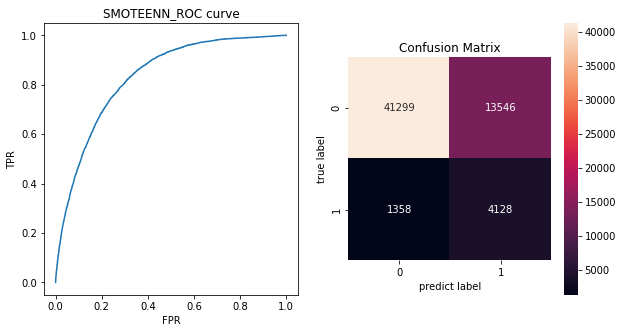

In [21]:
#SMOTEENN
model = xgb.XGBClassifier()
model.fit(x_train_SMOTEENN, y_train_SMOTEENN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTEENN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7334869304337737
Precision 0.2260383799720685
Recall 0.7965730951512942
F1 0.3521495628349249
AUC 0.8404815021234238
[[39882 14963]
 [ 1116  4370]]


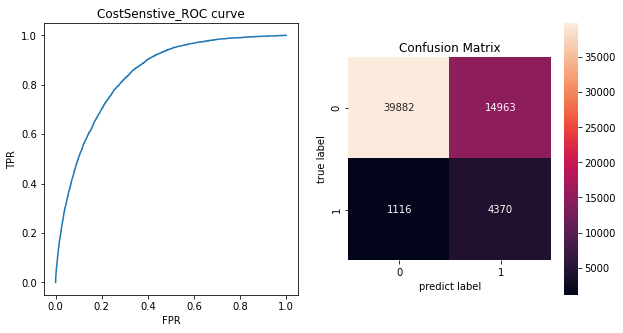

In [22]:
import xgboost as xgb
from sklearn import metrics

#Costsensitive
model = xgb.XGBClassifier(scale_pos_weight=10) #no와 yes의 개수가 거의 10배
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('CostSenstive_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

## **하이퍼파라미터 튜닝**

In [ ]:
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

#불균형 처리 x
model = xgb.XGBClassifier(n_estimators=100)

# 후보 파라미터 선정
params = {'max_depth':[4,5,6,7], 'min_child_weight':[2,3,5], 'colsample_bytree':[0.5,0.7]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(x_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train, y_train), (x_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[24]	validation_0-auc:0.839633	validation_1-auc:0.838003
[25]	validation_0-auc:0.8395	validation_1-auc:0.837771
[26]	validation_0-auc:0.840059	validation_1-auc:0.838184
[27]	validation_0-auc:0.840074	validation_1-auc:0.838269
[28]	validation_0-auc:0.840428	validation_1-auc:0.838611
[29]	validation_0-auc:0.840505	validation_1-auc:0.838758
[30]	validation_0-auc:0.840892	validation_1-auc:0.83911
[31]	validation_0-auc:0.84107	validation_1-auc:0.839038
[32]	validation_0-auc:0.841045	validation_1-auc:0.838884
[33]	validation_0-auc:0.84127	validation_1-auc:0.839087
[34]	validation_0-auc:0.841247	validation_1-auc:0.838976
[35]	validation_0-auc:0.841455	validation_1-auc:0.839169
[36]	validation_0-auc:0.841769	validation_1-auc:0.8393
[37]	validation_0-auc:0.842034	validation_1-auc:0.839429
[38]	validation_0-auc:0.842075	validation_1-auc:0.839365
[39]	validation_0-auc:0.842279	validation_1-auc:0.839444
[40]	validation_0-auc:0.842472	validation_1-auc:0.839531
[4

Accuracy 0.9109081566690425
Precision 0.5716129032258065
Recall 0.08075100255195042
F1 0.14151094074429005
AUC 0.8409087377023513
[[54513   332]
 [ 5043   443]]


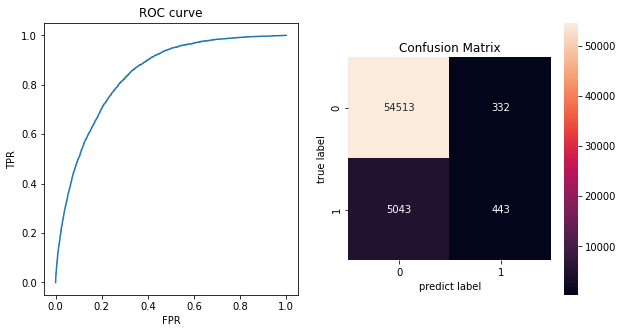

In [ ]:
#파라미터 튜닝
#불균형 적용x
model = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=4, 
                          min_child_weight=5,
                          colsample_bytree=0.7)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

In [ ]:
##SMOTE
model = xgb.XGBClassifier(n_estimators=100)

# 후보 파라미터 선정
params = {'max_depth':[4,5,6,7], 'min_child_weight':[2,3,5], 'colsample_bytree':[0.5,0.7]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(x_train_SMOTE, y_train_SMOTE, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train_SMOTE, y_train_SMOTE), (x_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

[0]	validation_0-auc:0.801032	validation_1-auc:0.75853
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.801136	validation_1-auc:0.758599
[2]	validation_0-auc:0.816794	validation_1-auc:0.77912
[3]	validation_0-auc:0.823086	validation_1-auc:0.788822
[4]	validation_0-auc:0.823084	validation_1-auc:0.786879
[5]	validation_0-auc:0.832915	validation_1-auc:0.789851
[6]	validation_0-auc:0.848436	validation_1-auc:0.803874
[7]	validation_0-auc:0.847916	validation_1-auc:0.804335
[8]	validation_0-auc:0.845473	validation_1-auc:0.804103
[9]	validation_0-auc:0.851776	validation_1-auc:0.803718
[10]	validation_0-auc:0.851729	validation_1-auc:0.804676
[11]	validation_0-auc:0.857564	validation_1-auc:0.810272
[12]	validation_0-auc:0.862542	validation_1-auc:0.813718
[13]	validation_0-auc:0.866223	validation_1-auc:0.815409
[14]	validation_0-auc:0.86655	validation_1-auc:0.816014
[

Accuracy 0.8372312741376738
Precision 0.2726128016789087
Recall 0.47356908494349254
F1 0.34603090037293555
AUC 0.8041155023867181
[[47913  6932]
 [ 2888  2598]]


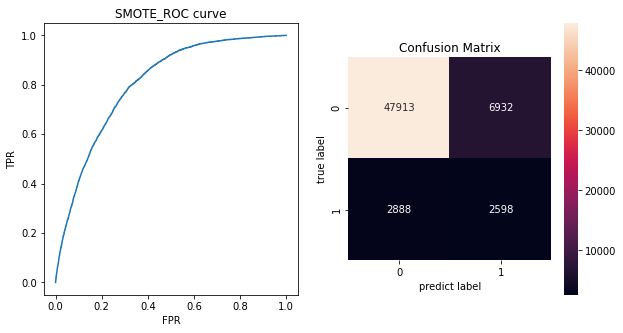

In [23]:
#SMOTE
model = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=7, 
                          min_child_weight=2,
                          colsample_bytree=0.5)
model.fit(x_train_SMOTE, y_train_SMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

In [ ]:
##BorderlineSMote
model = xgb.XGBClassifier(n_estimators=100)

# 후보 파라미터 선정
params = {'max_depth':[4,5,6,7], 'min_child_weight':[2,3,5], 'colsample_bytree':[0.5,0.7]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(x_train_BorderlineSM, y_train_BorderlineSM, early_stopping_rounds=30, eval_metric='auc', eval_set=[(x_train_BorderlineSM, y_train_BorderlineSM), (x_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

Accuracy 0.7801296182725299
Precision 0.245468228519076
Recall 0.6837404301859278
F1 0.36124620792603646
AUC 0.8228850523533211
[[43315 11530]
 [ 1735  3751]]


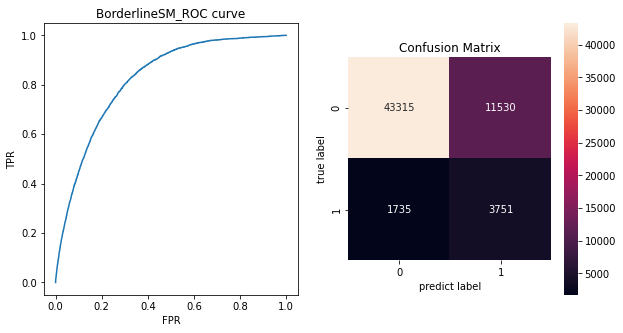

In [ ]:
#BorderlineSMote
model = xgb.XGBClassifier()
model.fit(x_train_BorderlineSM, y_train_BorderlineSM)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('BorderlineSM_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.8145563640582785
Precision 0.27355043685464653
Recall 0.6277798031352534
F1 0.38105775614073906
AUC 0.8316779179530475
[[45699  9146]
 [ 2042  3444]]


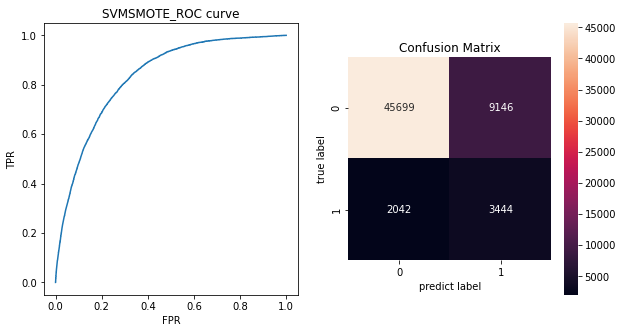

In [ ]:
#SVMSMote
model = xgb.XGBClassifier()
model.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SVMSMOTE_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.8092688667517528
Precision 0.2489785708329859
Recall 0.5442945679912504
F1 0.34166714342925797
AUC 0.801684103482299
[[45838  9007]
 [ 2500  2986]]


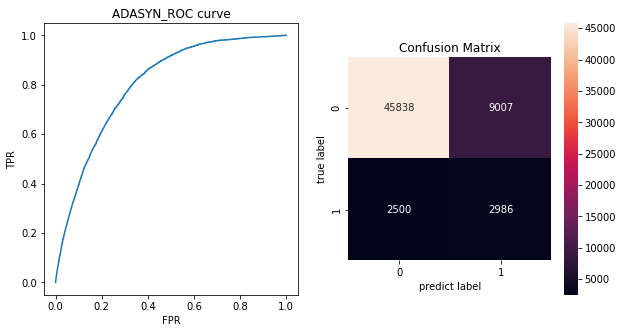

In [ ]:
#ADASYN
model = xgb.XGBClassifier(objective='binary:logistic', max_depth=5)
model.fit(x_train_ADASYN, y_train_ADASYN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ADASYN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.807213538645141
Precision 0.2656190403539553
Recall 0.6347065257017863
F1 0.3745092766872815
AUC 0.8256762412694749
[[45218  9627]
 [ 2004  3482]]


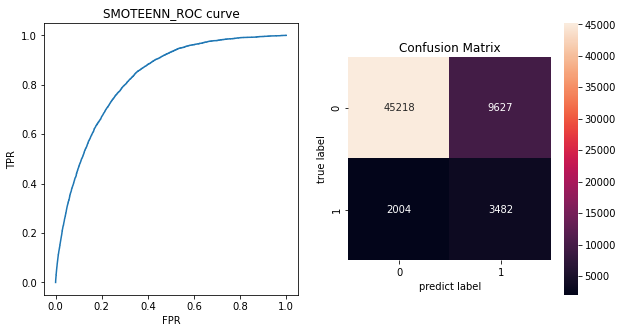

In [ ]:
#SMOTEENN
model = xgb.XGBClassifier(max_depth=5)
model.fit(x_train_SMOTEENN, y_train_SMOTEENN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('SMOTEENN_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

Accuracy 0.7425370041935323
Precision 0.22970137207425342
Recall 0.7781625956981407
F1 0.35470067716339165
AUC 0.8373216143184417
[[40529 14316]
 [ 1217  4269]]


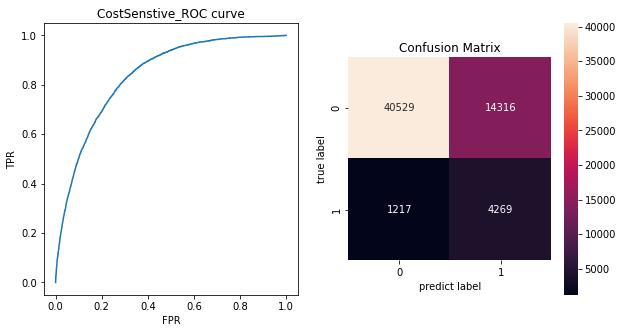

In [ ]:
#Costsensitive
model = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=7,
                          scale_pos_weight=10) #no와 yes의 개수가 거의 10배
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)


print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('CostSenstive_ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()


# **PDP**

In [24]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 167 kB/s 
     |████████████████████████████████| 13.1 MB 23.0 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=d9fa5c9e95667e1f3ab315000cae3fc5bd44a87a7043b72c2c8c646b8ae6378b
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [25]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 4.8 MB/s 


In [29]:
from pdpbox import pdp
import shap

#분포를 보기위해 yes no와 그 외로 피쳐 분리
feature = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',  'PhysicalActivity',   'Asthma', 'KidneyDisease',
       'SkinCancer', 'Diabetic', 'Race_0', 'Race_1', 'Race_2']
feature2=['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory',  'GenHealth', 'SleepTime']
features = x_test.columns

print(x_test.columns)

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'Diabetic',
       'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Race_0', 'Race_1', 'Race_2'],
      dtype='object')


## 불균형처리x

In [30]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier()

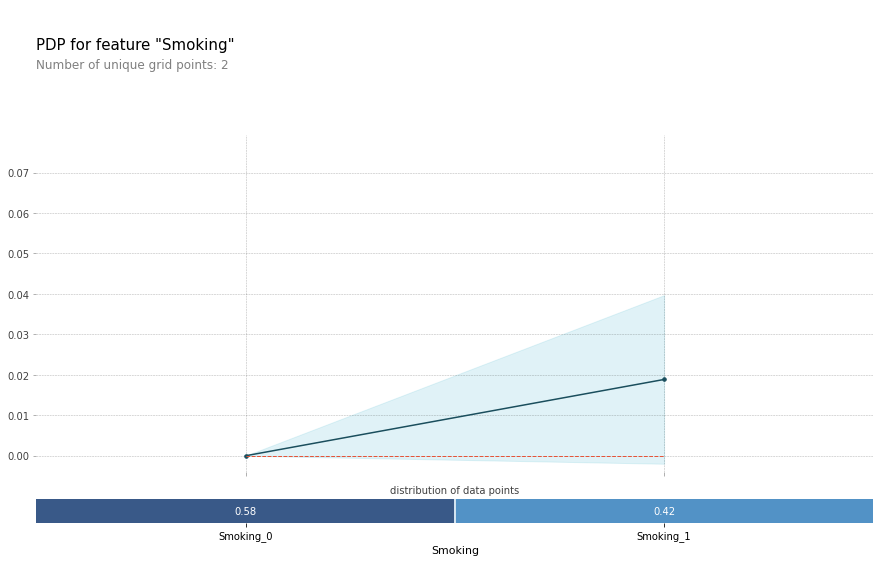

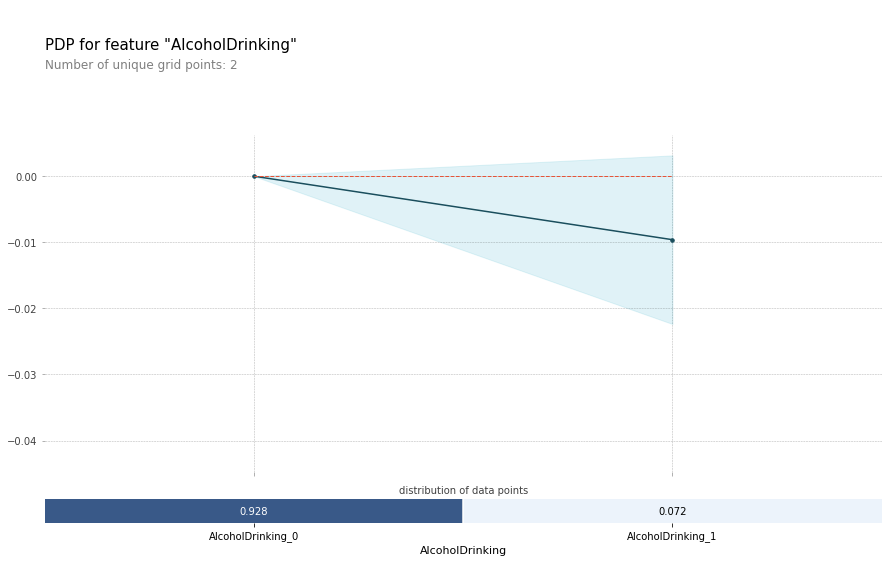

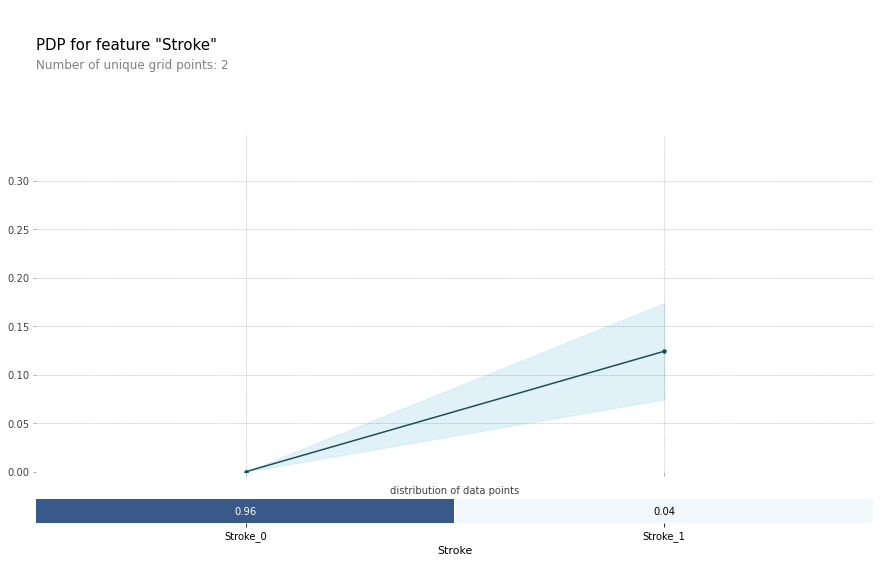

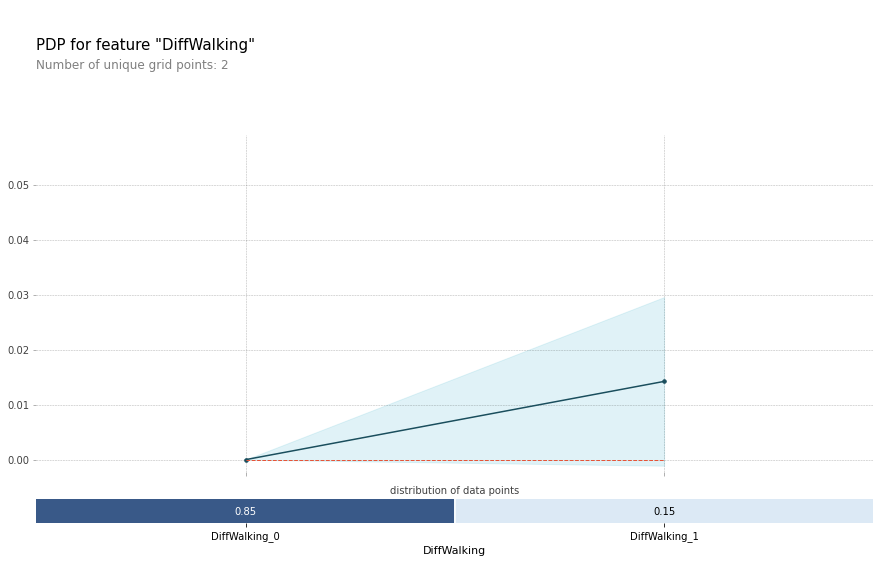

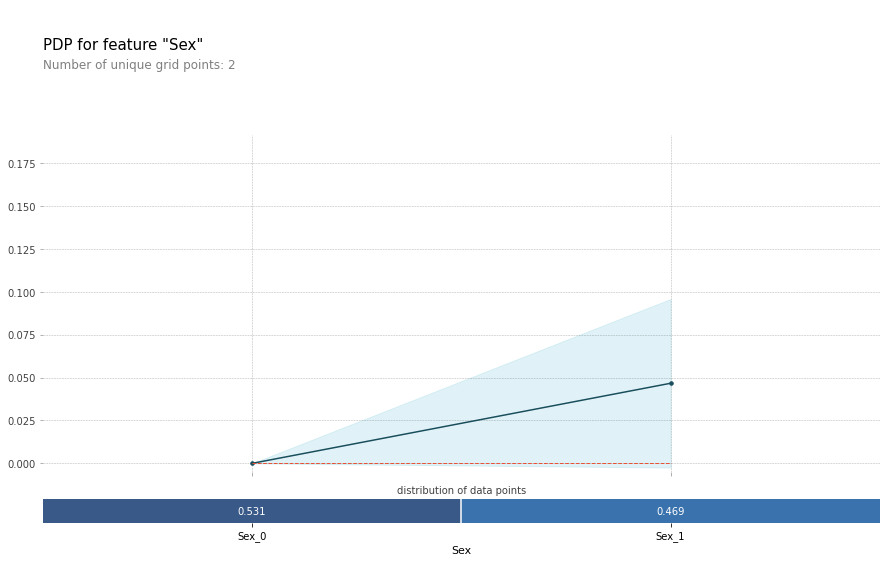

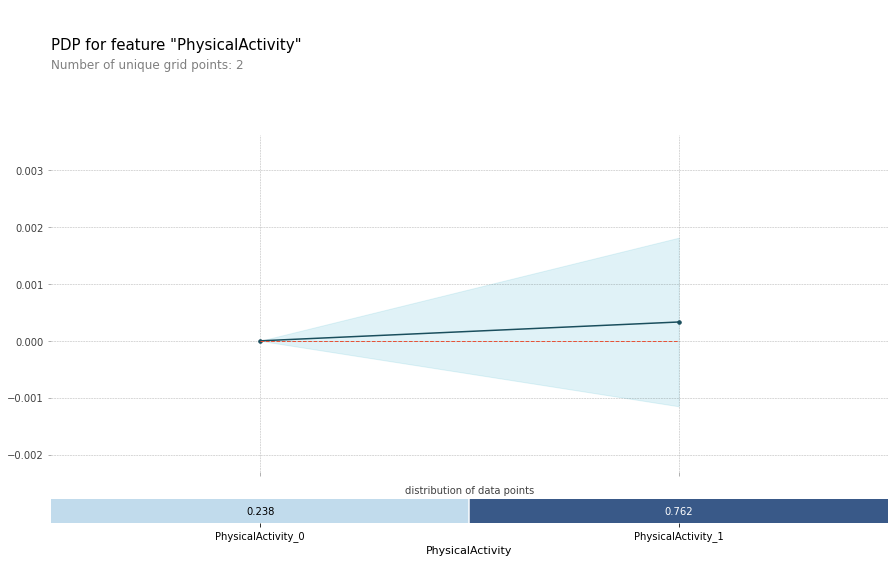

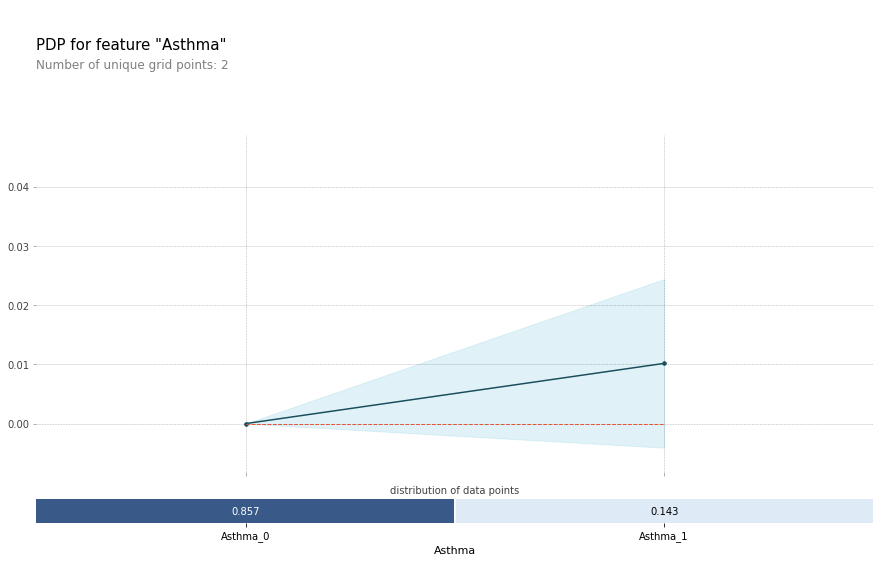

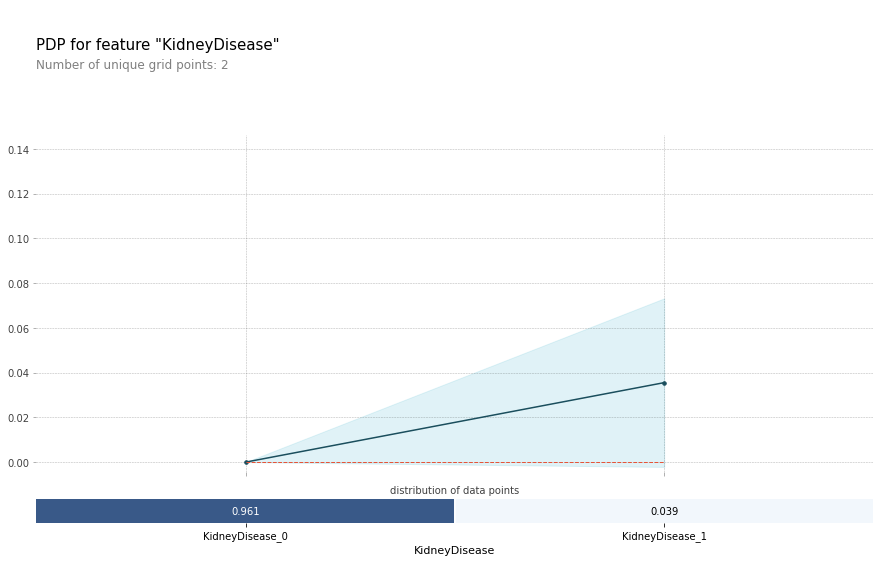

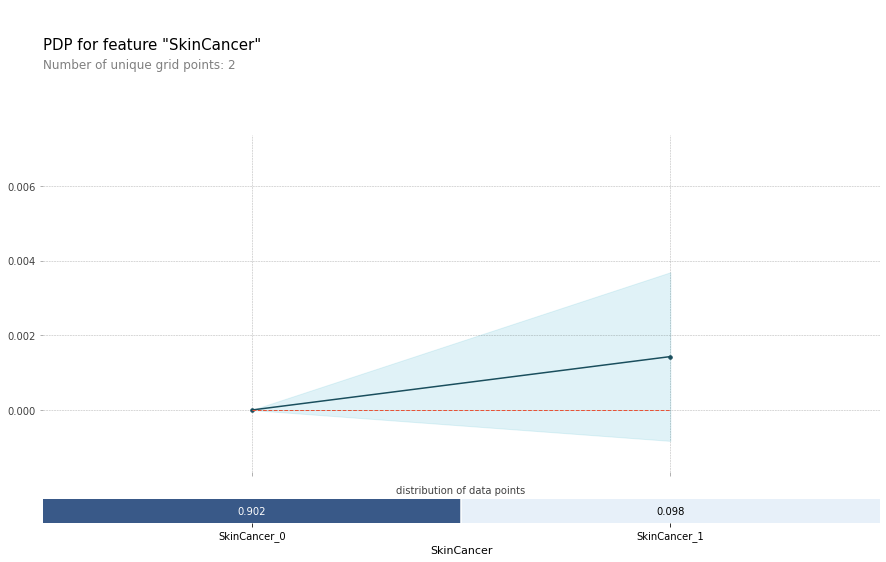

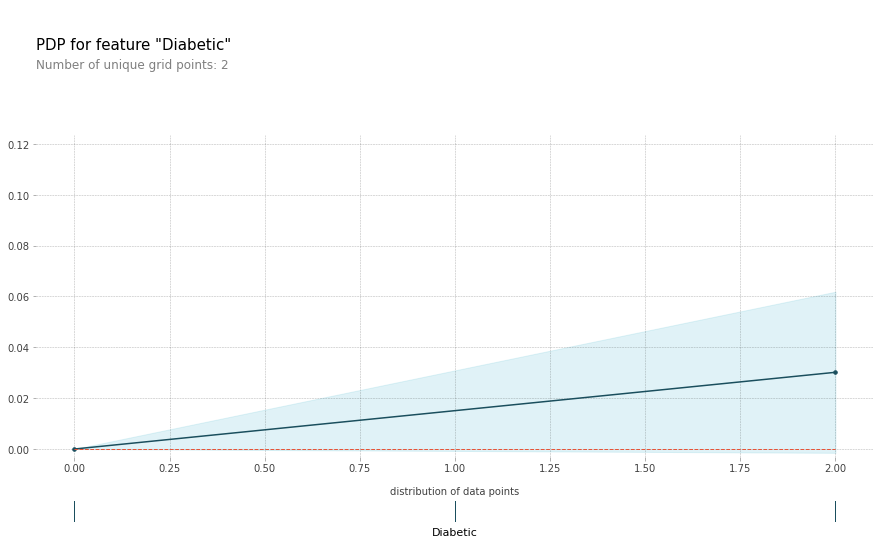

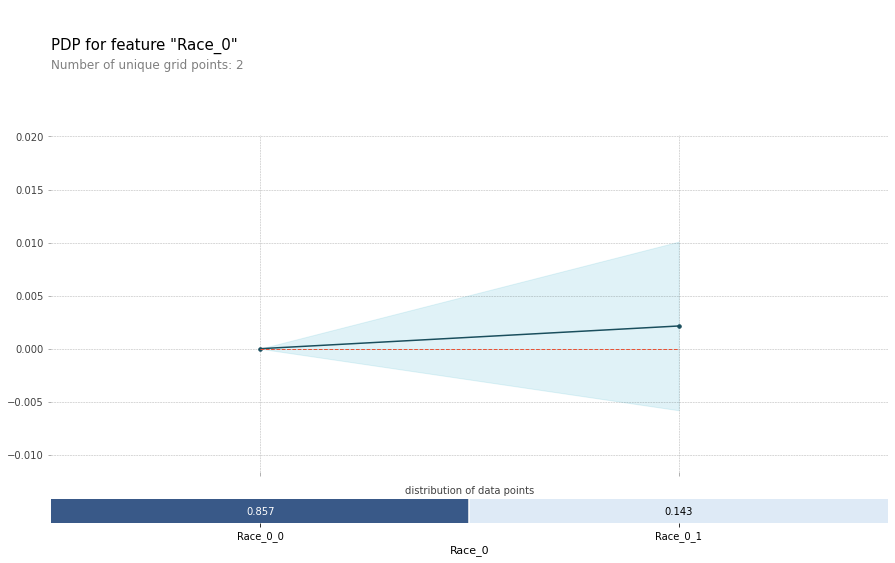

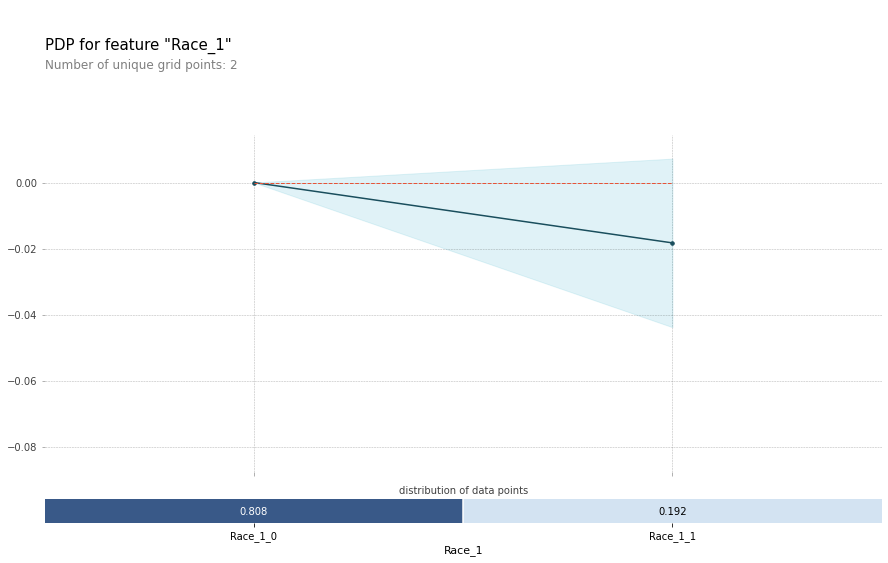

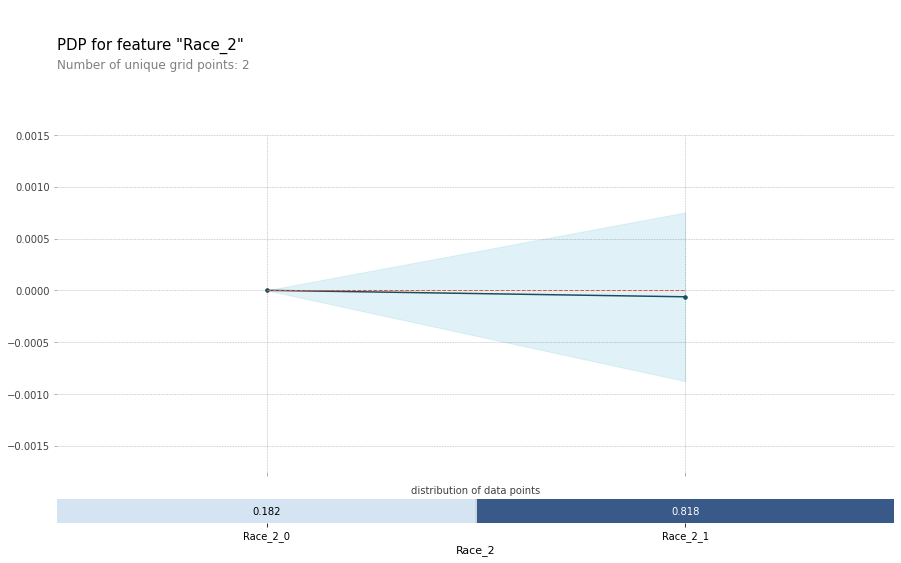

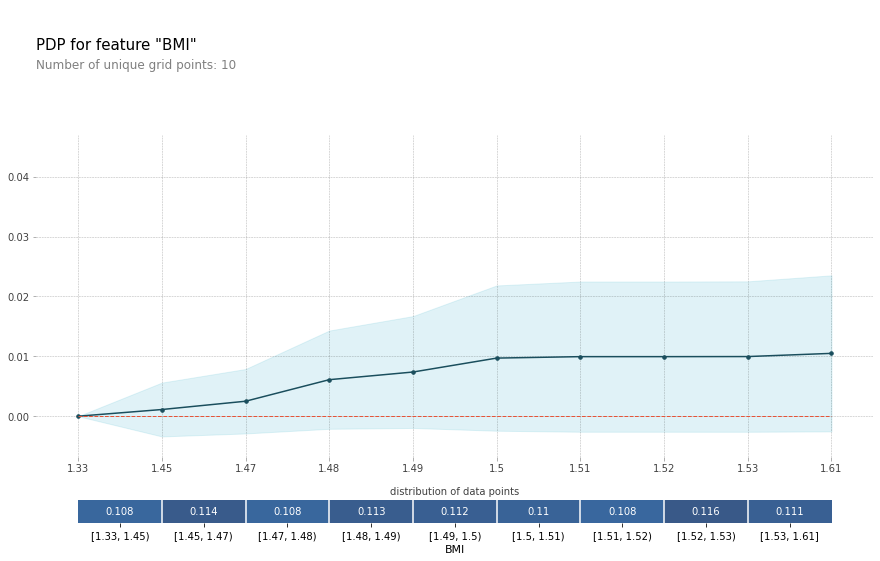

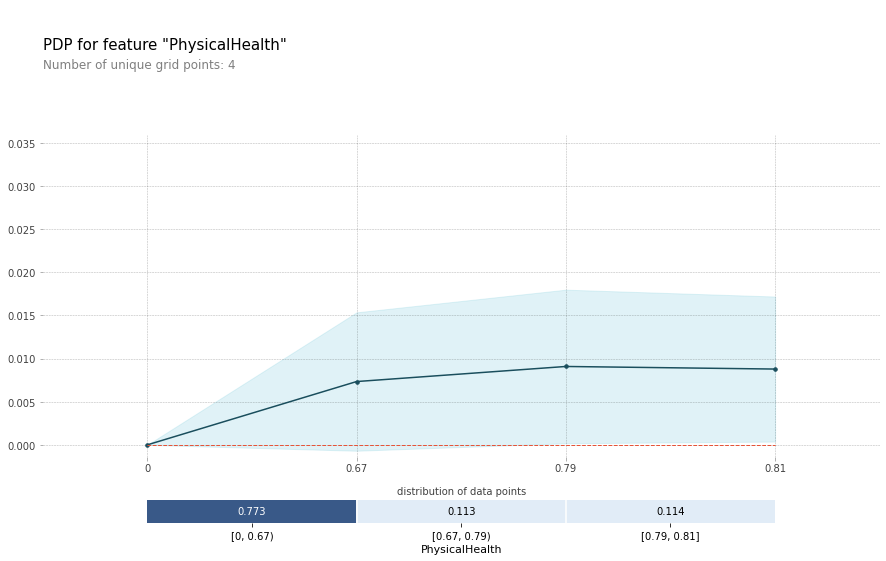

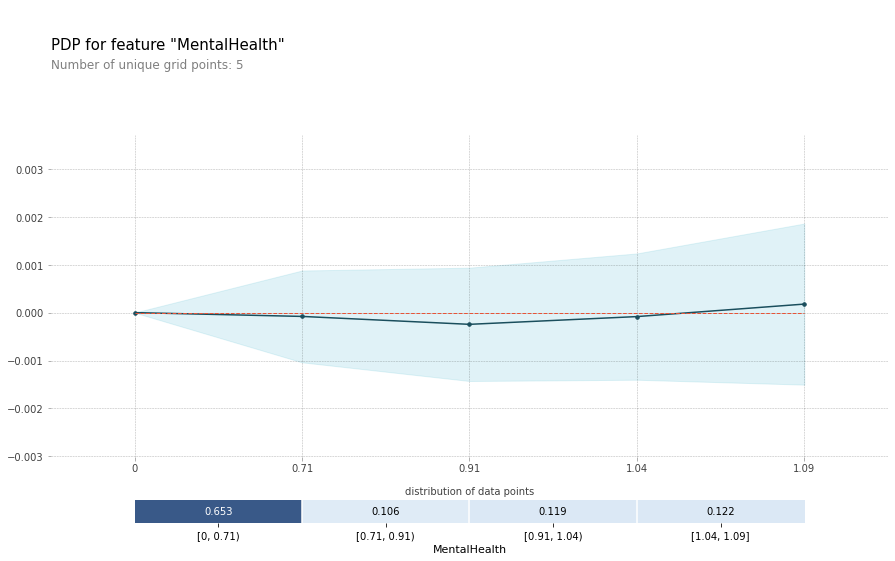

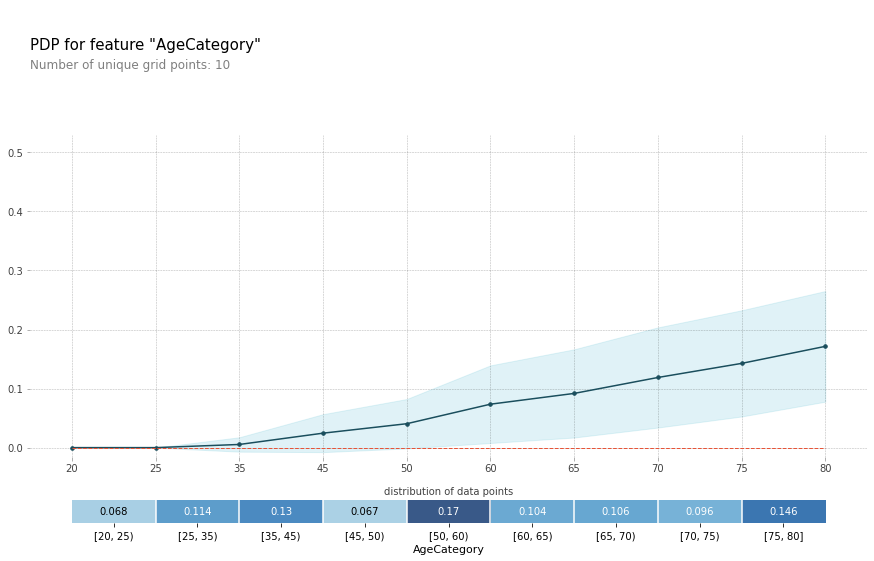

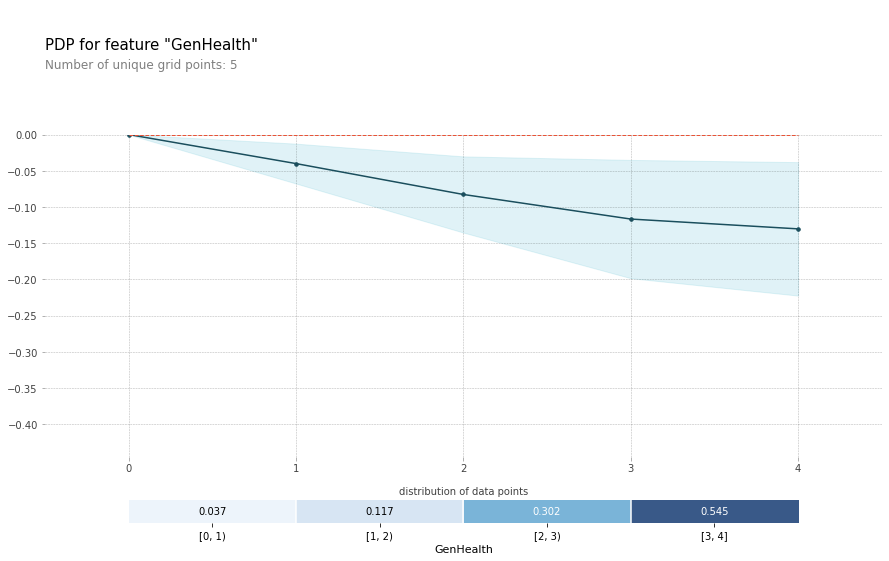

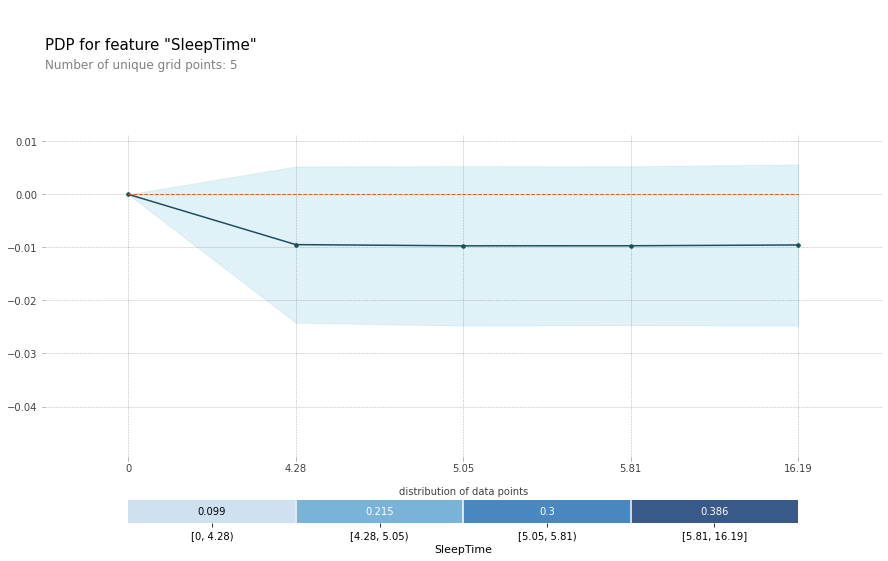

In [31]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

#0.03303716681266425
#0.053253127652507656
#0.07572168114416074
#0.08132696195552289
#0.0983399209486166
#0.10445172480246676
#Asian, Hispanic, Other, Black, White

In [32]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

100%|===================| 60323/60331 [01:13<00:00]       

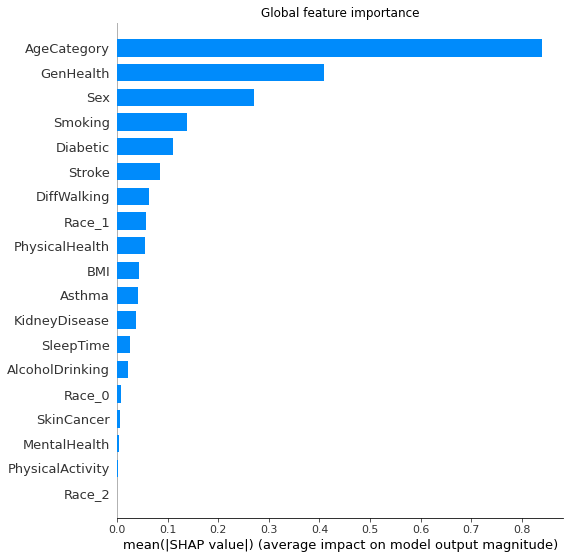

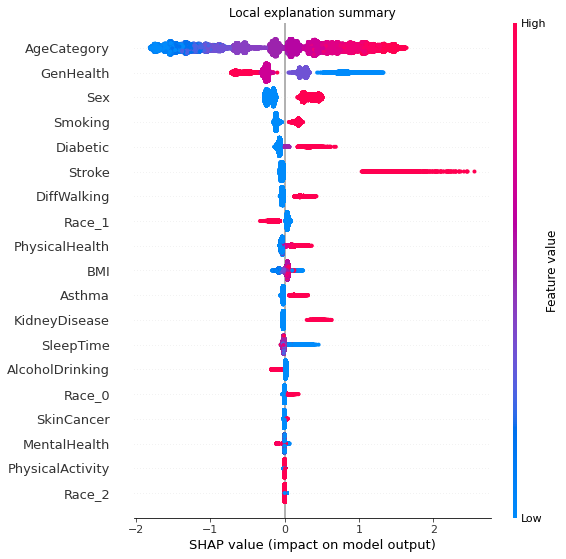

In [33]:
# SHAP
explainer = shap.Explainer(model, x_train, feature_names=features)
shap_values = explainer(x_test)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## Costsensitive

In [34]:
import xgboost as xgb

model_cost = xgb.XGBClassifier(scale_pos_weight=10)
model_cost.fit(x_train, y_train)

XGBClassifier(scale_pos_weight=10)

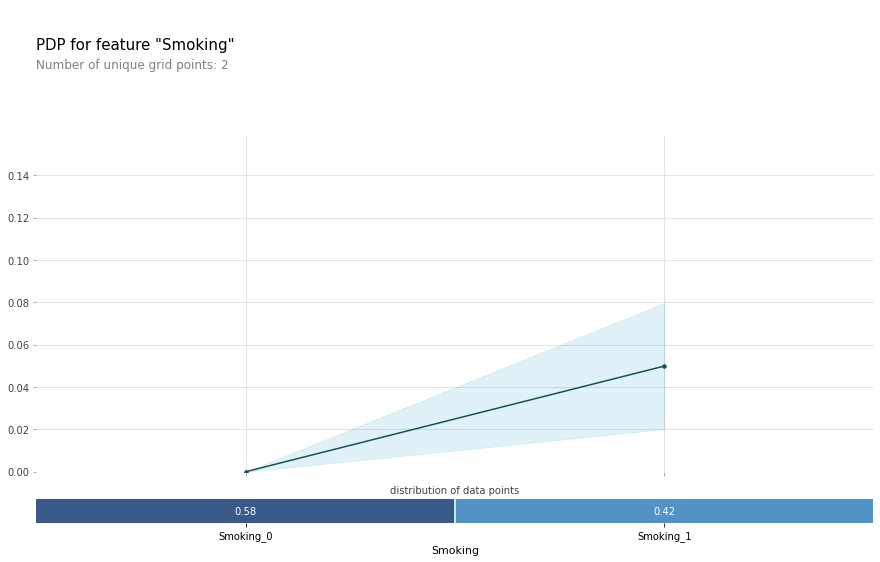

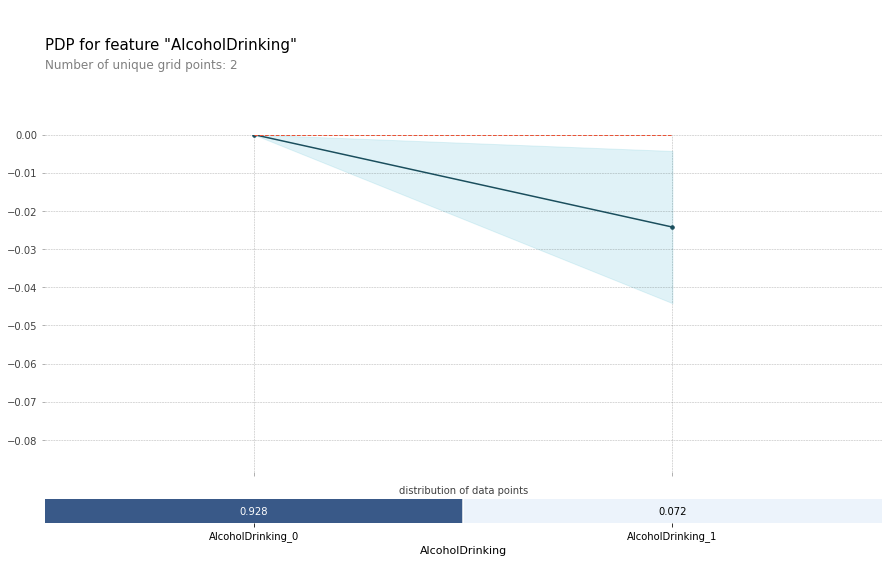

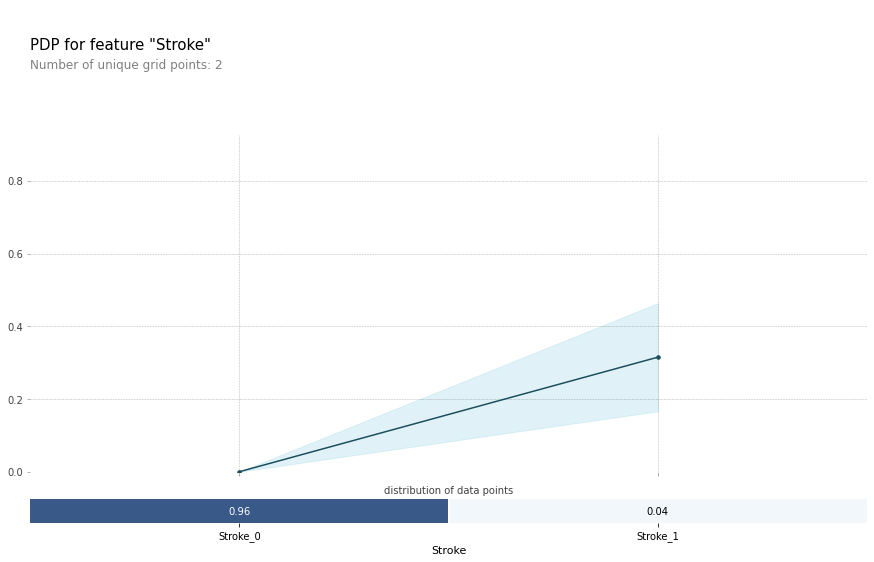

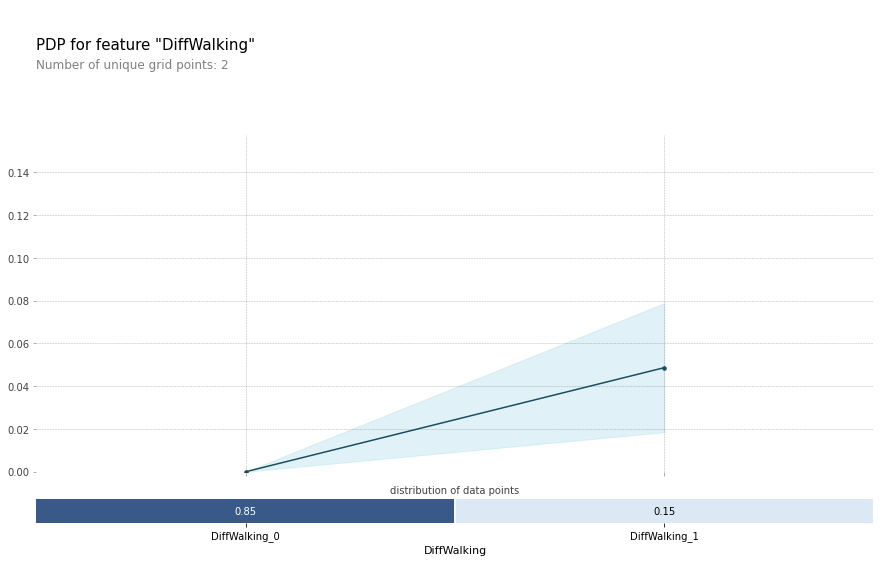

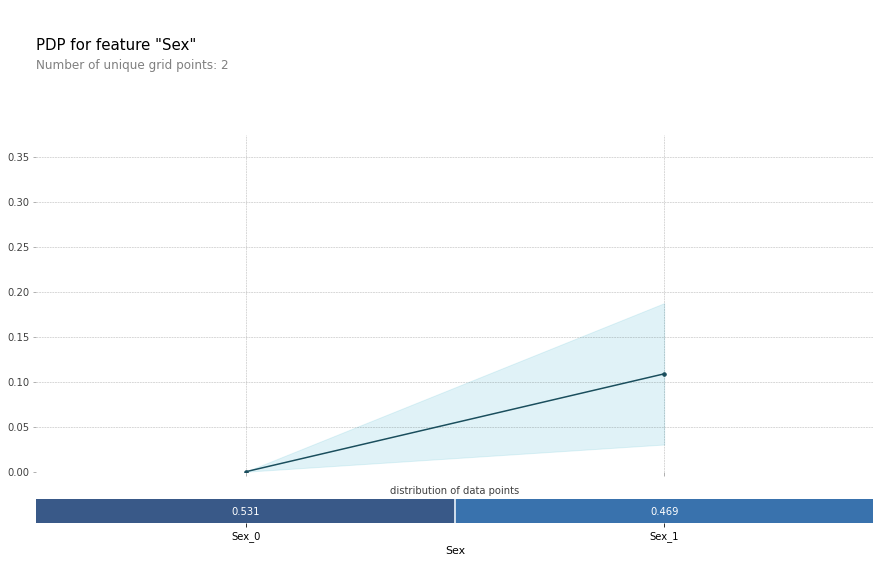

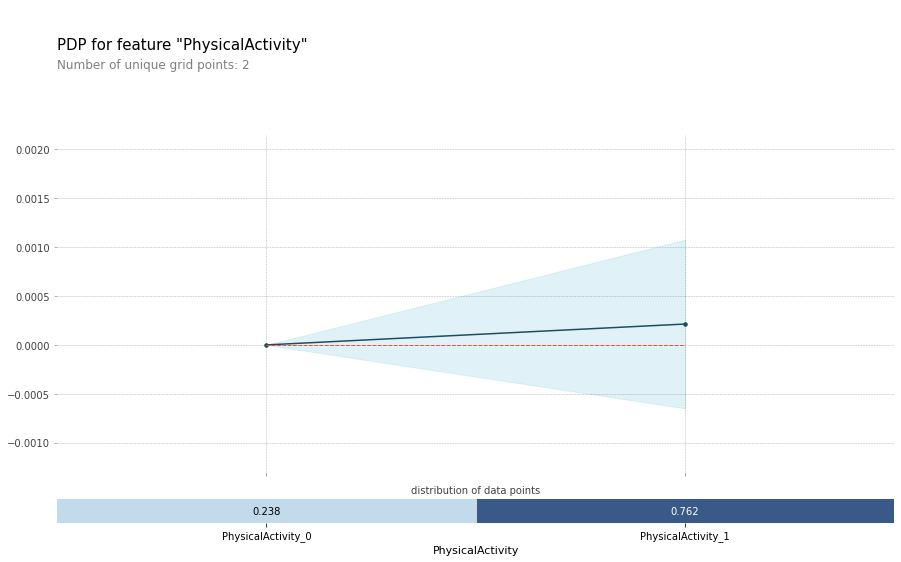

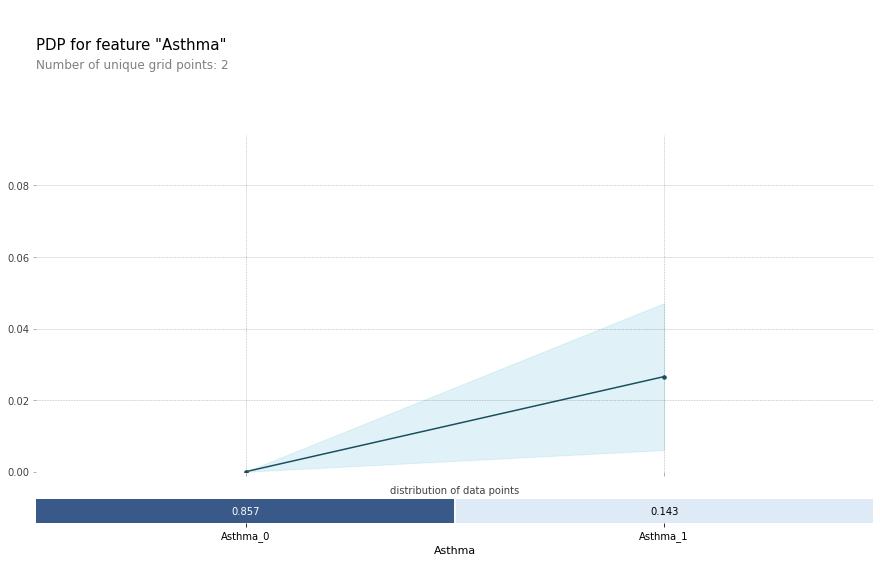

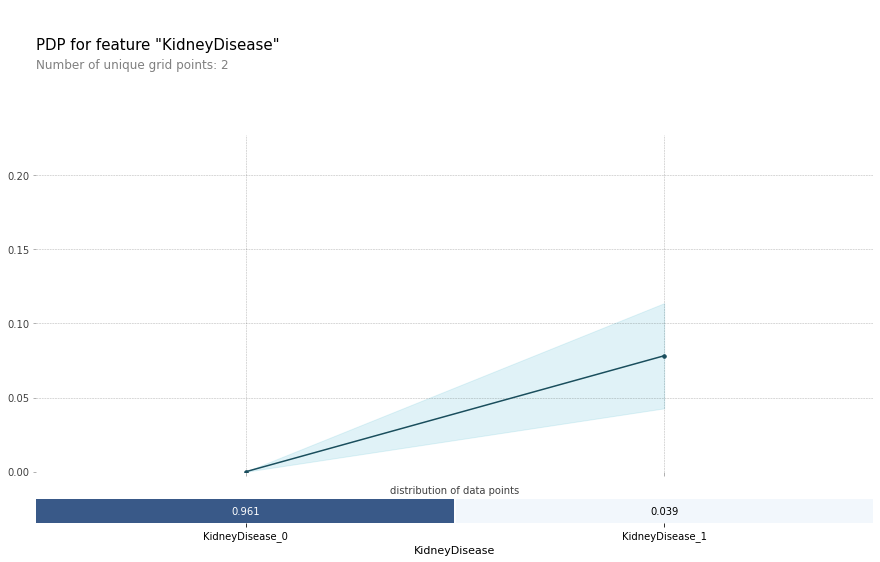

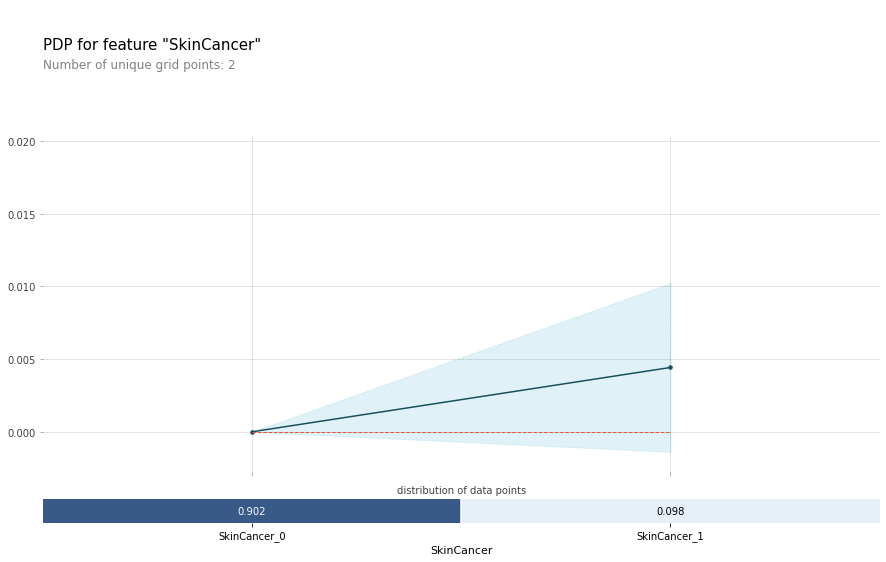

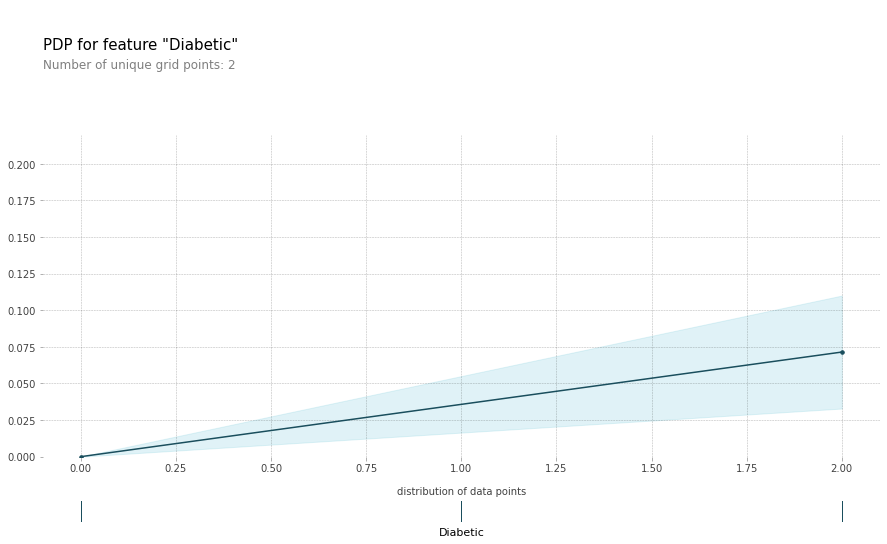

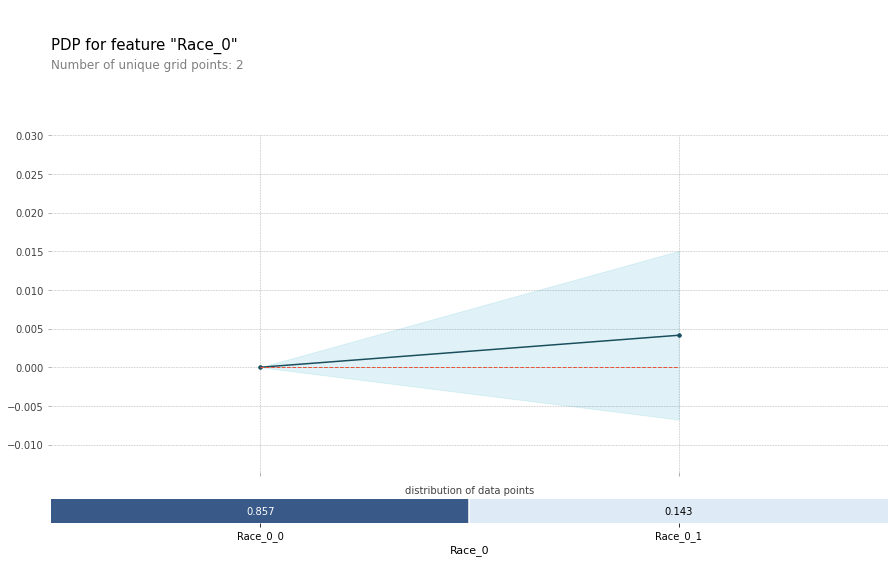

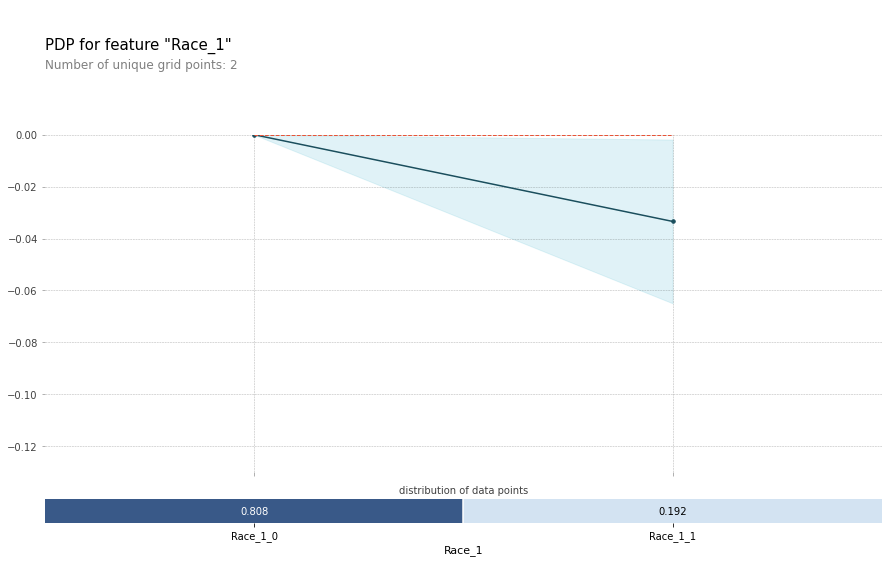

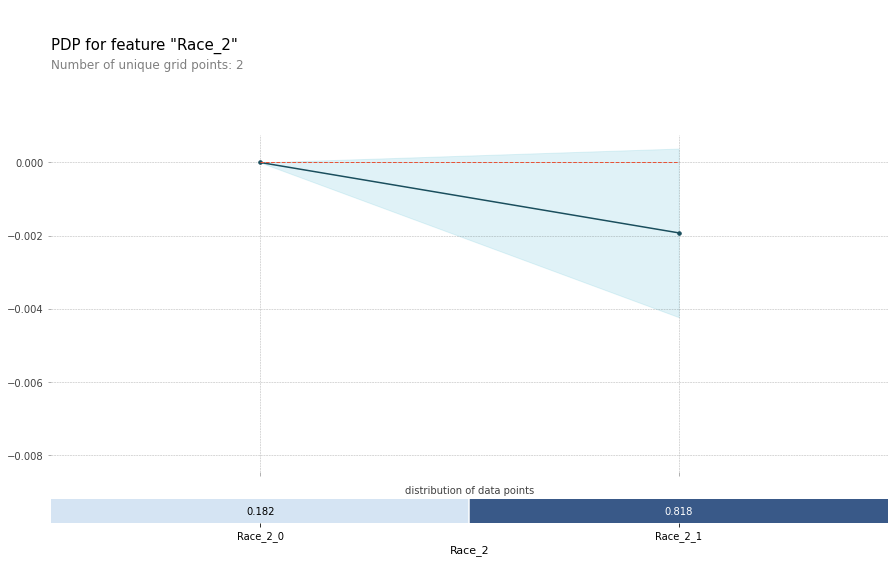

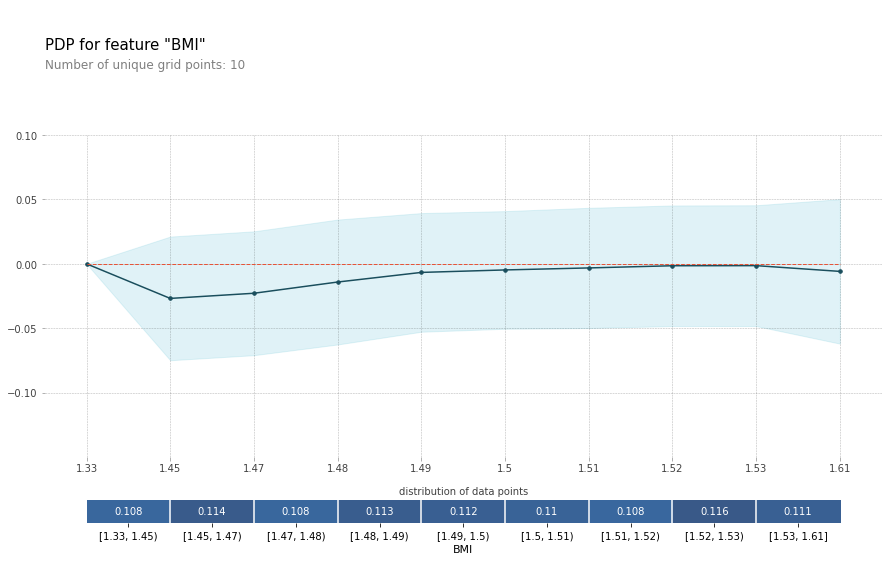

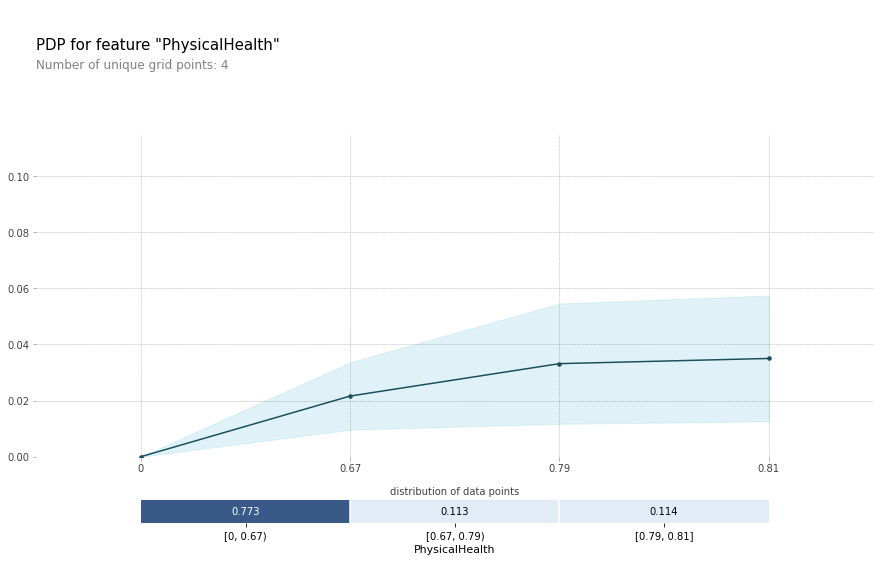

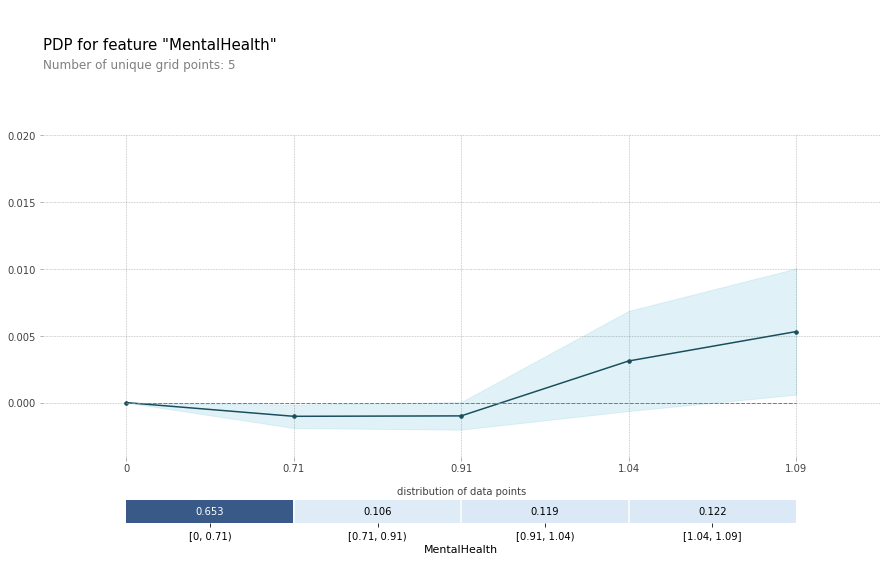

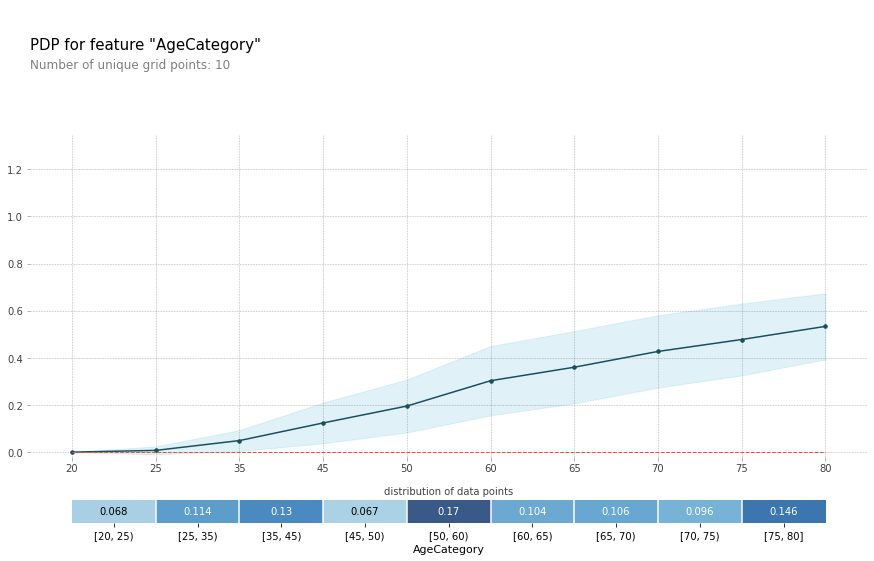

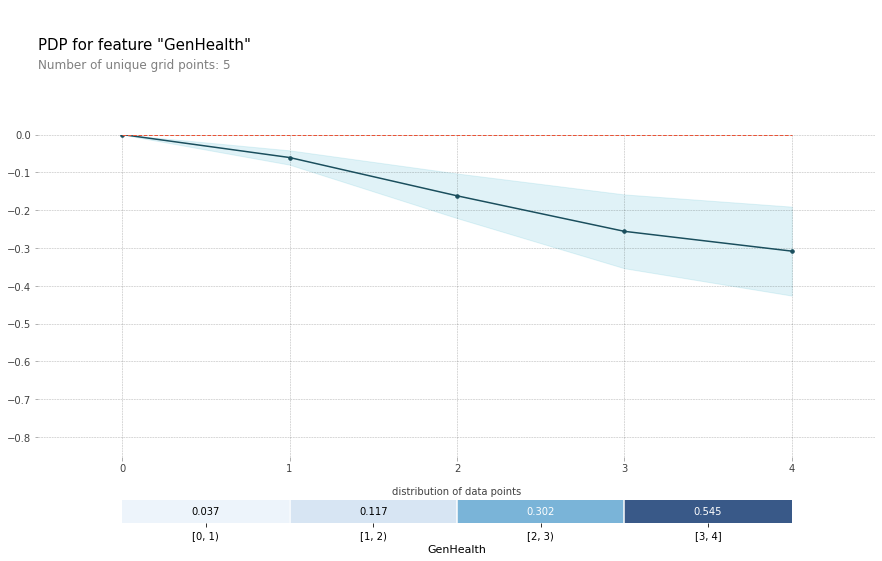

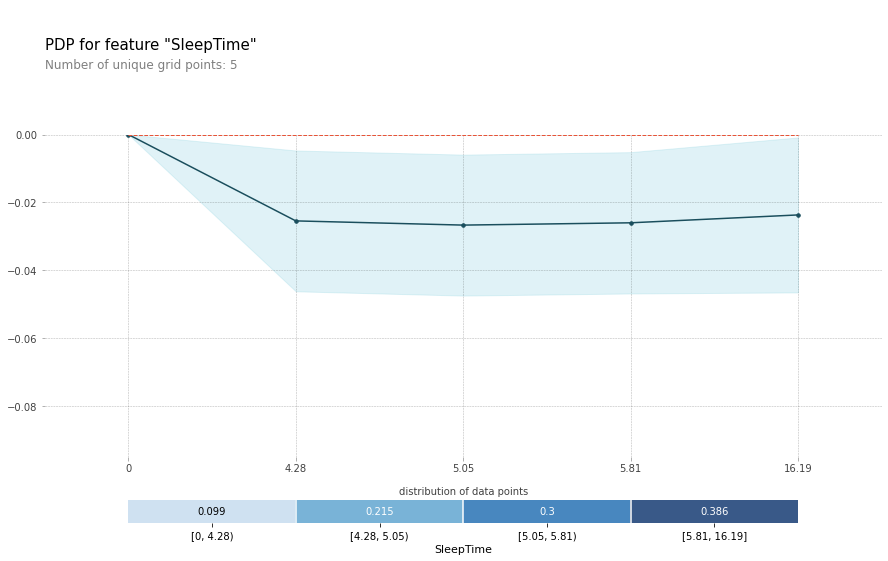

In [35]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_cost, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_cost, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [36]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_cost, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_cost, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

100%|===================| 60295/60331 [01:12<00:00]       

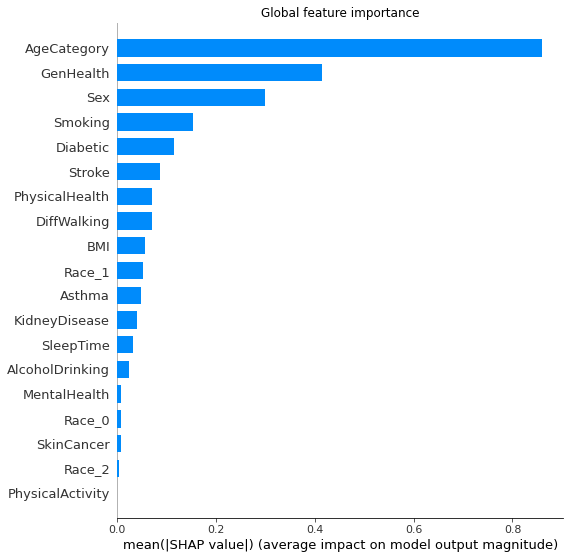

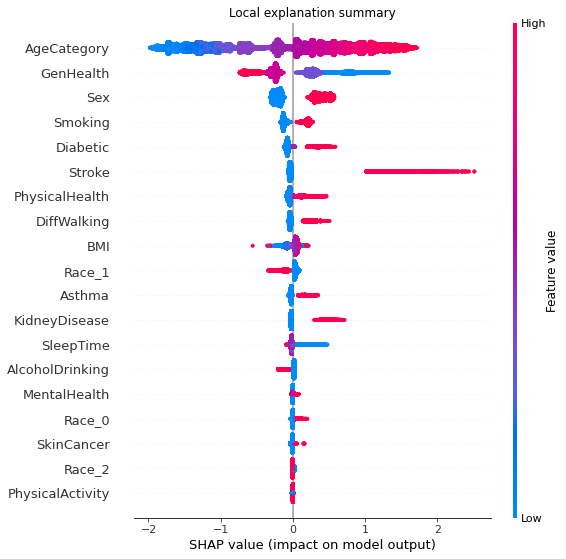

In [37]:
# SHAP
explainer = shap.Explainer(model_cost, x_train, feature_names=features)
shap_values = explainer(x_test)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## SMOTE

In [38]:
import xgboost as xgb

model_SMOTE = xgb.XGBClassifier()
model_SMOTE.fit(x_train_SMOTE, y_train_SMOTE)

XGBClassifier()

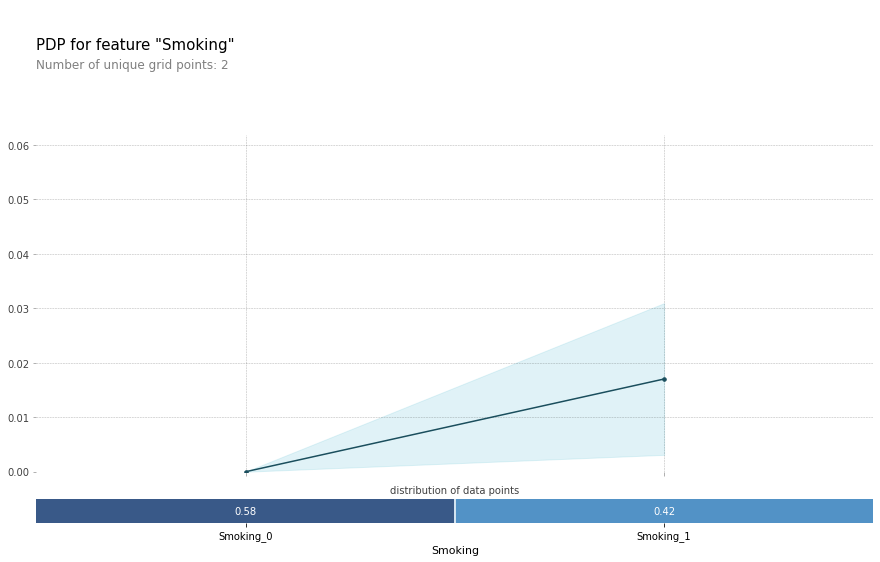

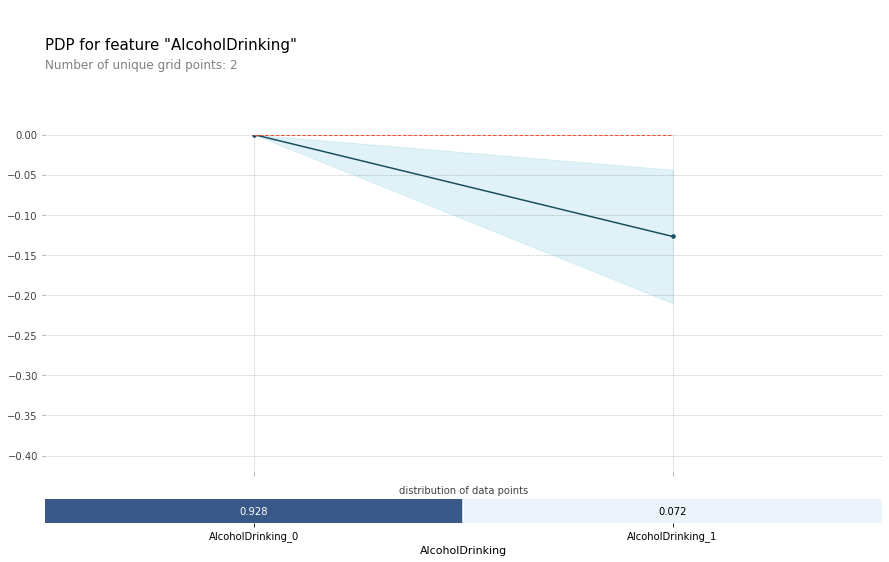

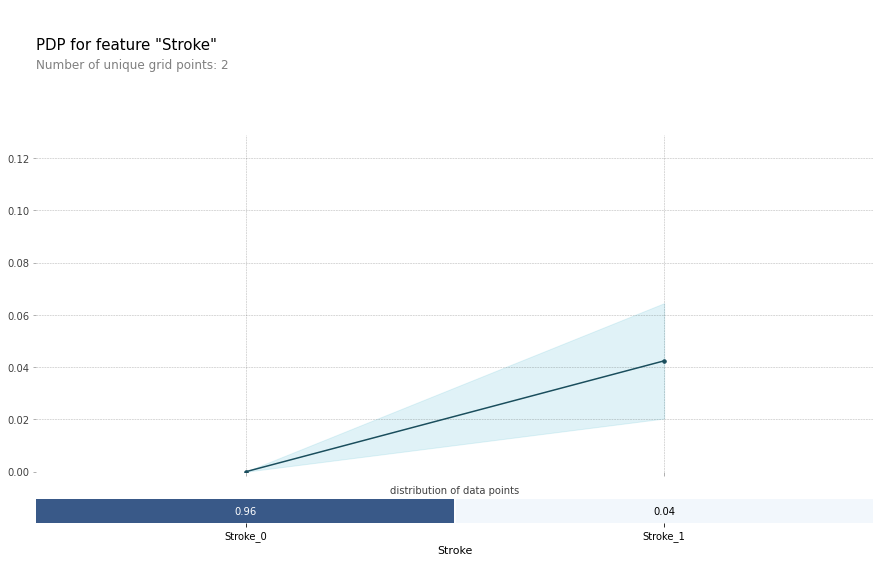

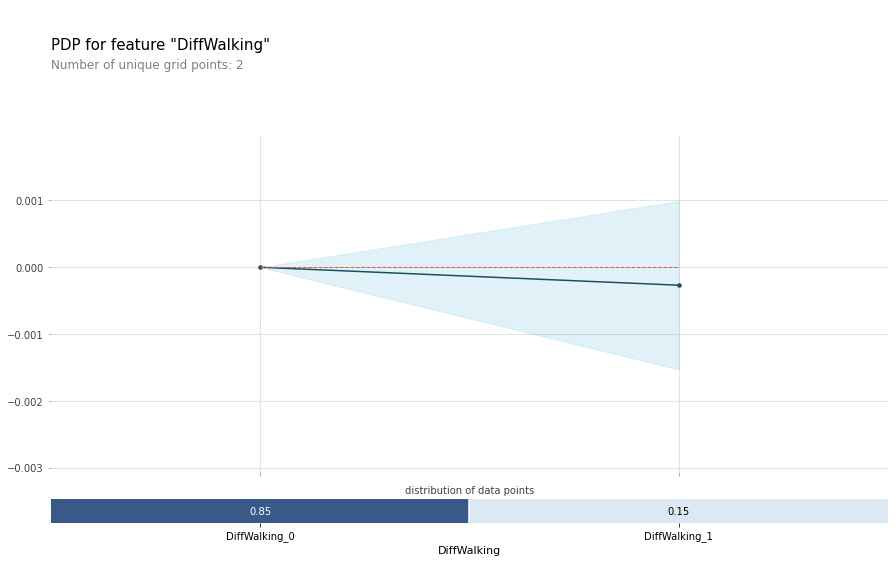

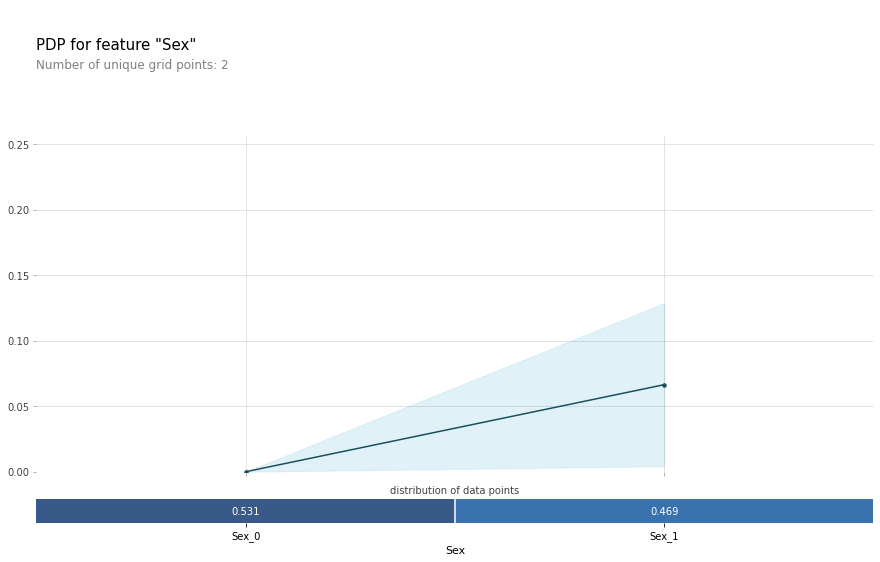

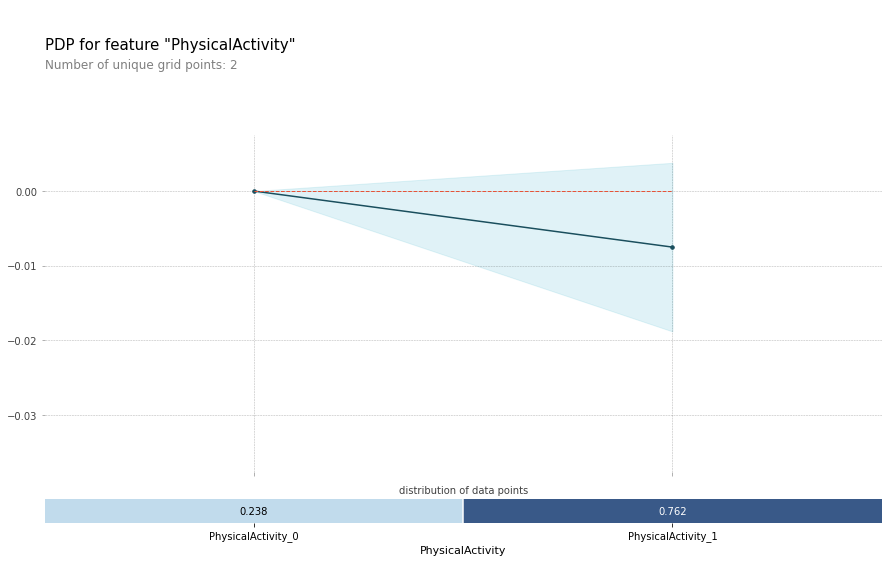

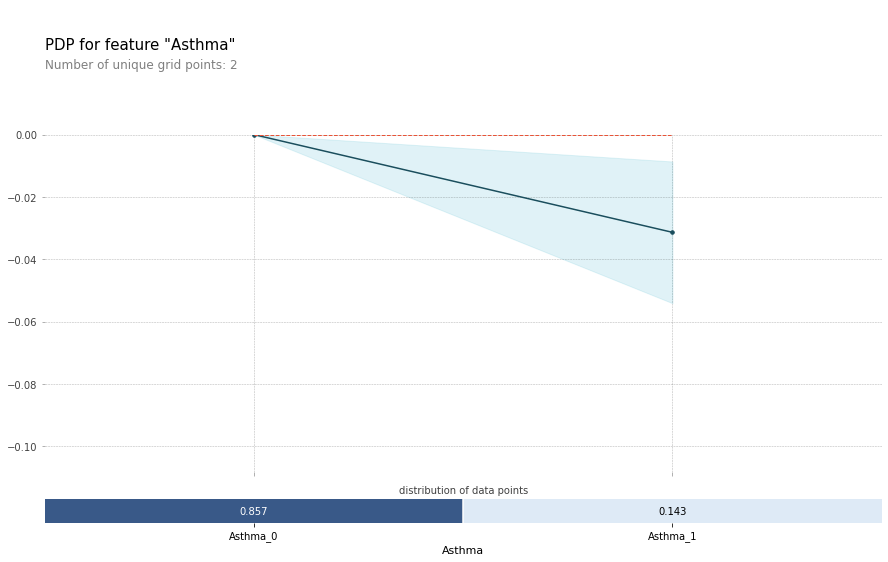

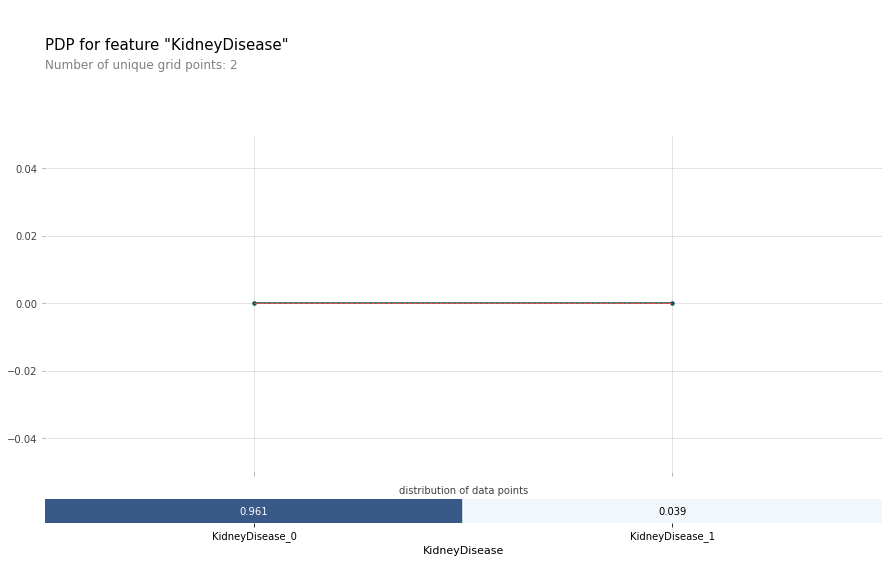

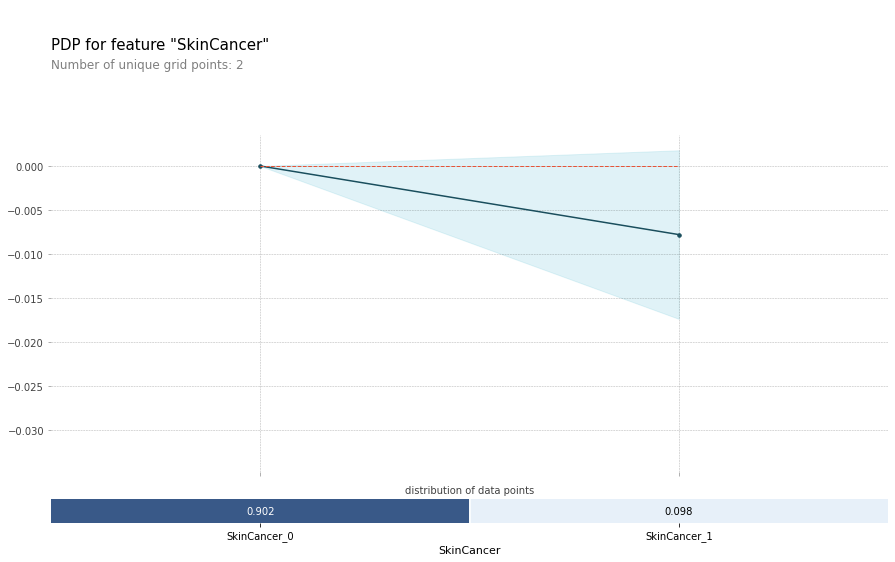

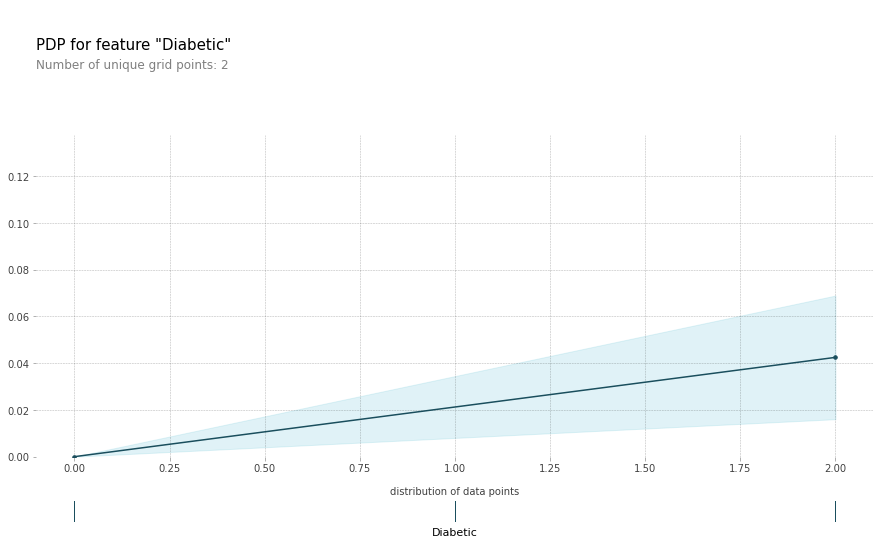

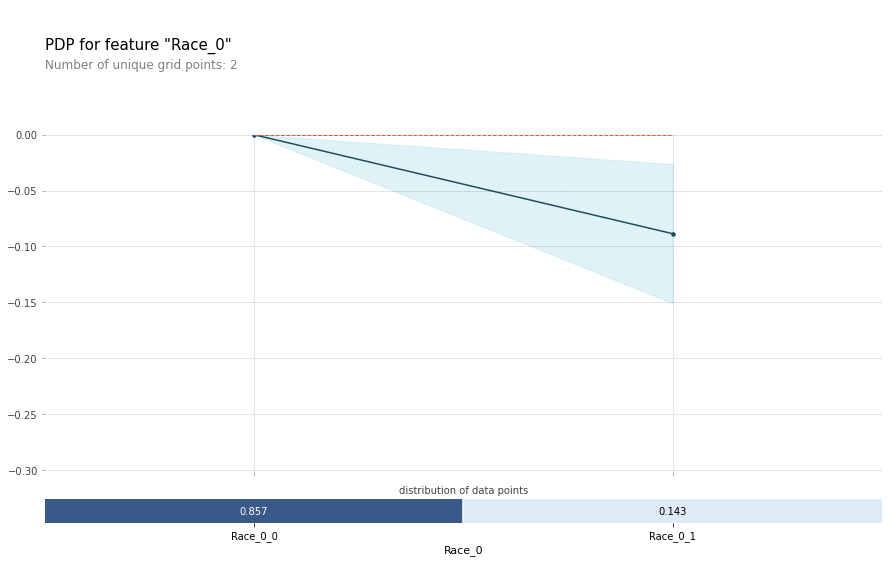

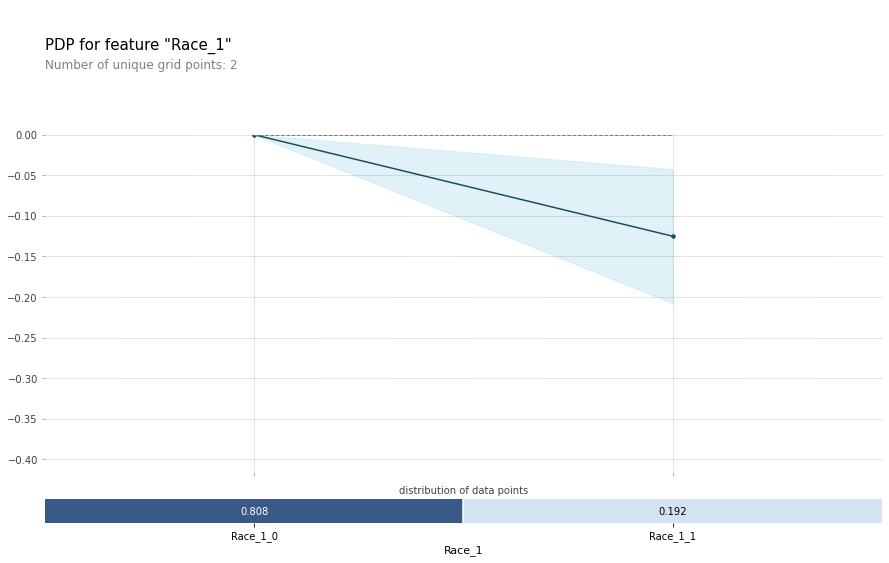

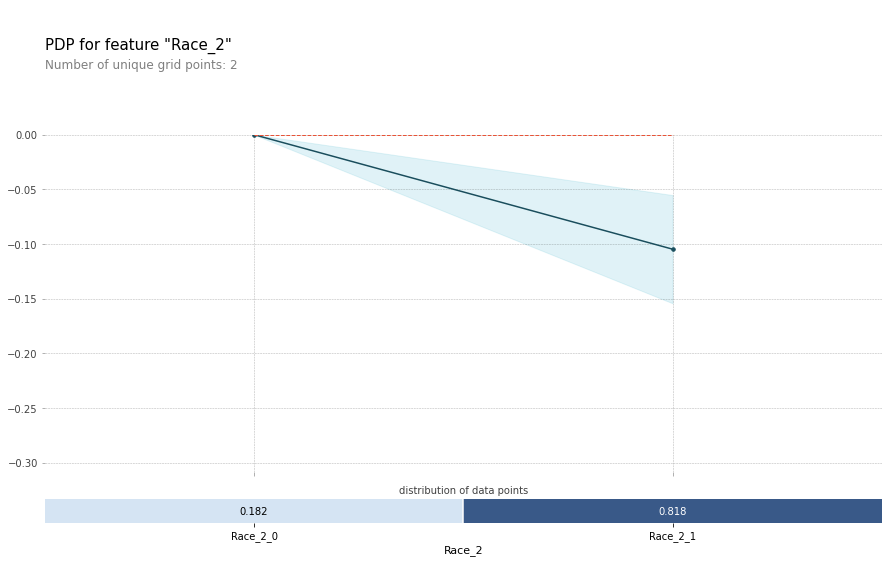

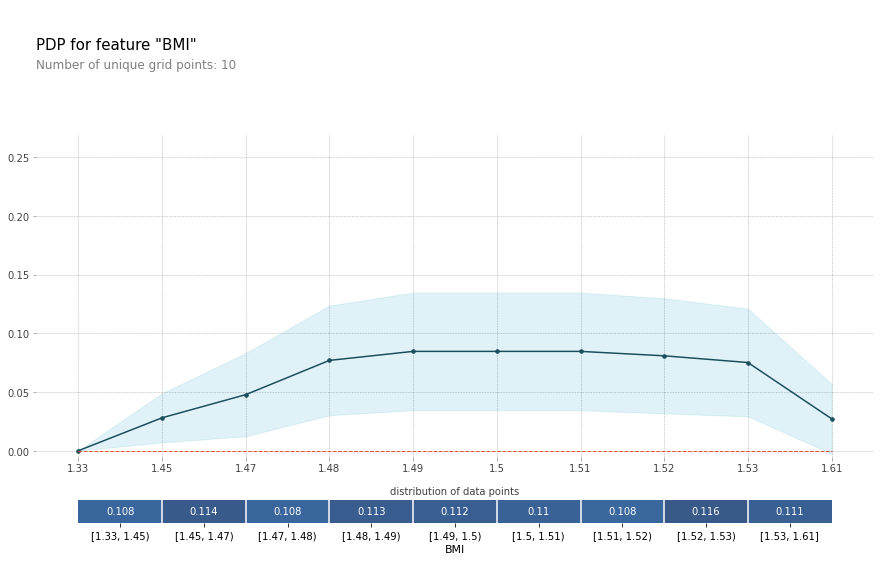

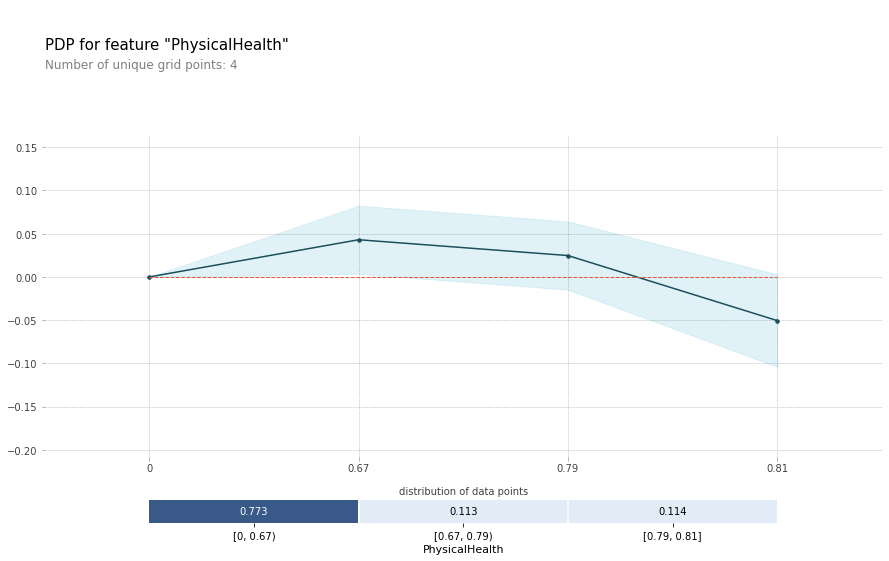

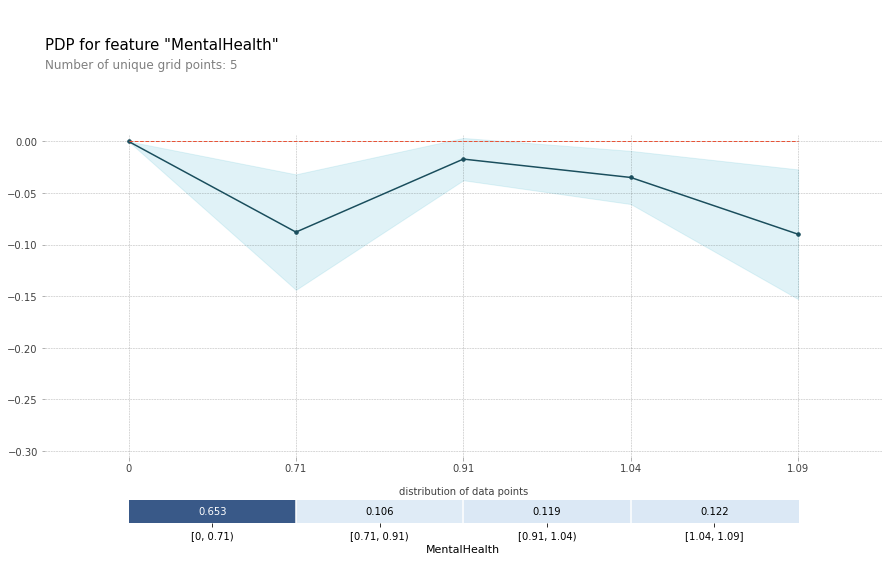

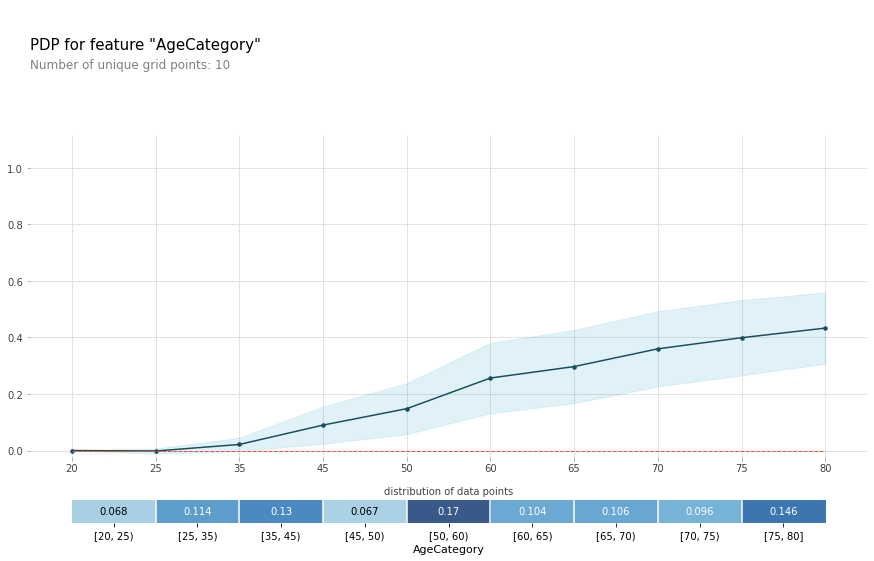

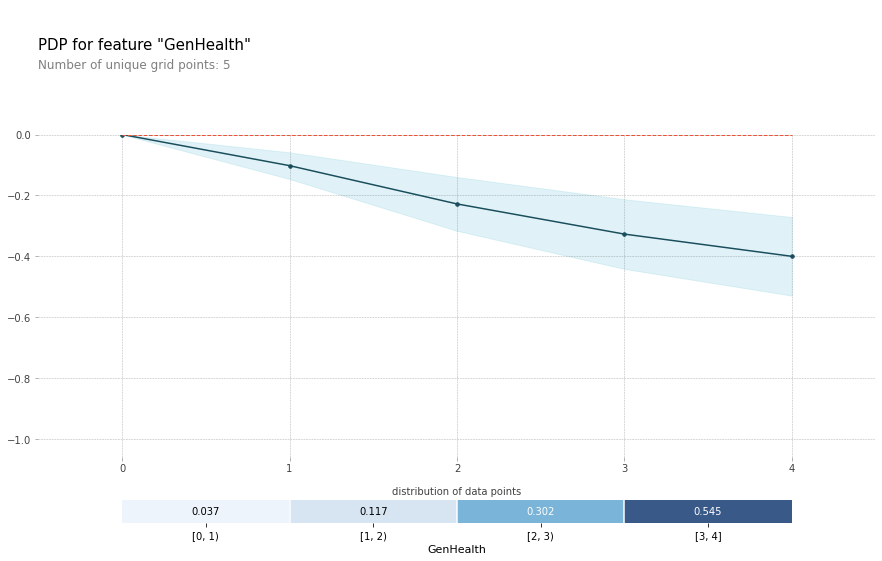

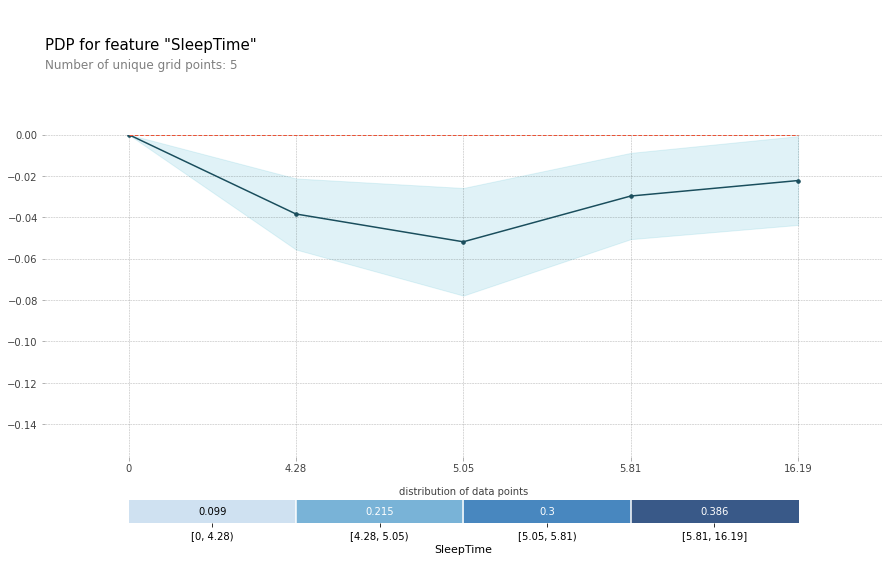

In [39]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [40]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

 99%|===================| 59964/60331 [01:09<00:00]       

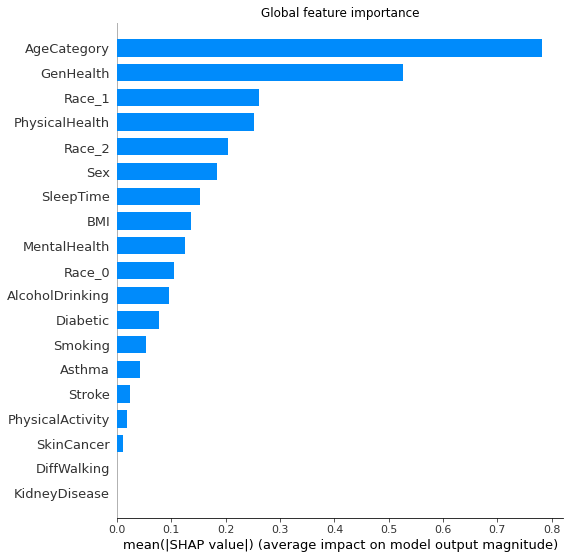

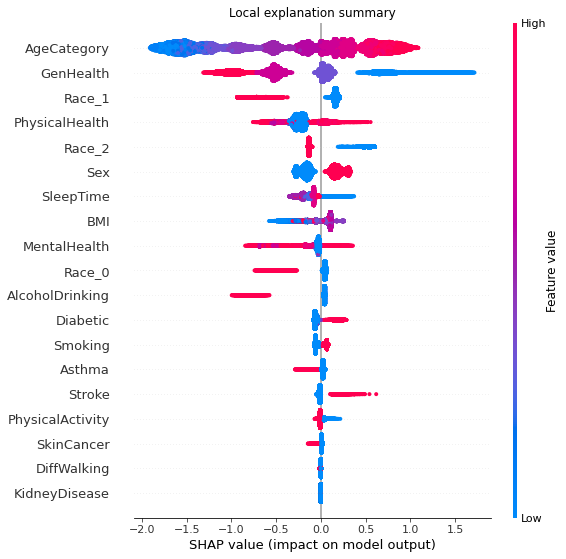

In [41]:
# SHAP
explainer = shap.Explainer(model_SMOTE, x_train_SMOTE, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## BorderlineSMOTE

In [42]:
model_BorderlineSM = xgb.XGBClassifier()
model_BorderlineSM.fit(x_train_BorderlineSM, y_train_BorderlineSM)

XGBClassifier()

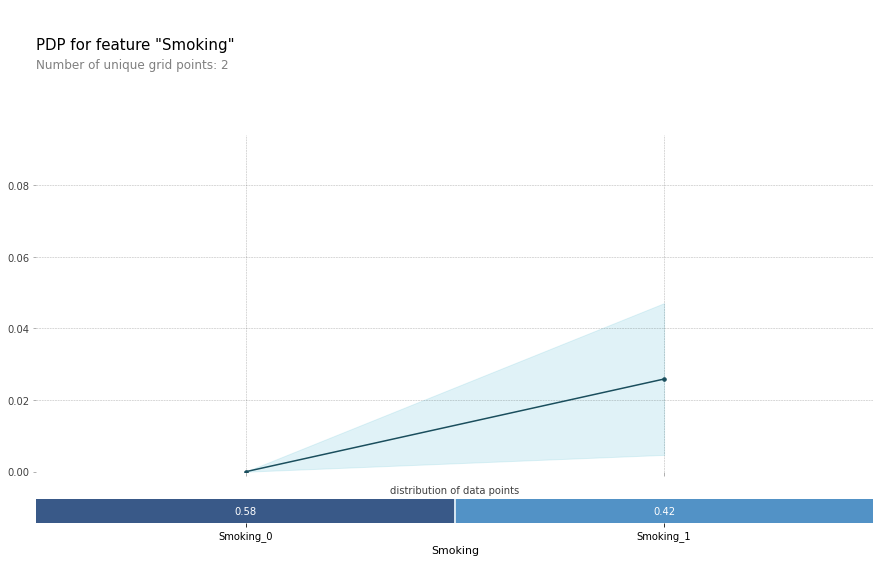

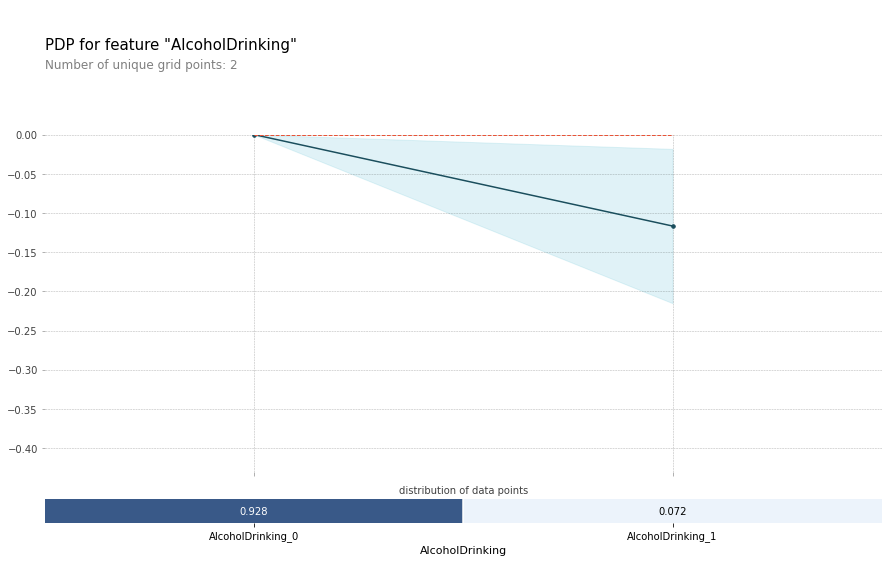

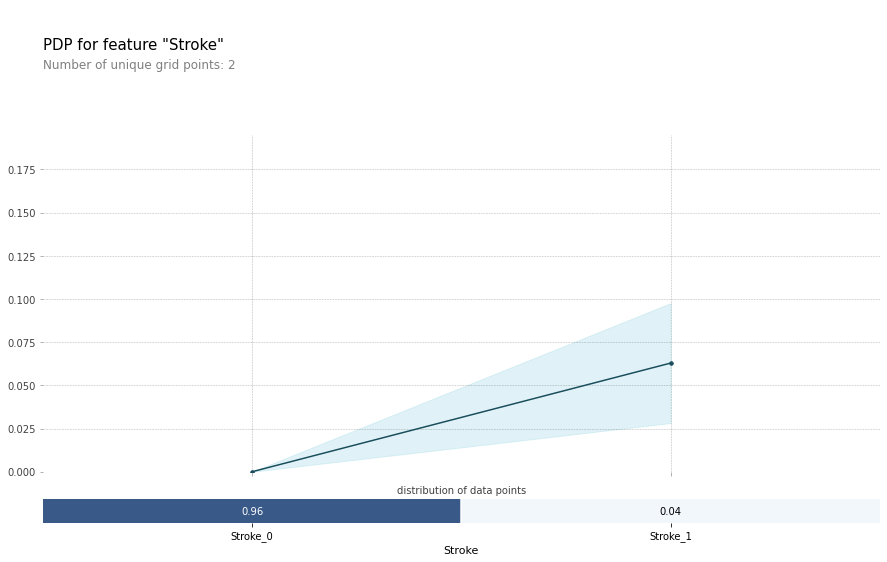

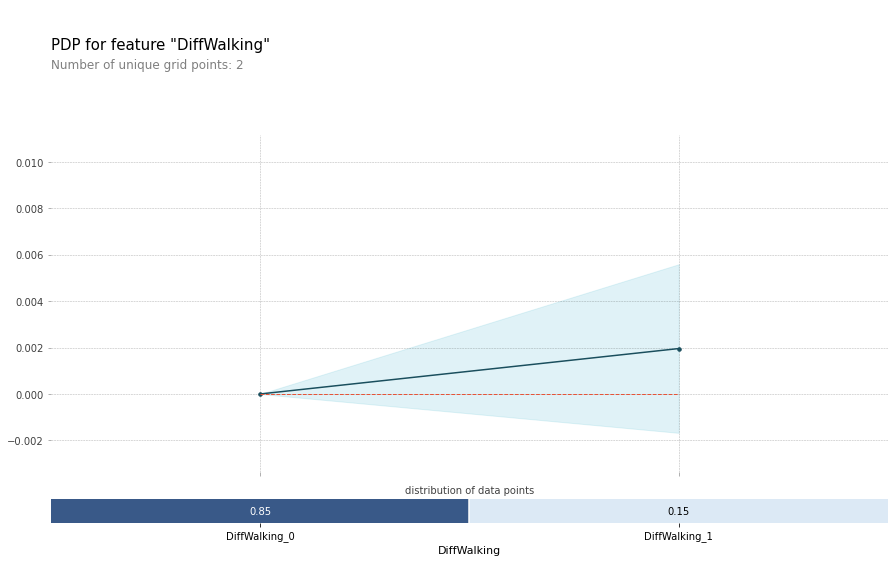

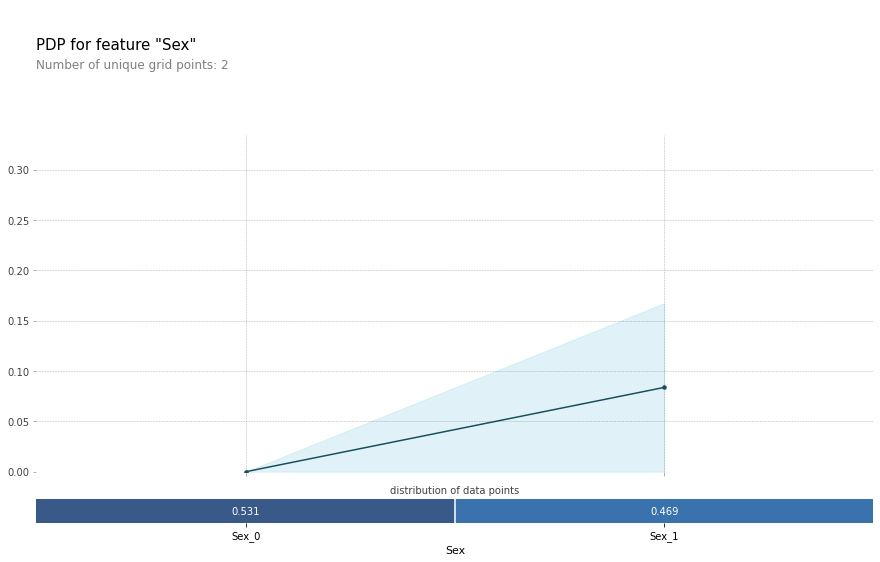

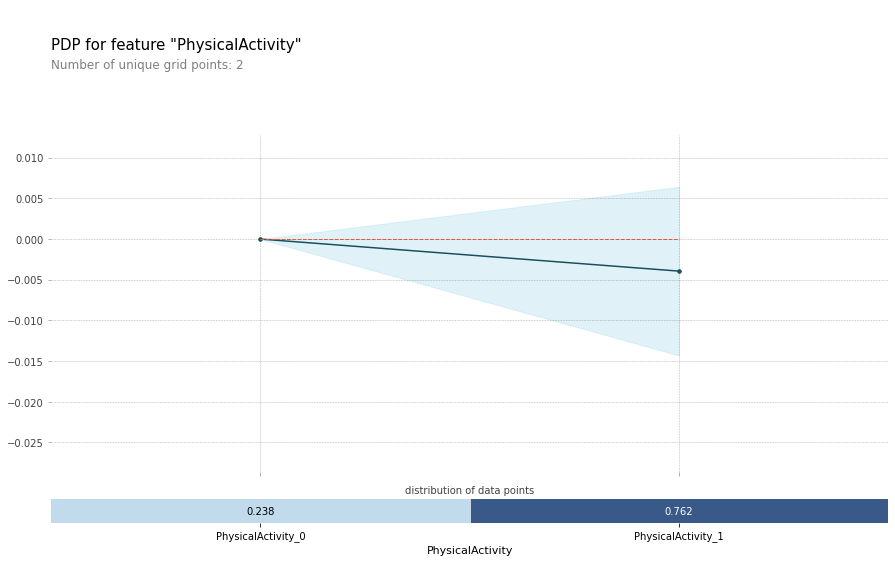

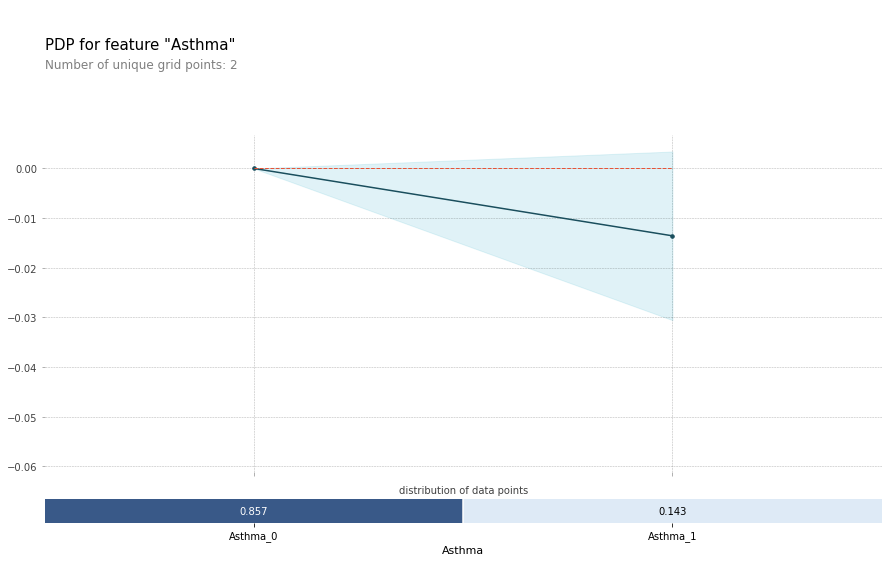

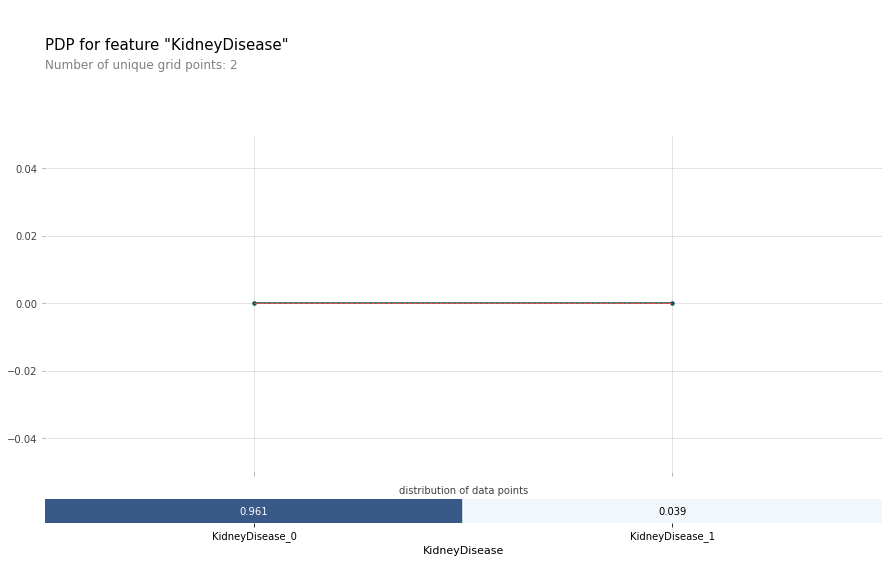

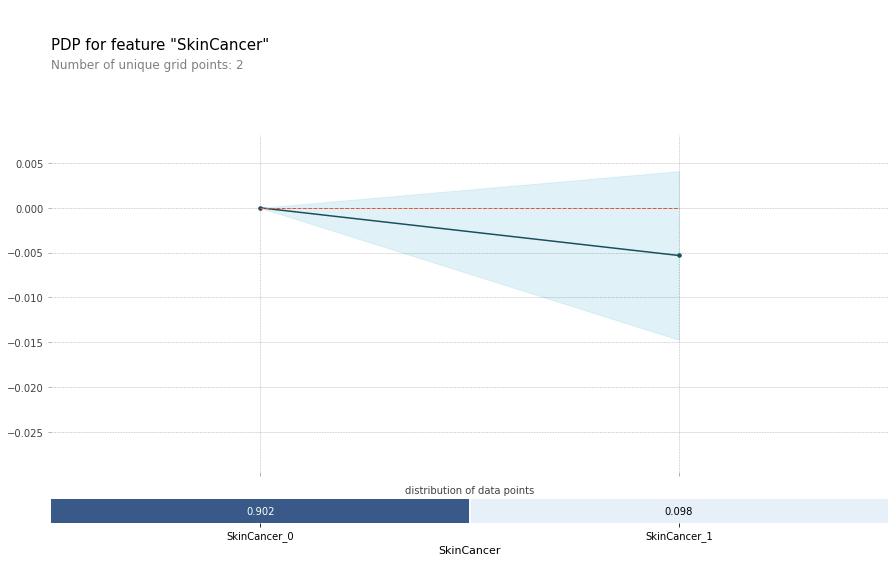

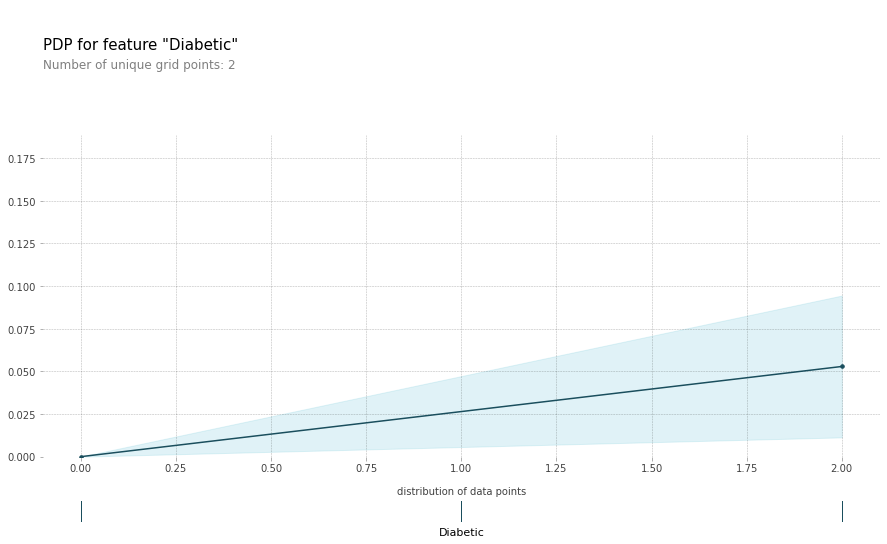

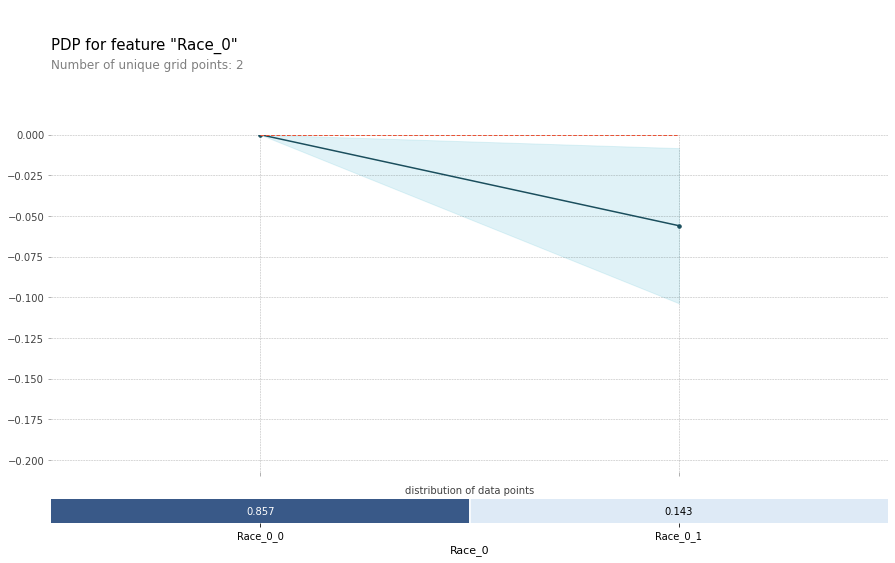

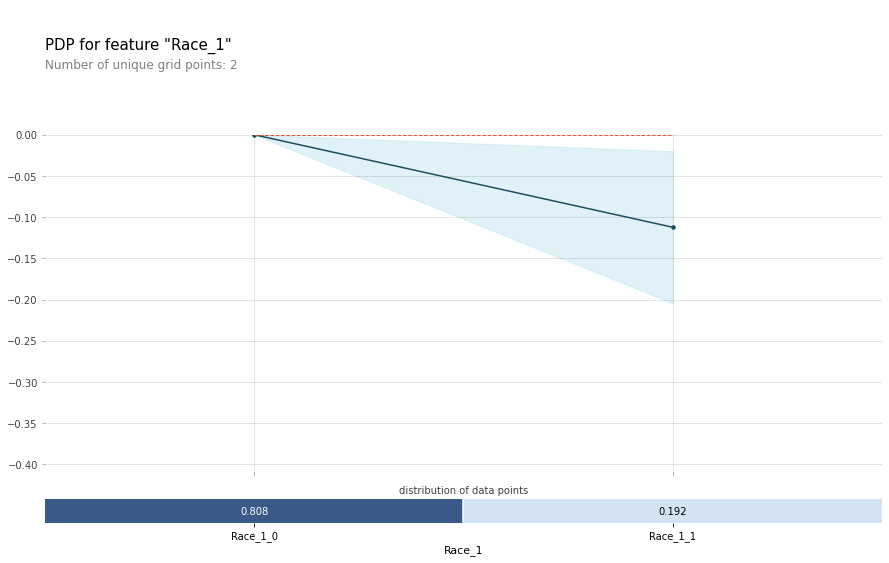

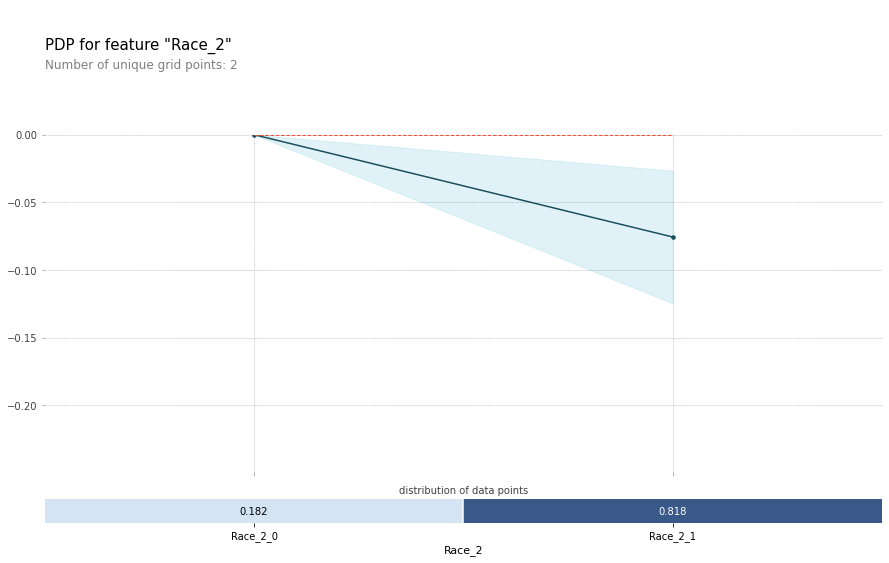

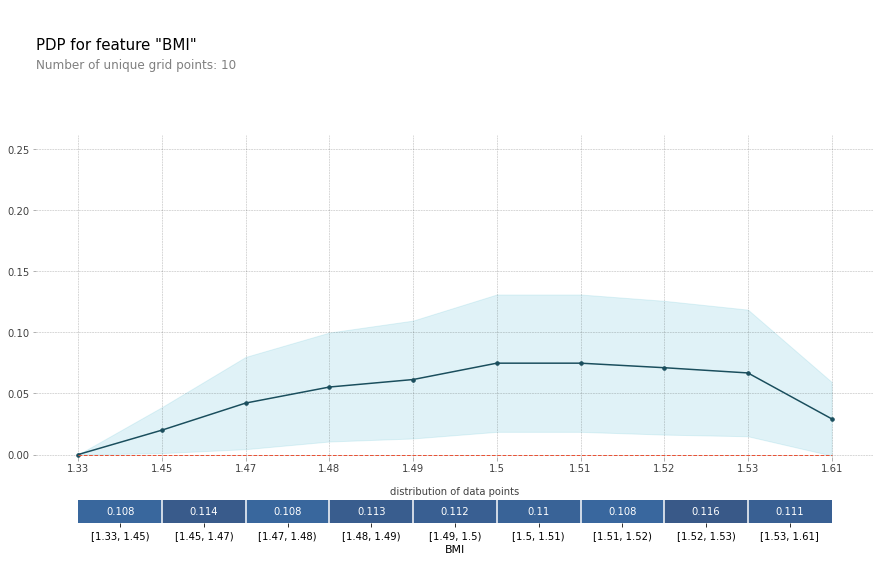

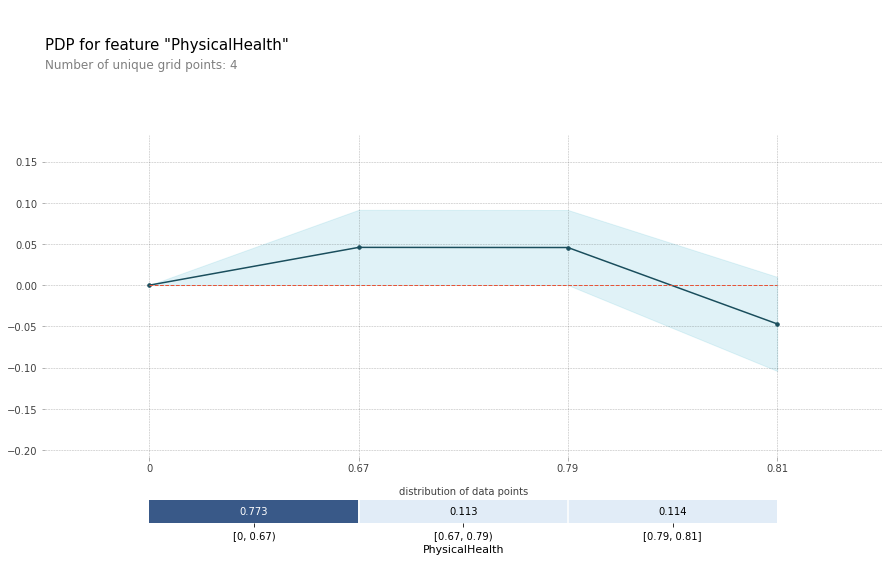

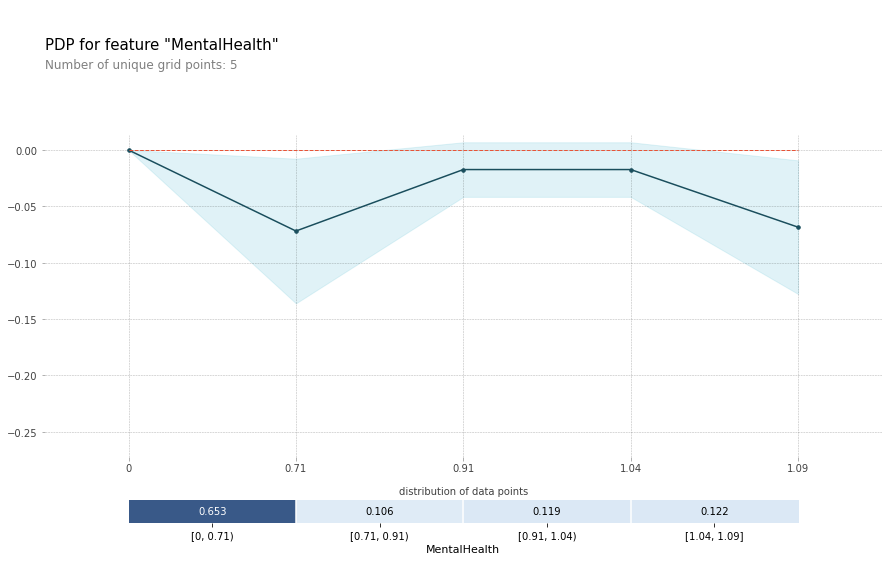

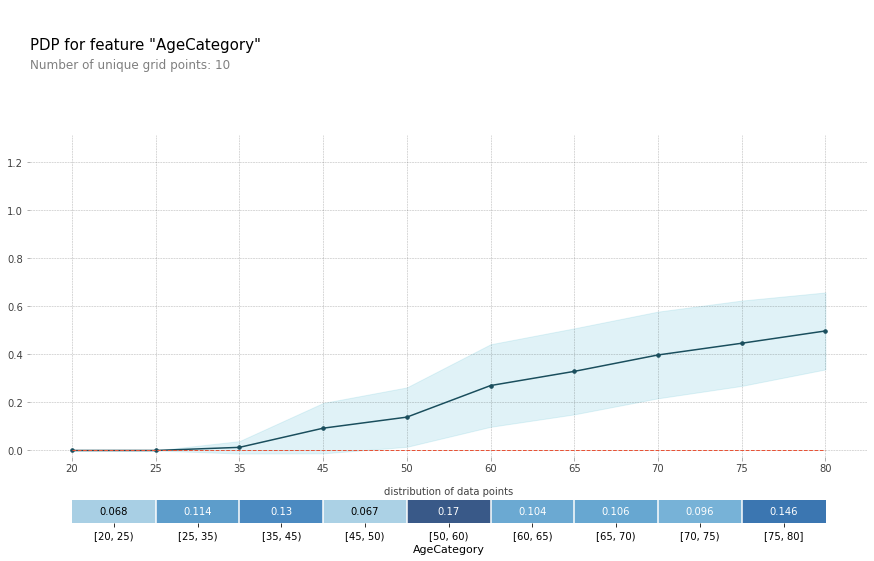

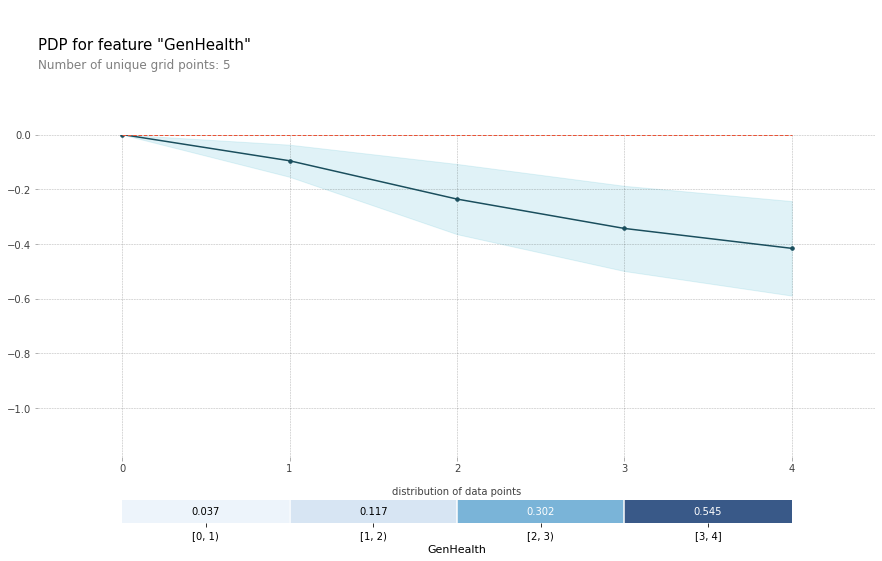

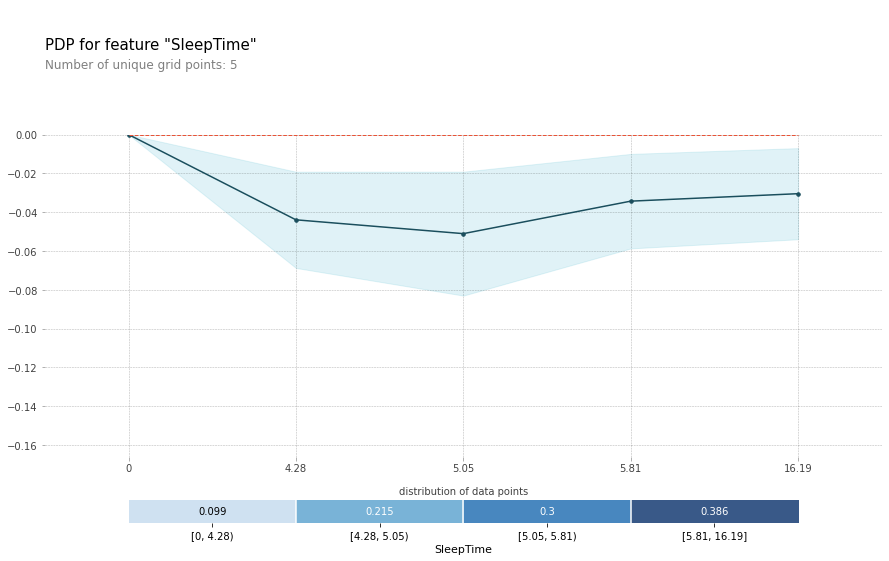

In [43]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [44]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_BorderlineSM, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

100%|===================| 60086/60331 [01:09<00:00]       

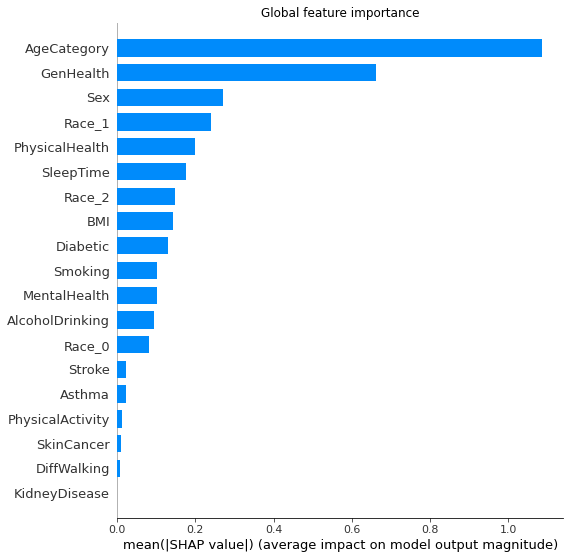

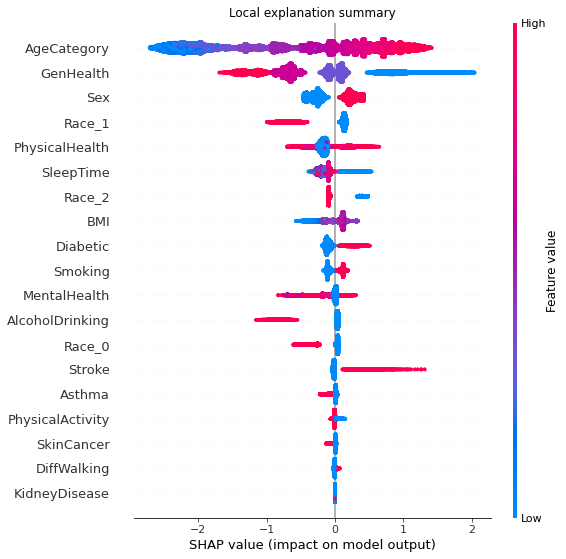

In [45]:
# SHAP
explainer = shap.Explainer(model_BorderlineSM, x_train_BorderlineSM, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## SVMSMOTE

In [46]:
model_SVMSMOTE = xgb.XGBClassifier()
model_SVMSMOTE.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)

XGBClassifier()

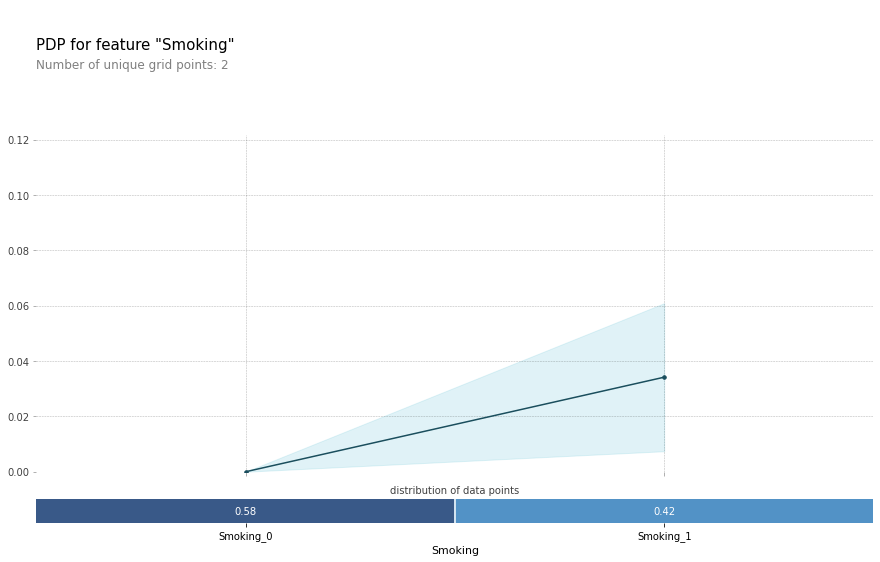

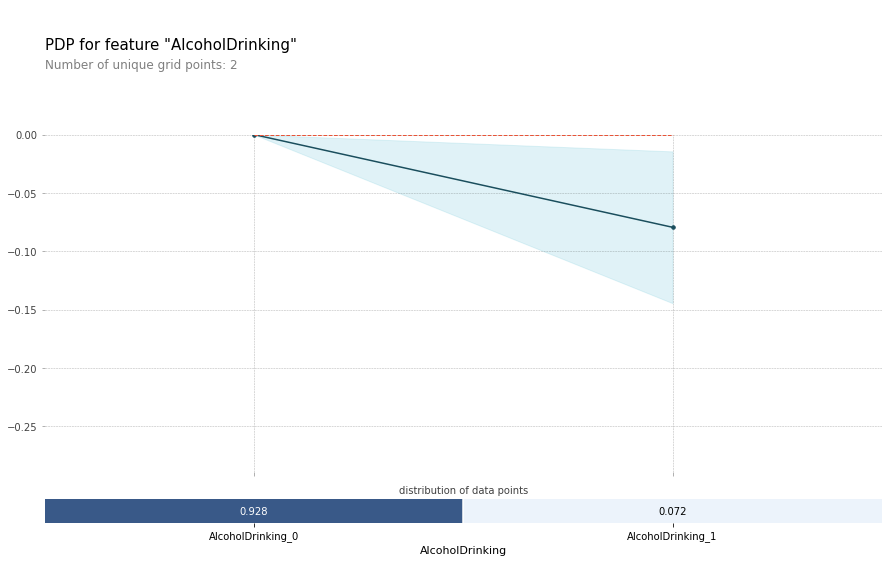

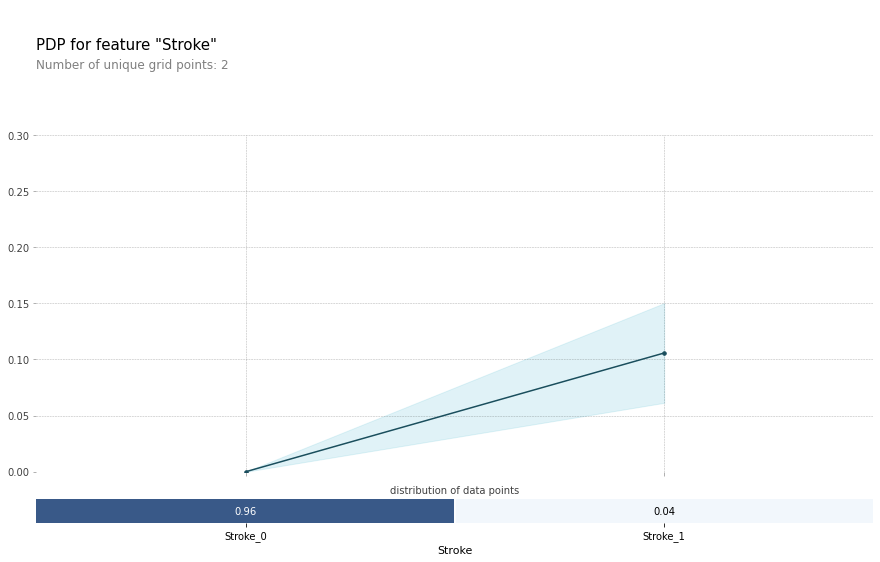

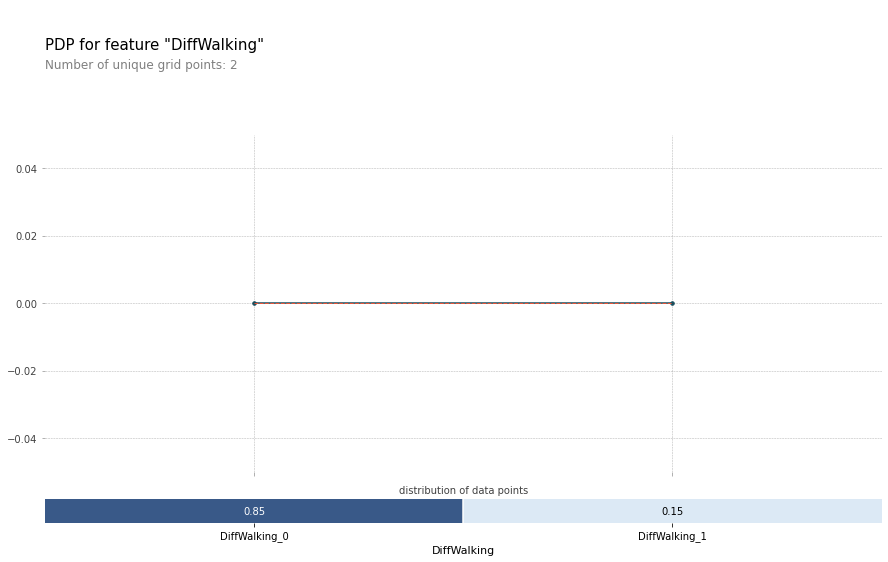

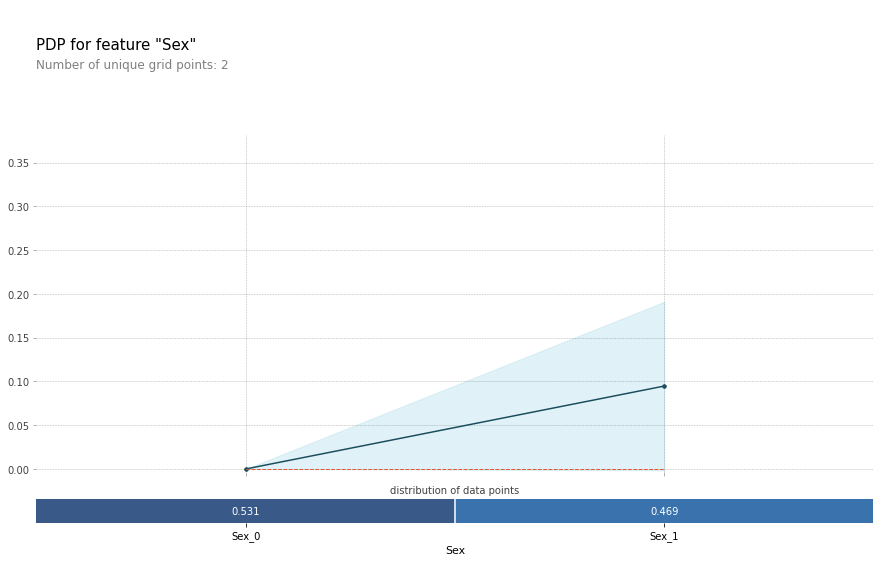

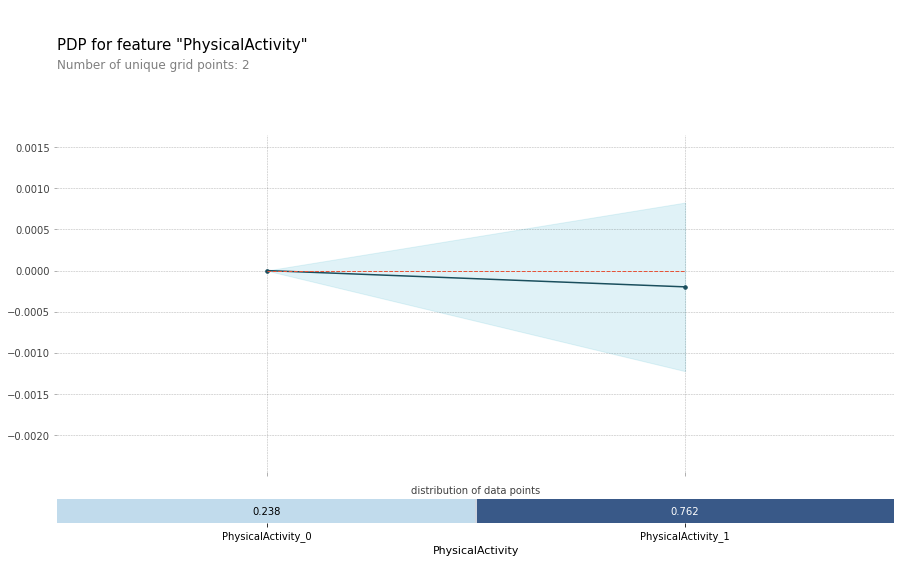

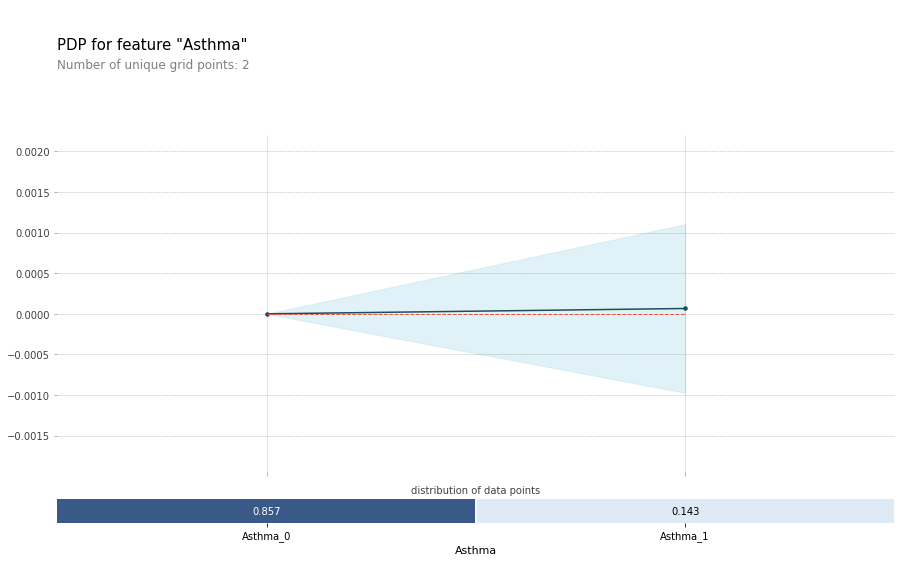

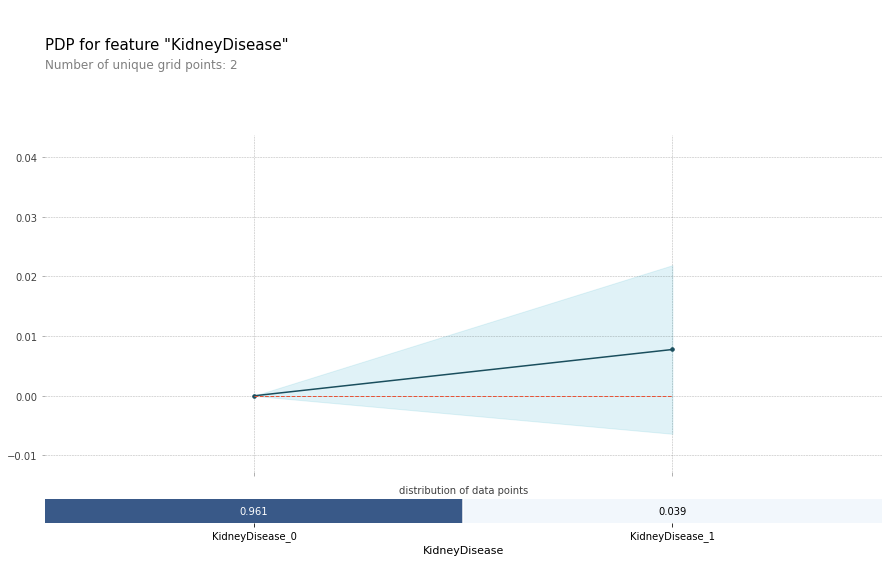

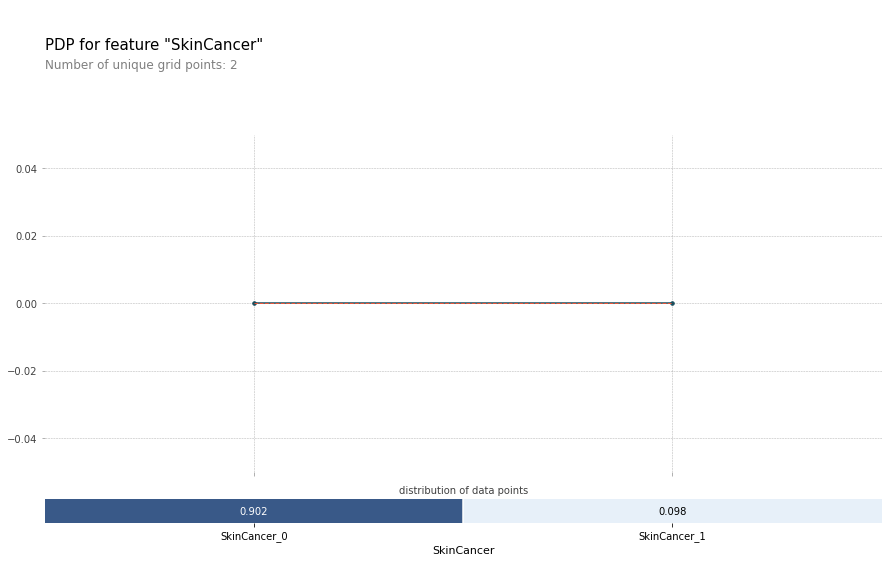

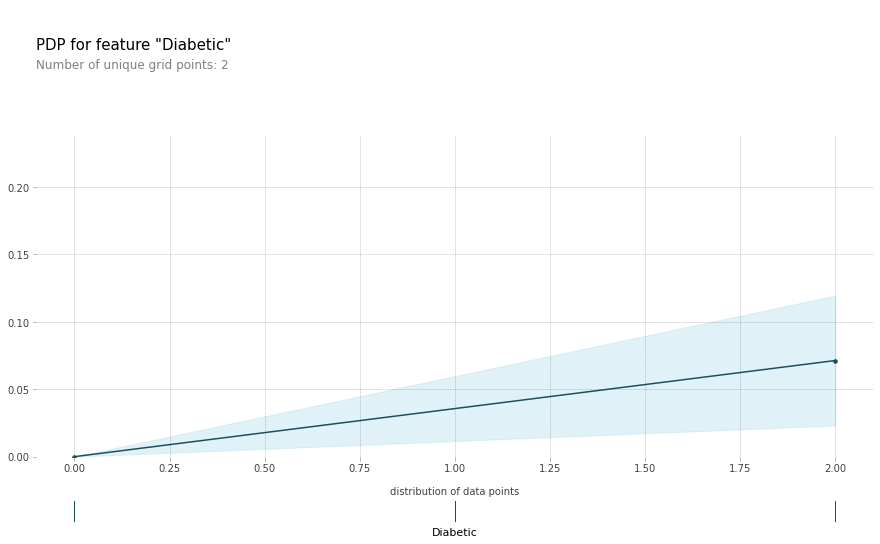

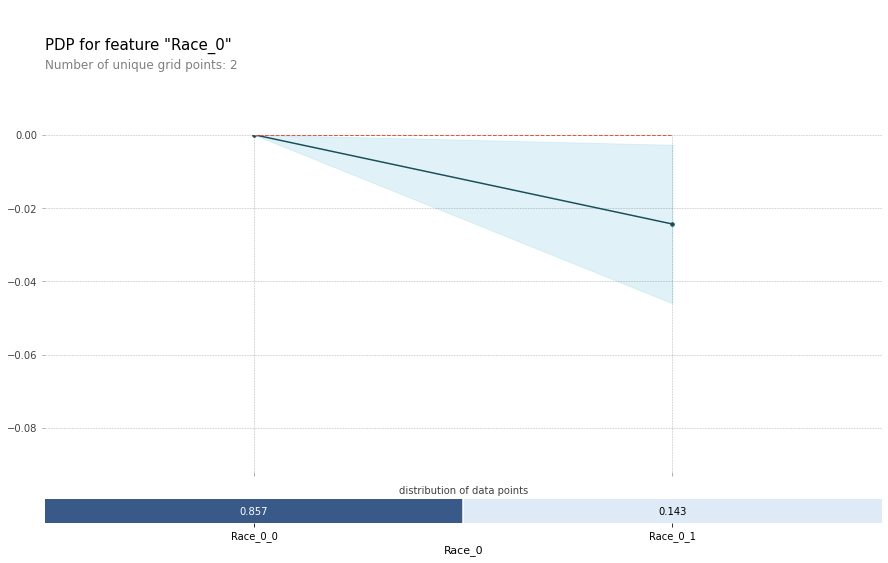

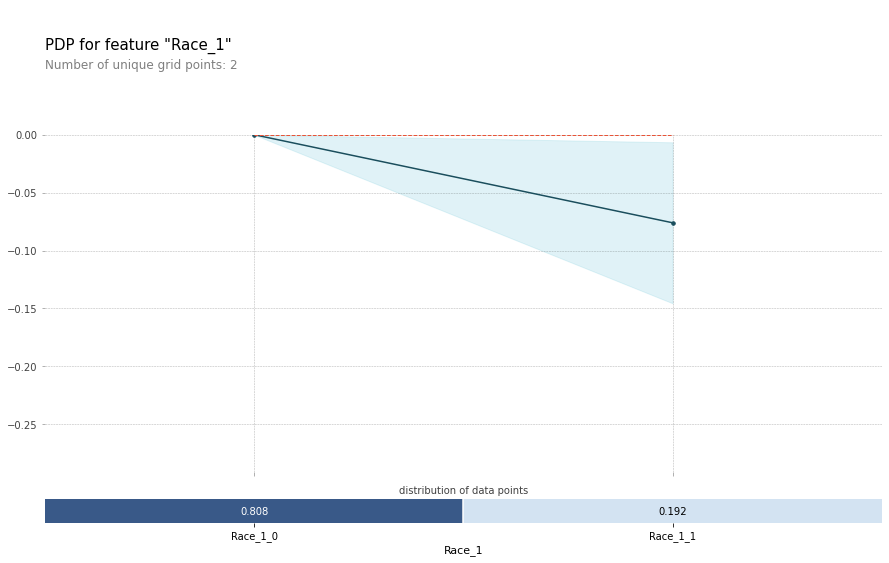

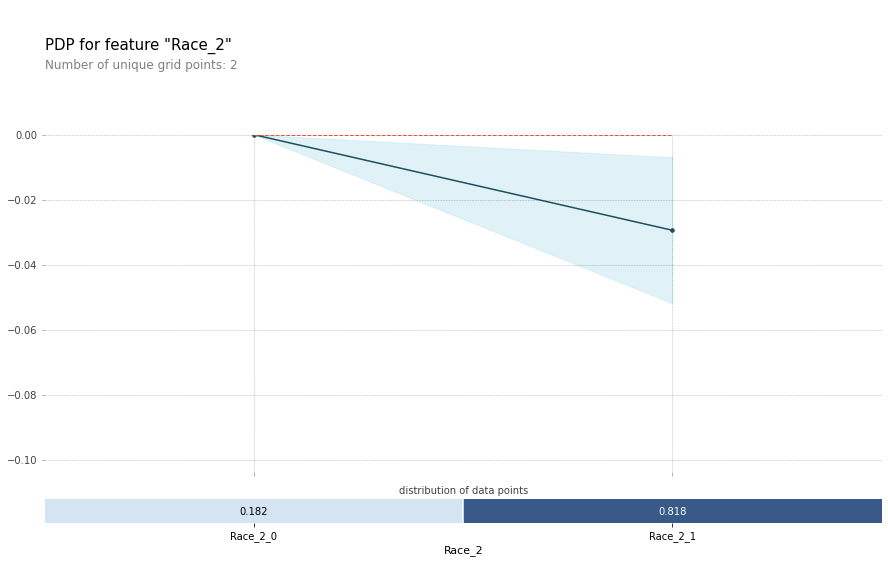

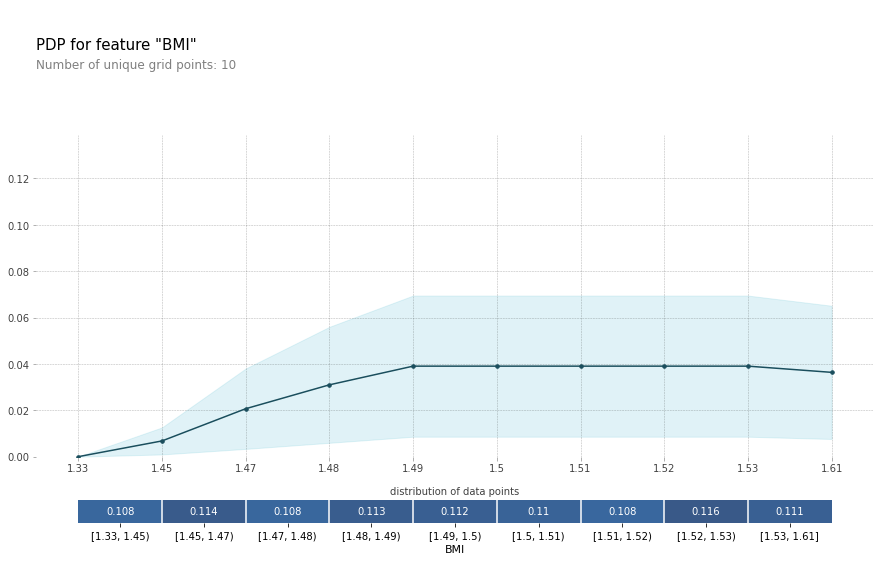

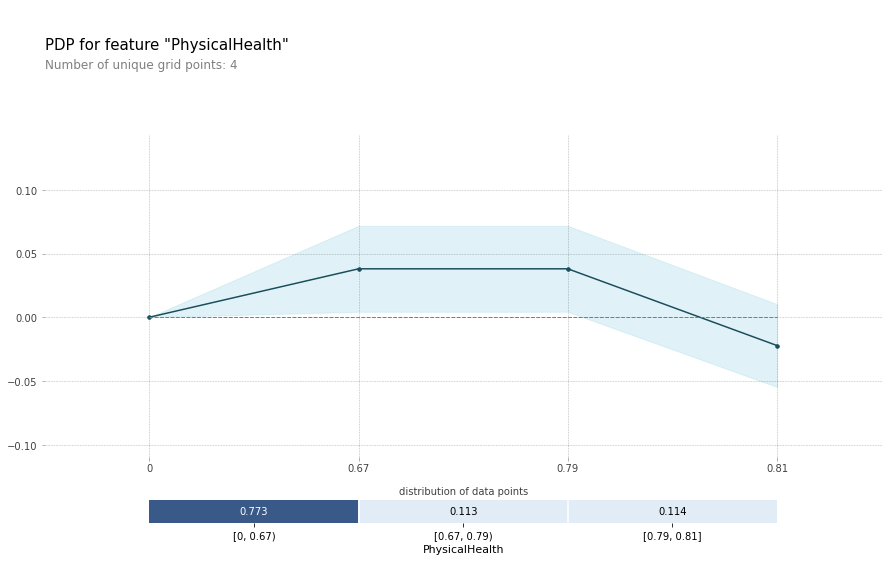

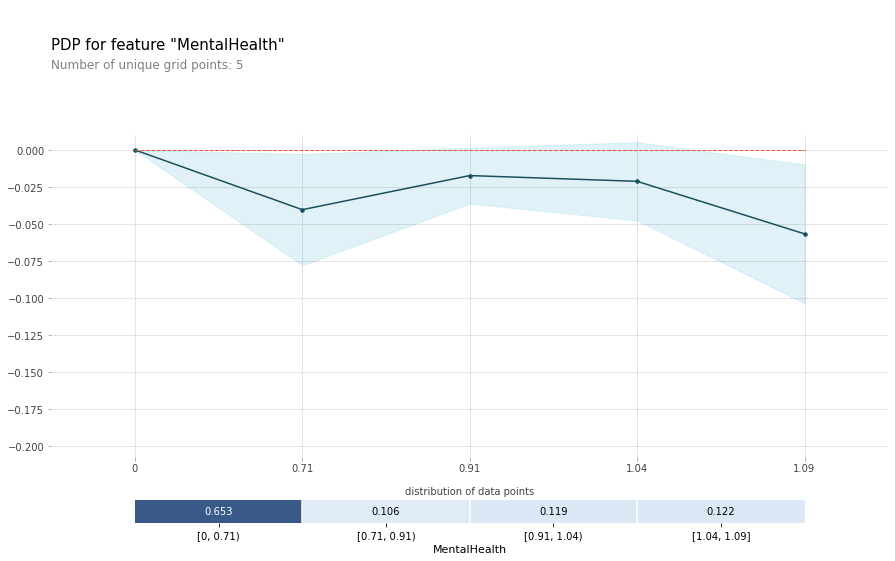

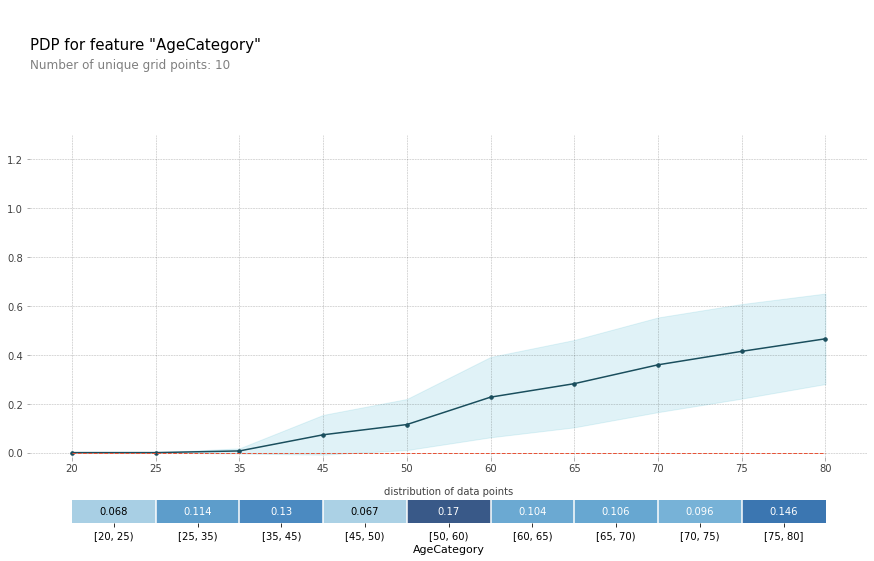

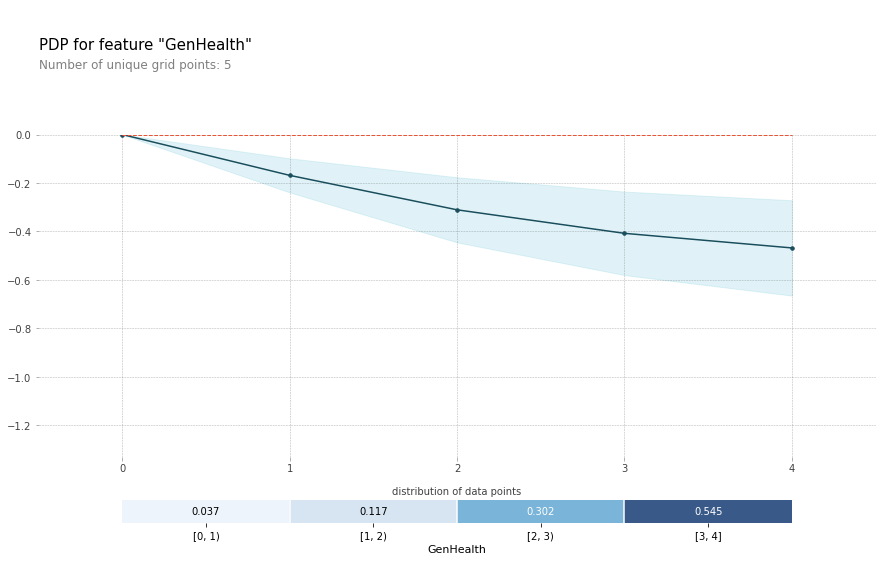

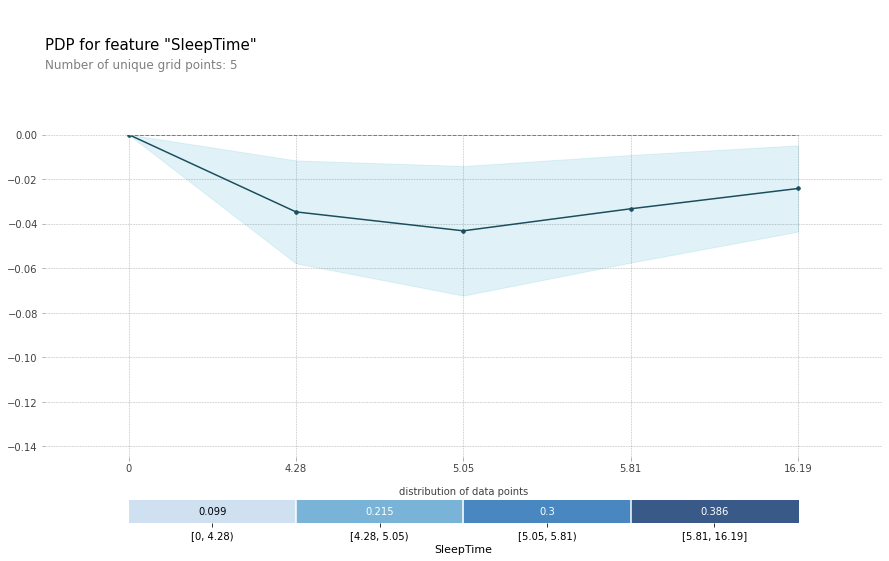

In [47]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [48]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SVMSMOTE, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

 99%|===================| 59642/60331 [01:08<00:00]       

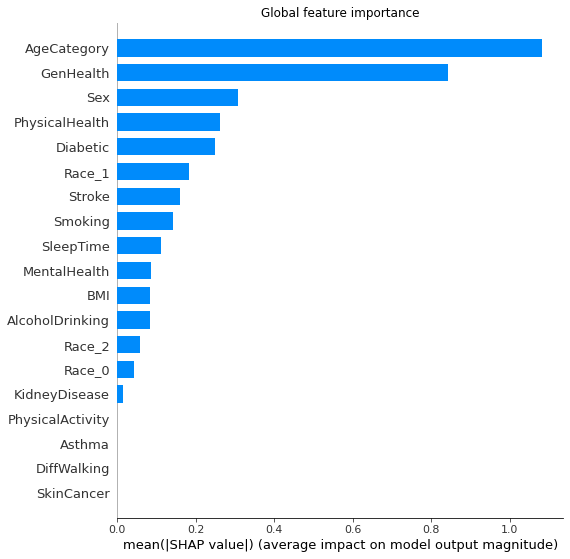

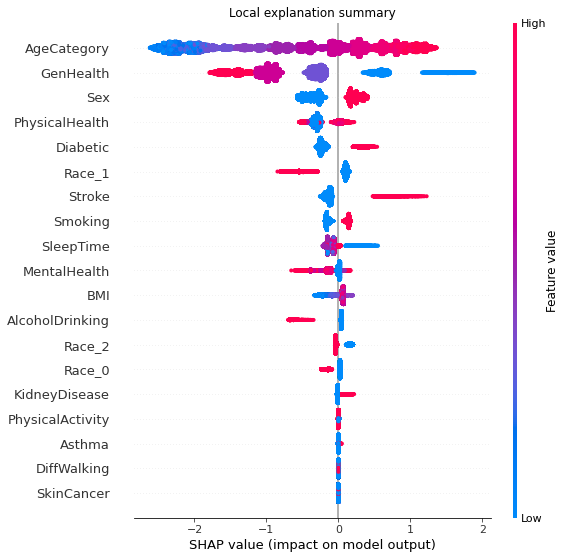

In [49]:
# SHAP
explainer = shap.Explainer(model_SVMSMOTE, x_train_SVMSMOTE, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## ADASYN

In [50]:
model_ADASYN = xgb.XGBClassifier()
model_ADASYN.fit(x_train_ADASYN, y_train_ADASYN)

XGBClassifier()

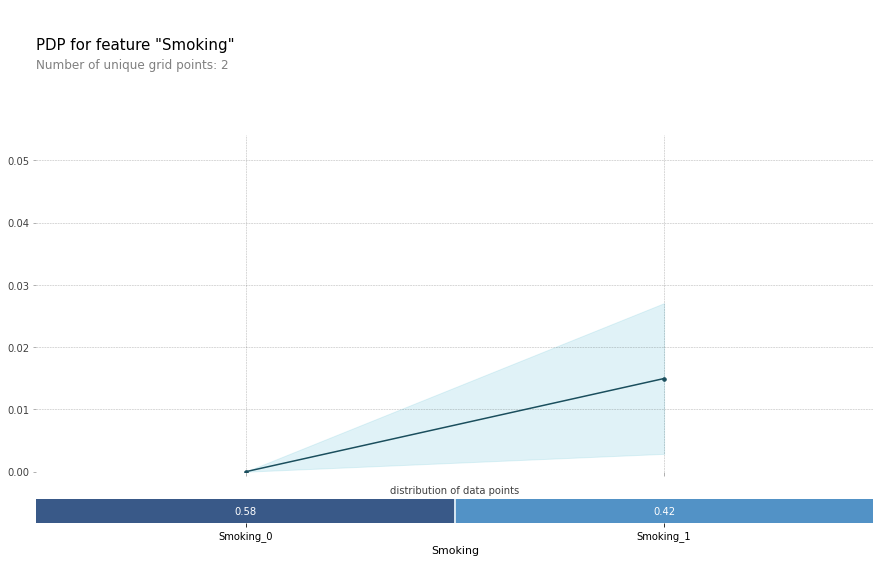

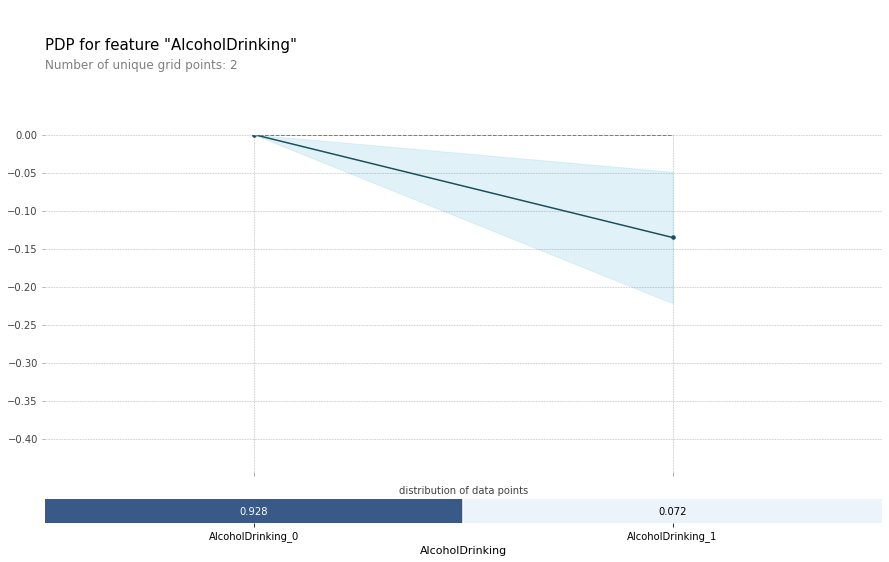

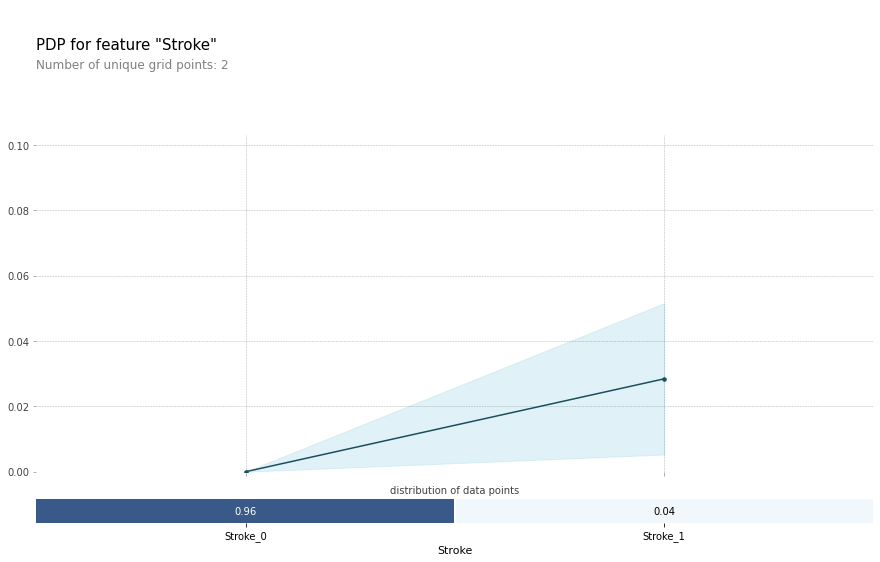

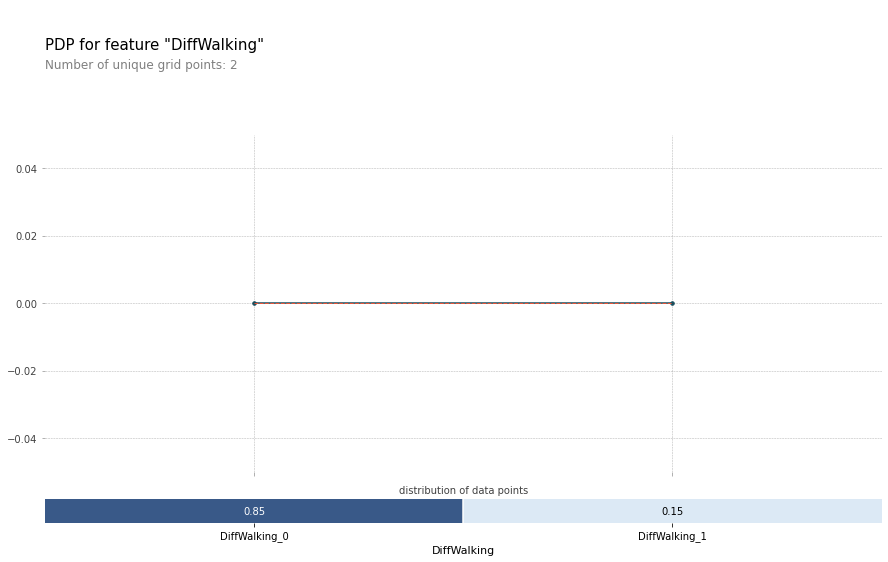

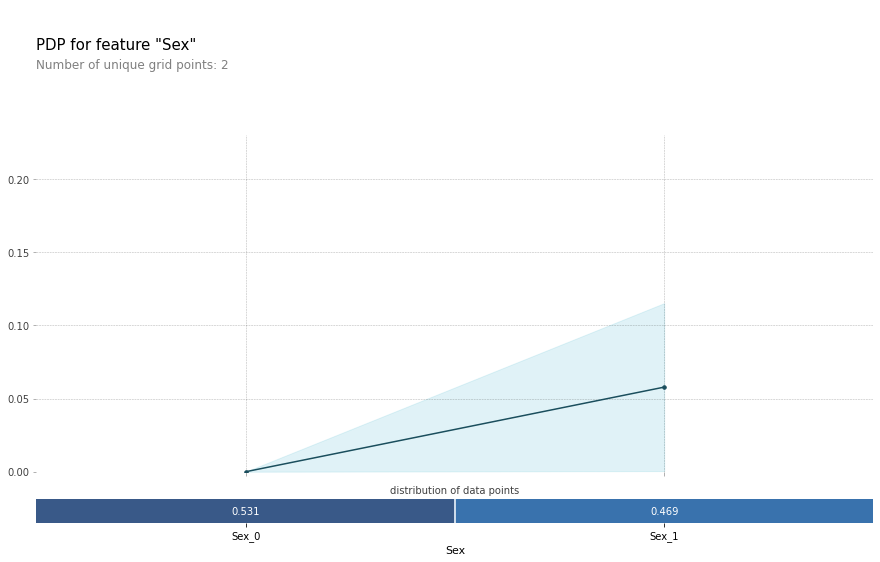

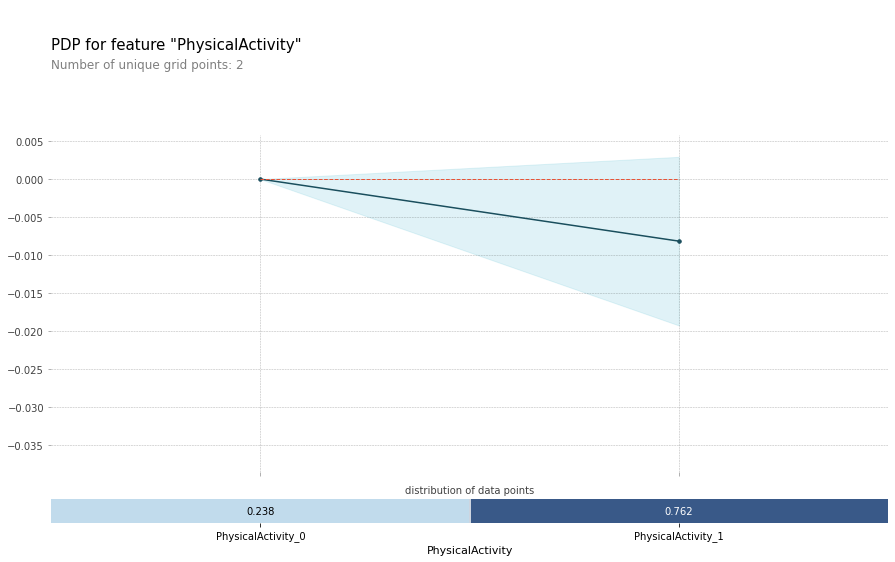

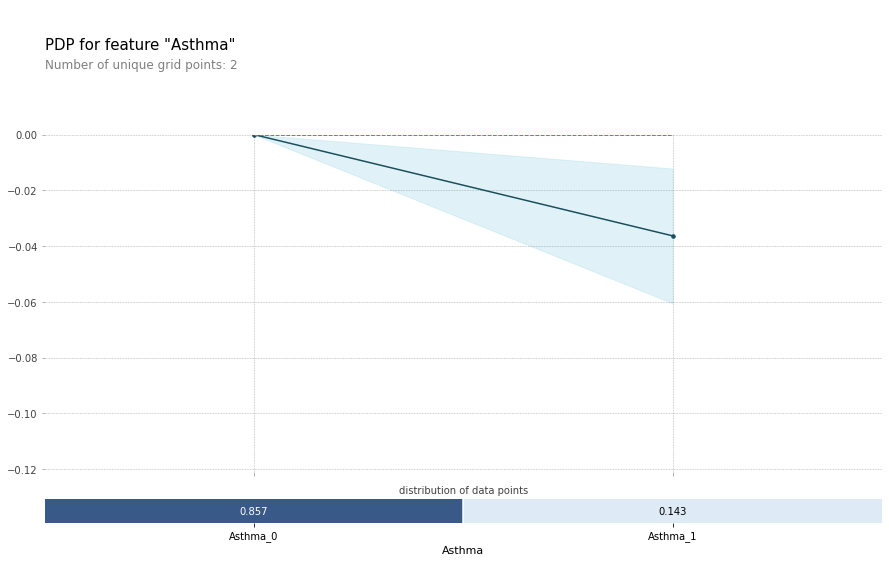

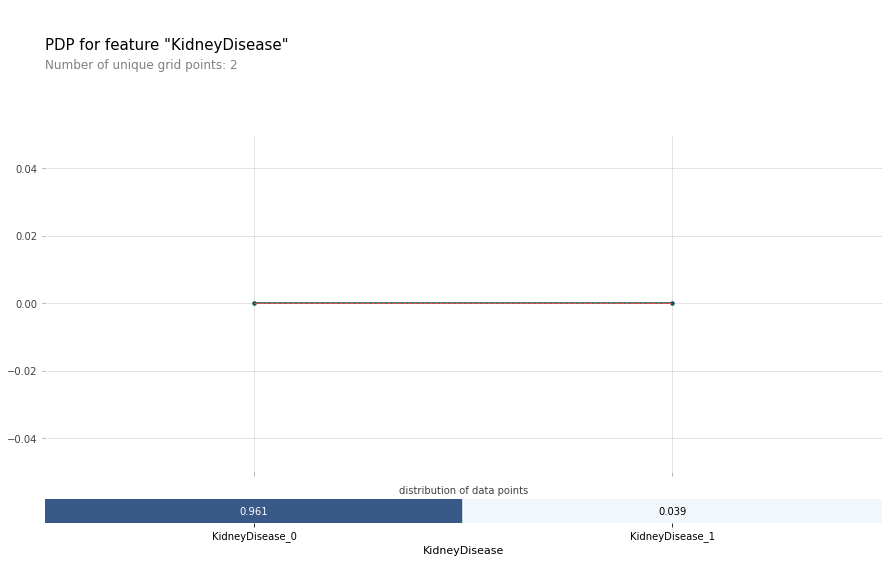

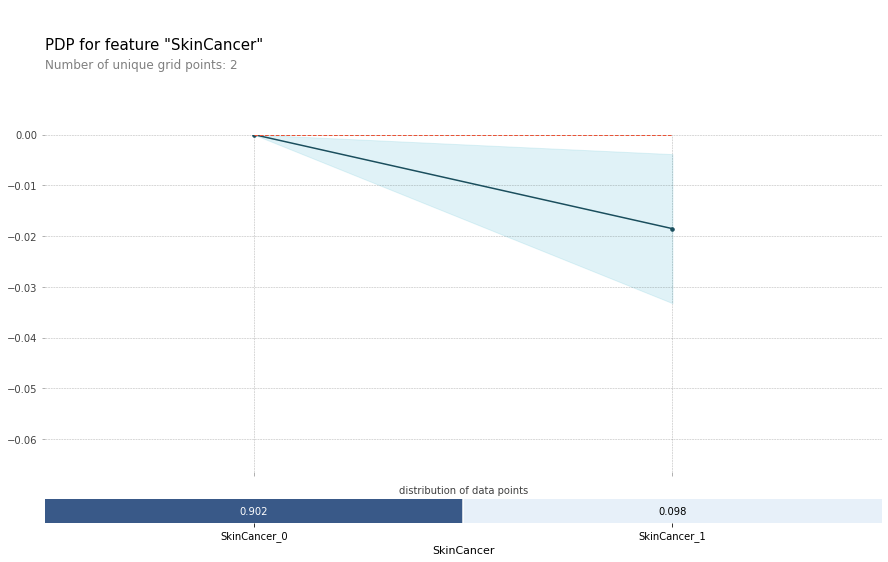

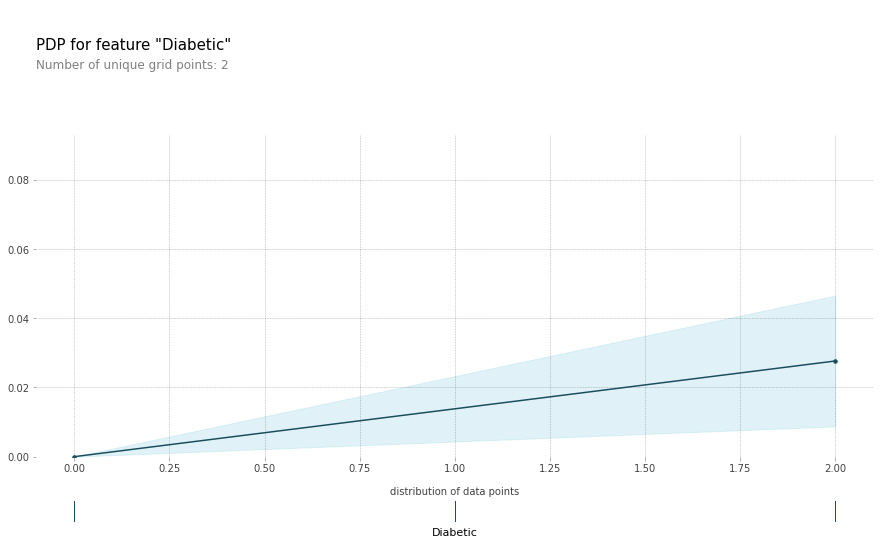

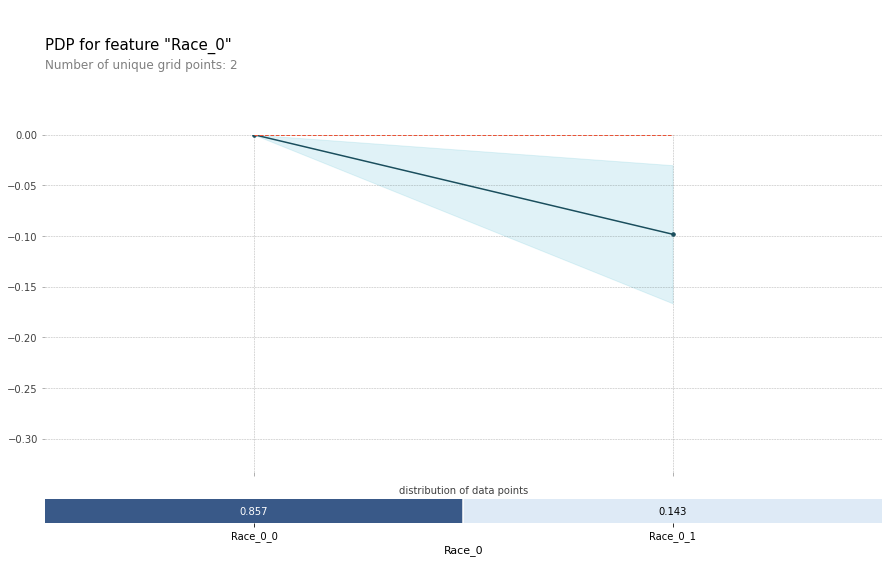

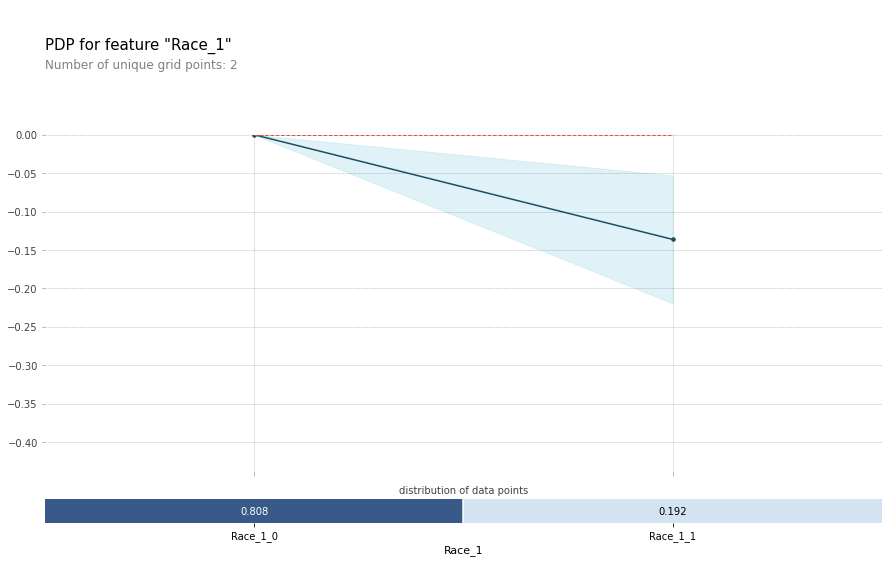

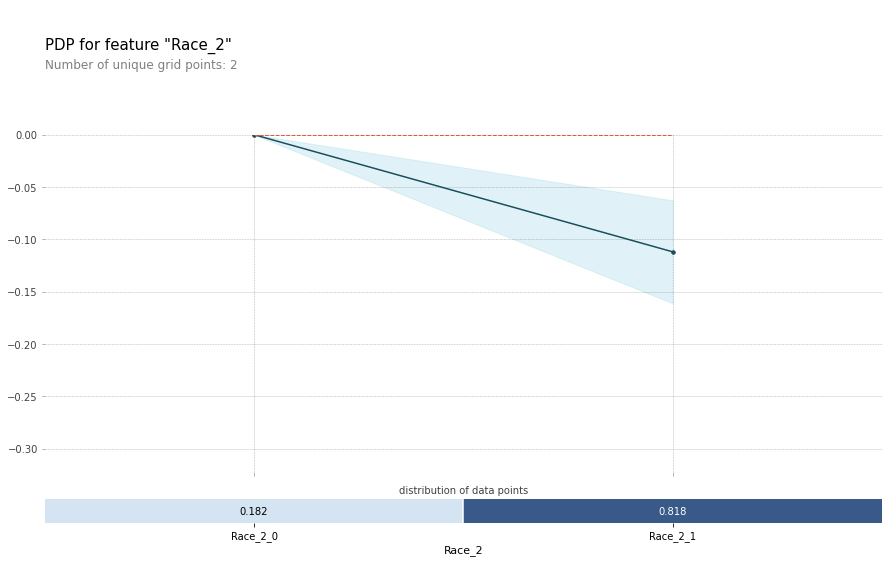

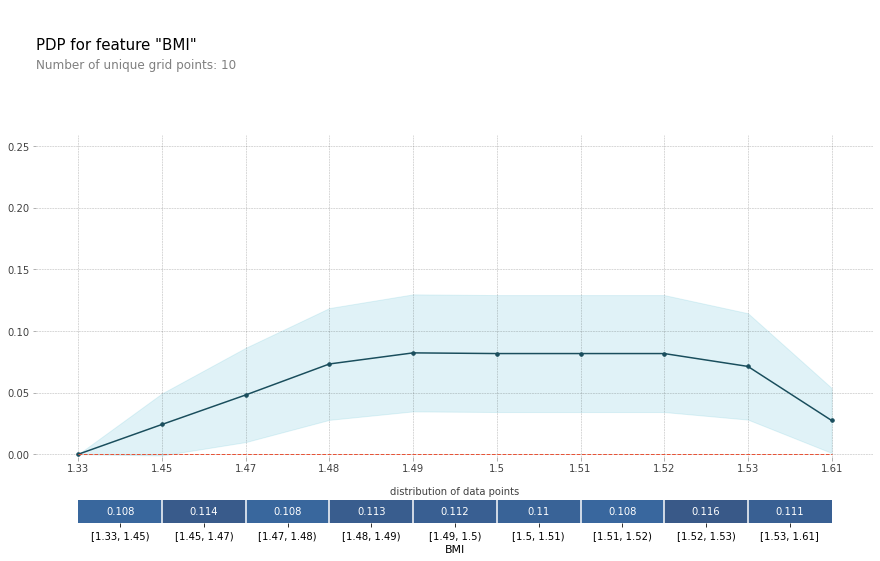

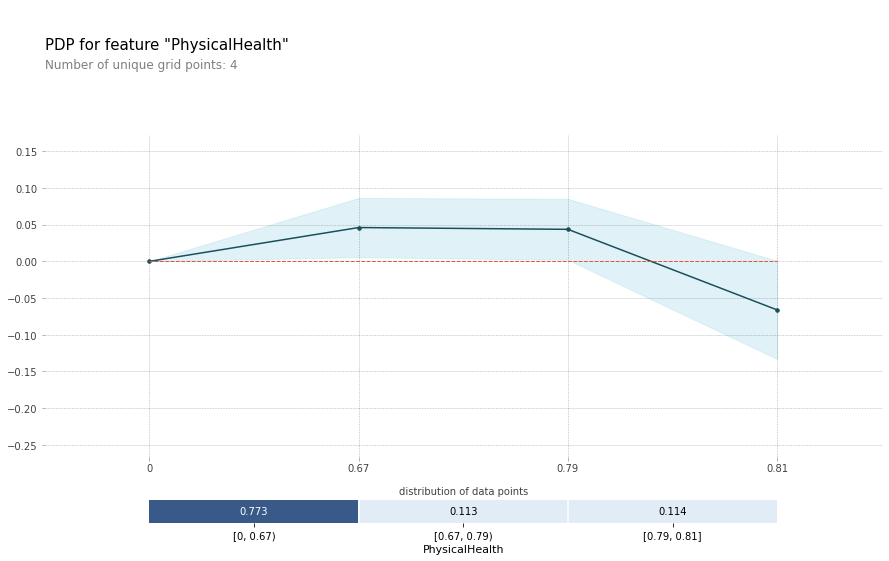

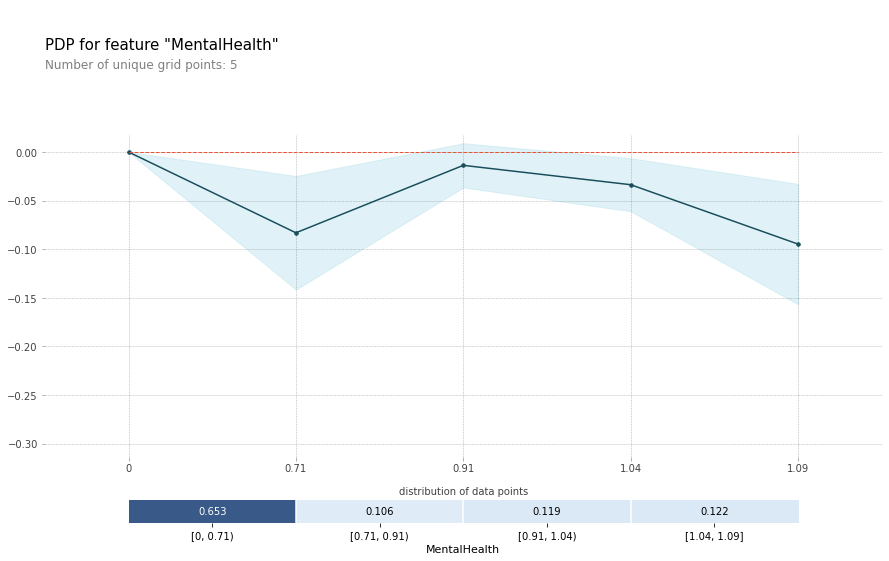

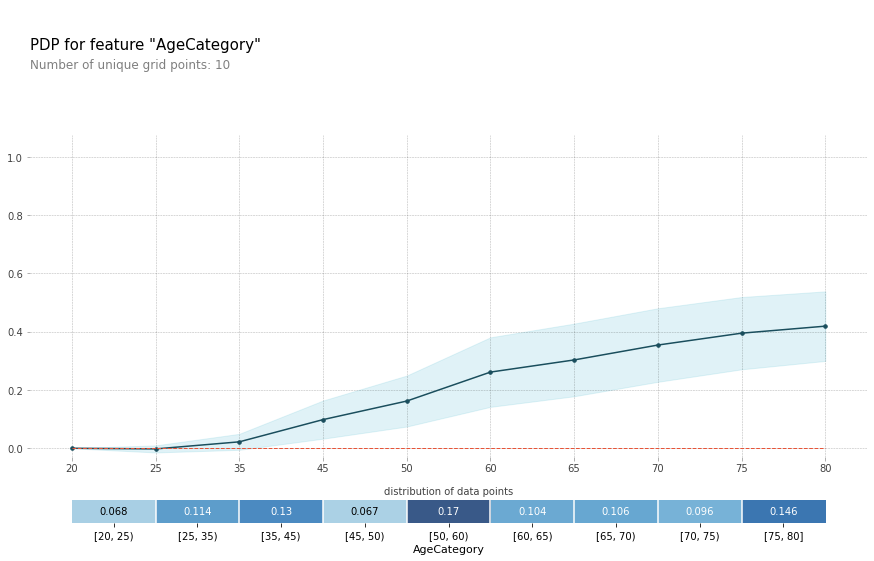

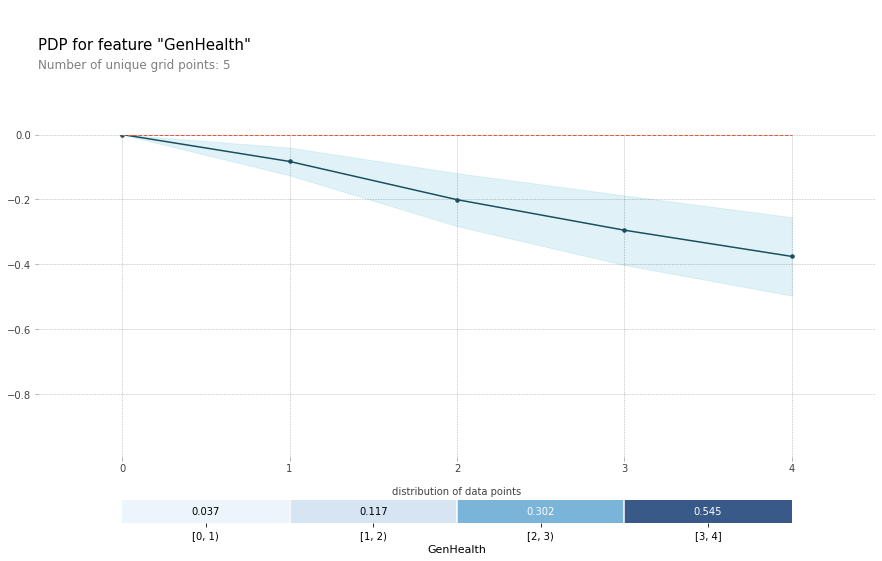

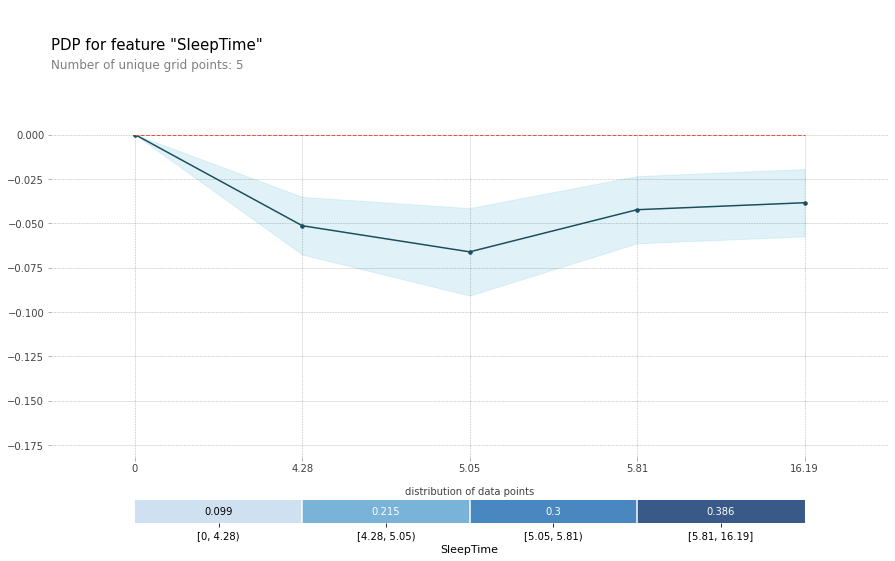

In [51]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [52]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_ADASYN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

100%|===================| 60230/60331 [01:10<00:00]       

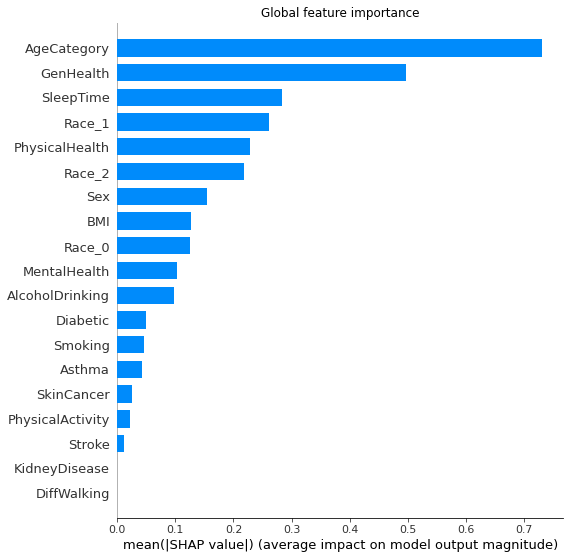

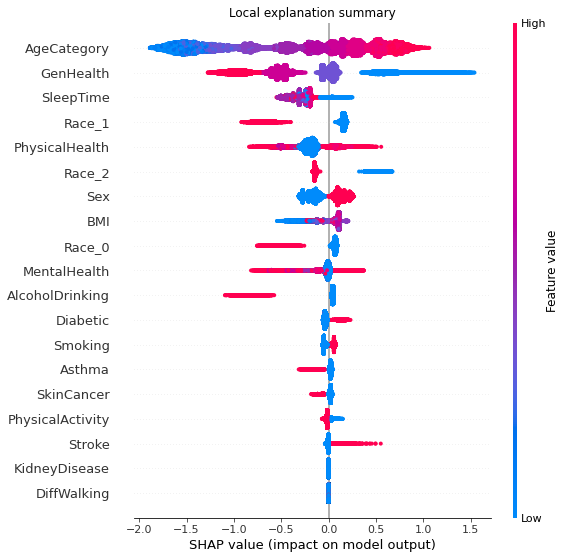

In [53]:
# SHAP
explainer = shap.Explainer(model_ADASYN, x_train_ADASYN, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)

## SMOTEENN

In [54]:
model_SMOTEENN = xgb.XGBClassifier()
model_SMOTEENN.fit(x_train_SMOTEENN, y_train_SMOTEENN)

XGBClassifier()

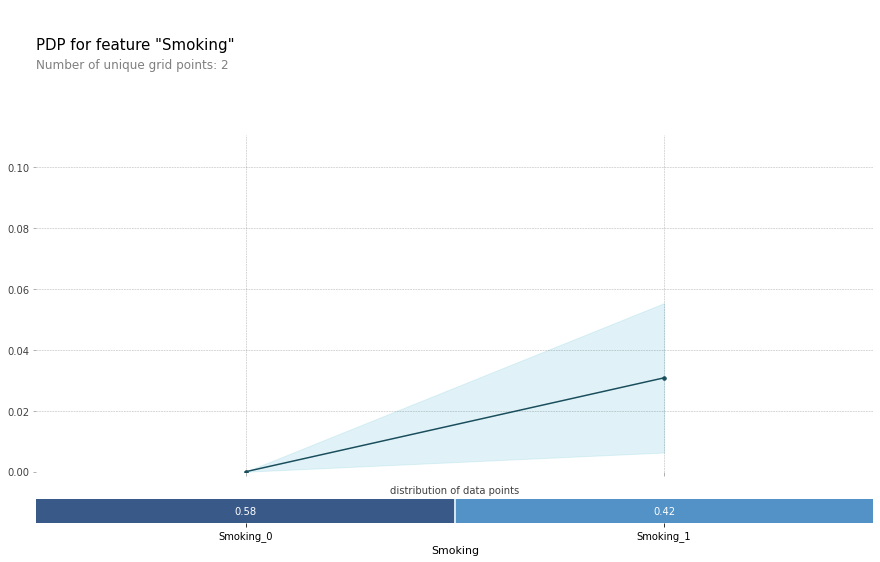

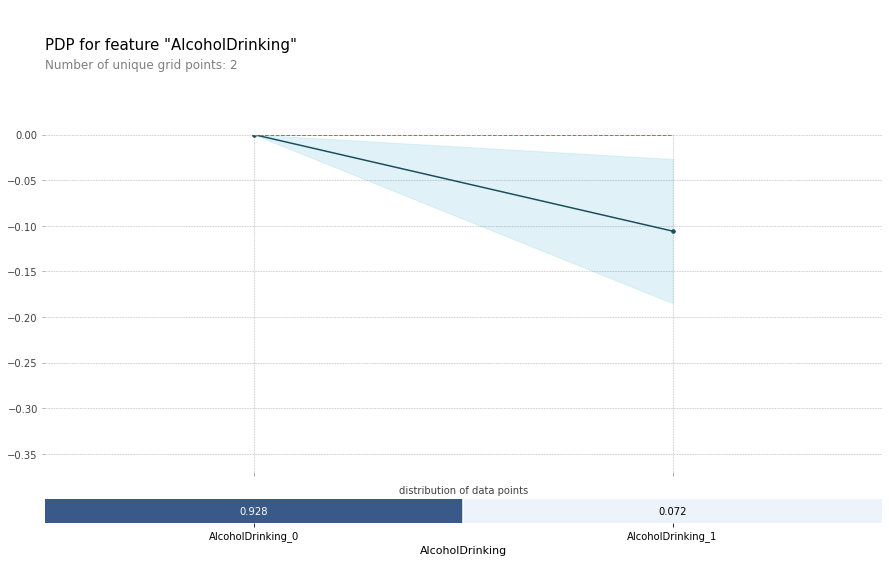

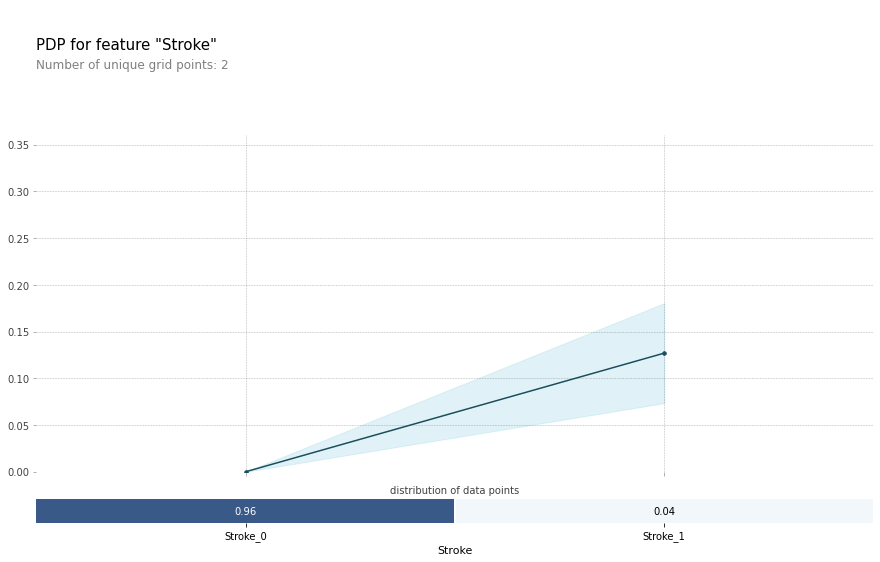

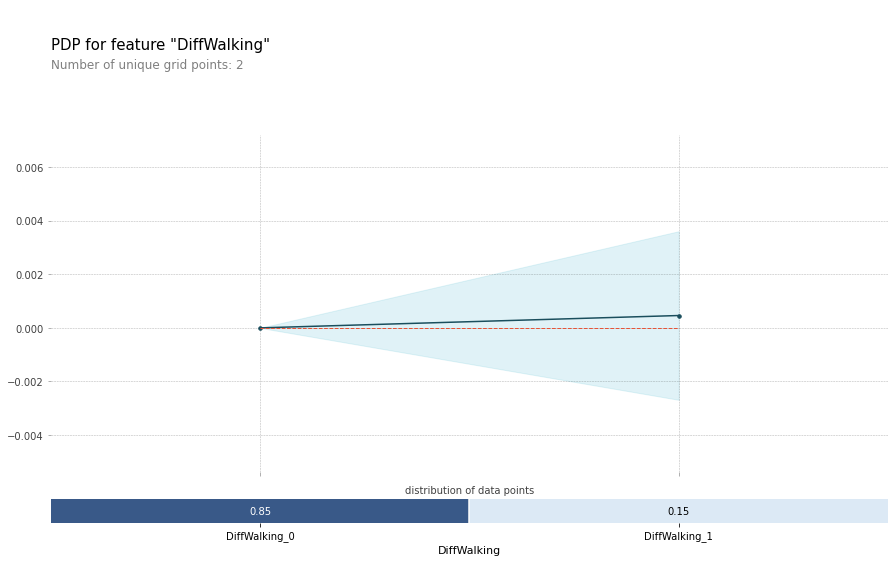

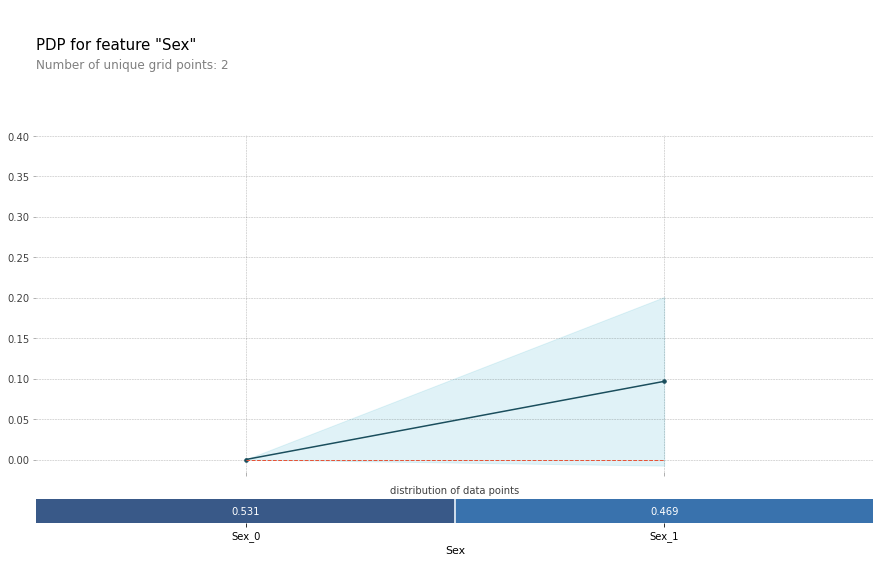

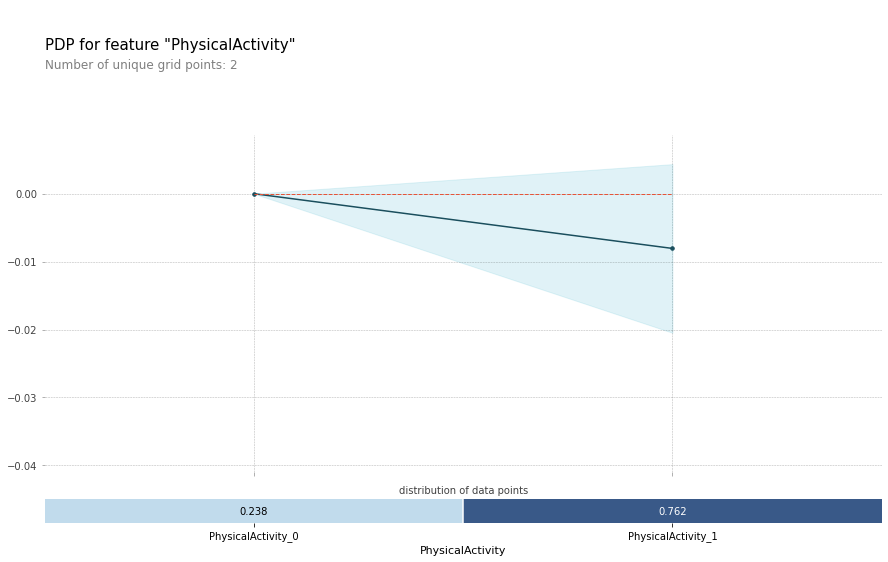

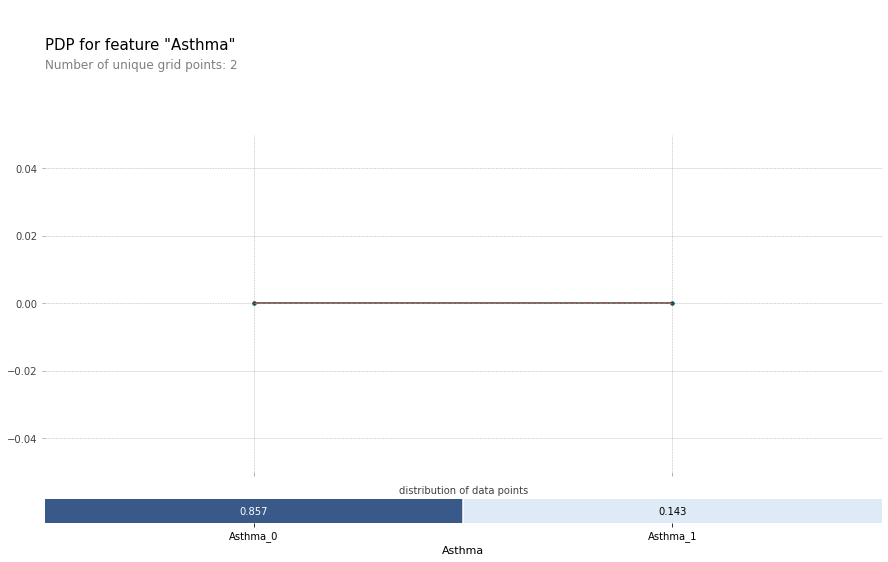

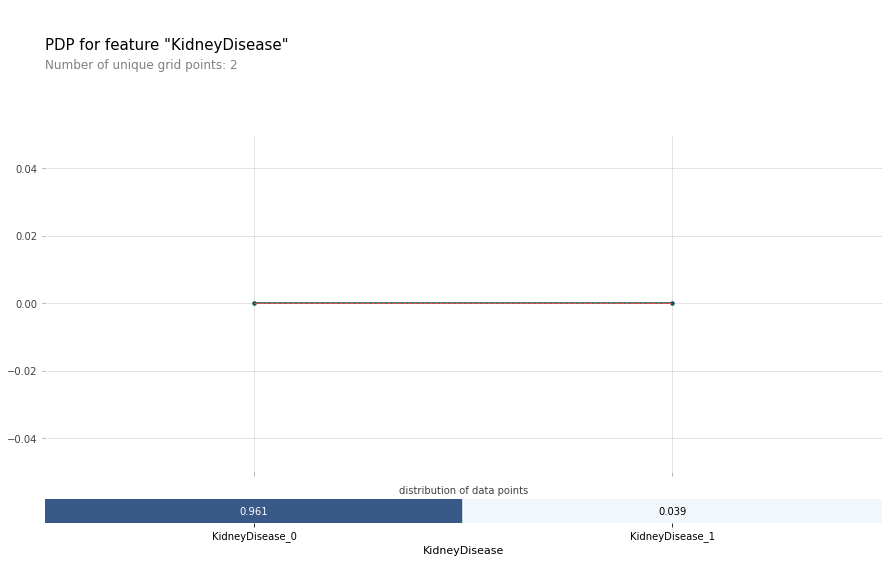

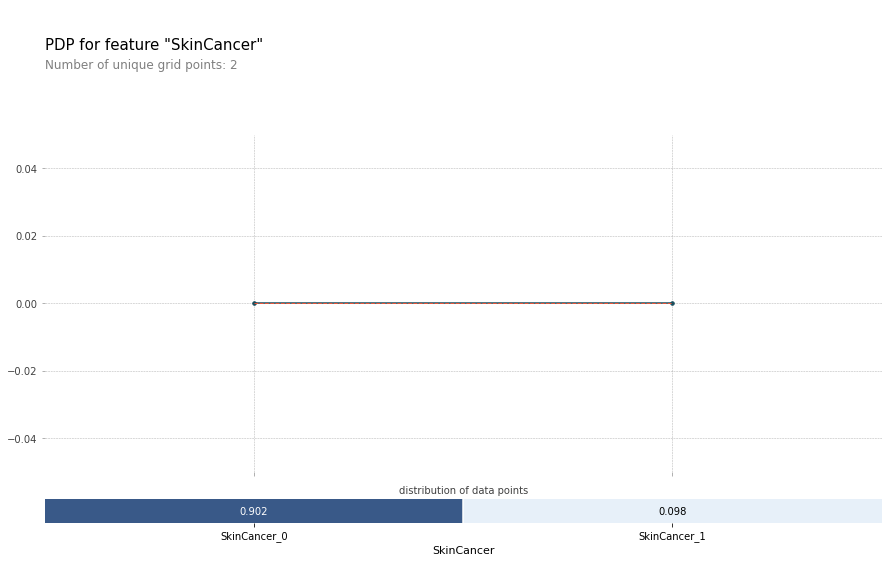

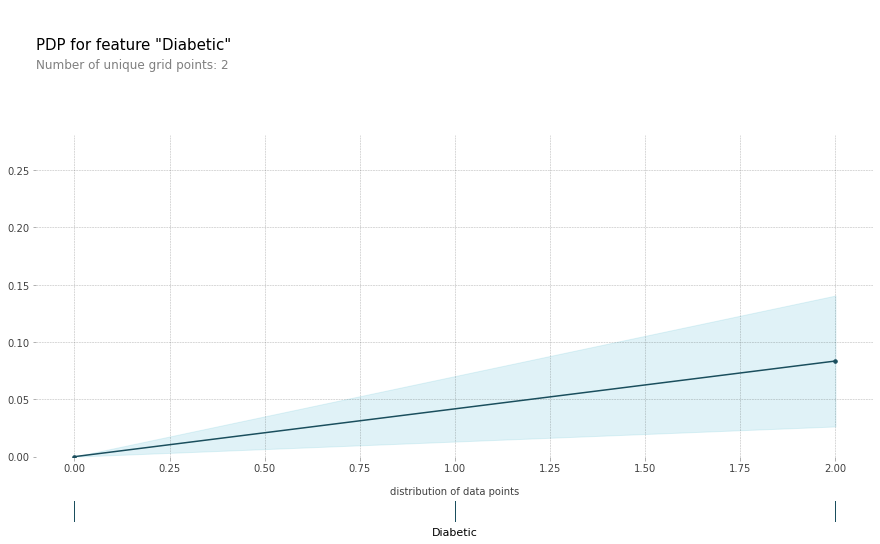

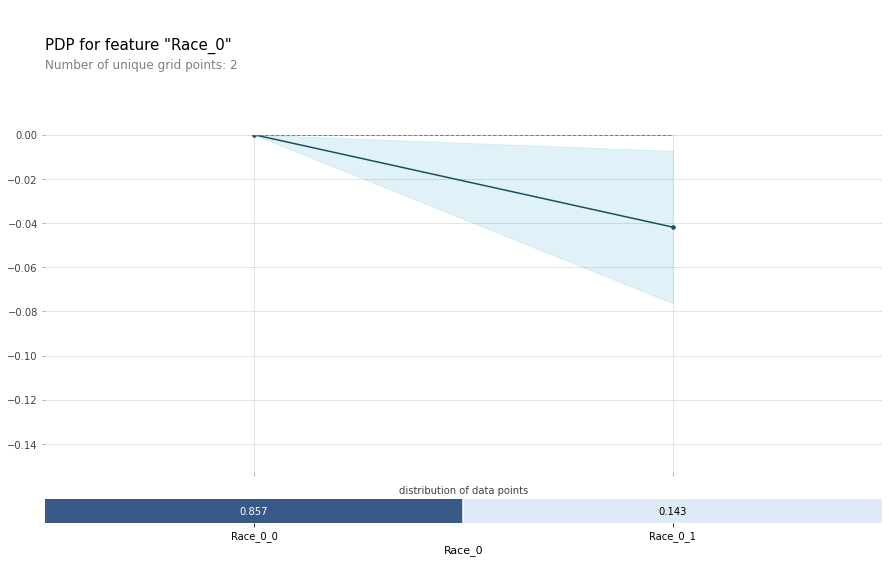

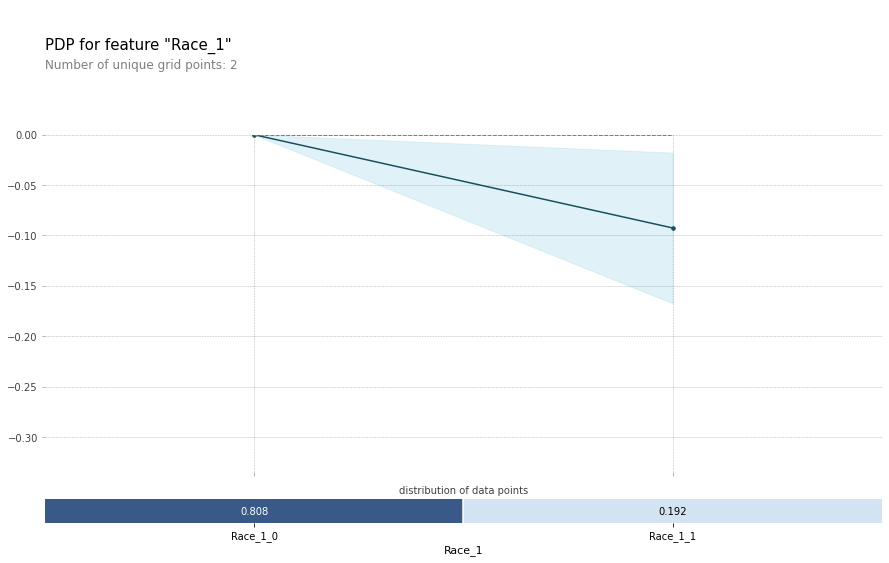

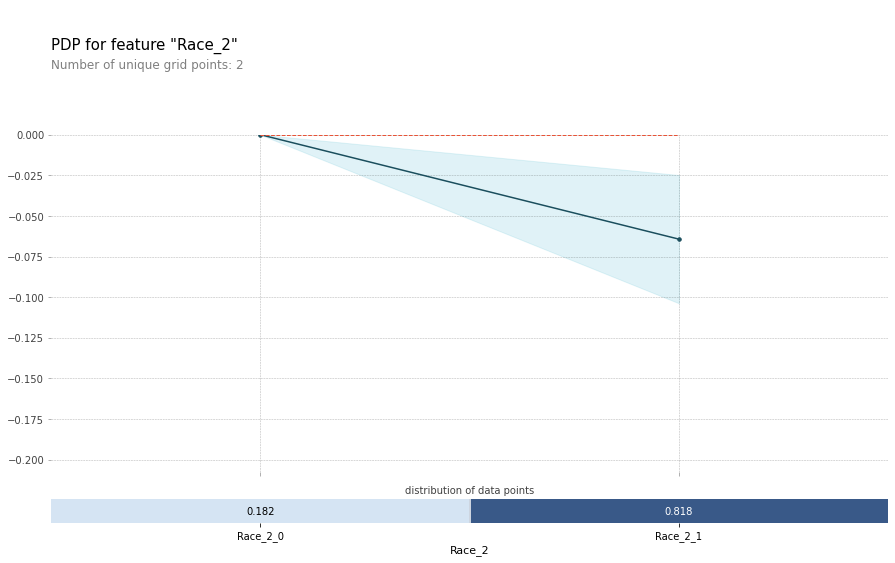

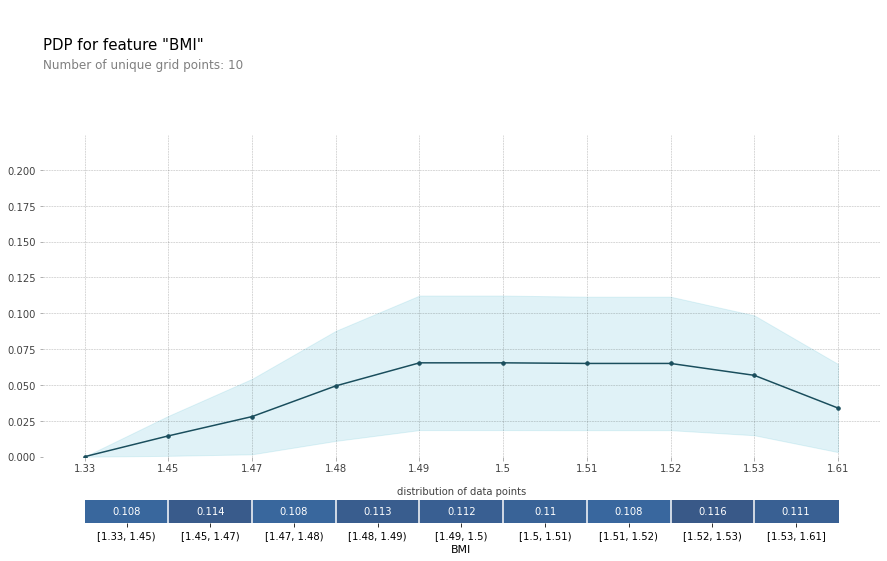

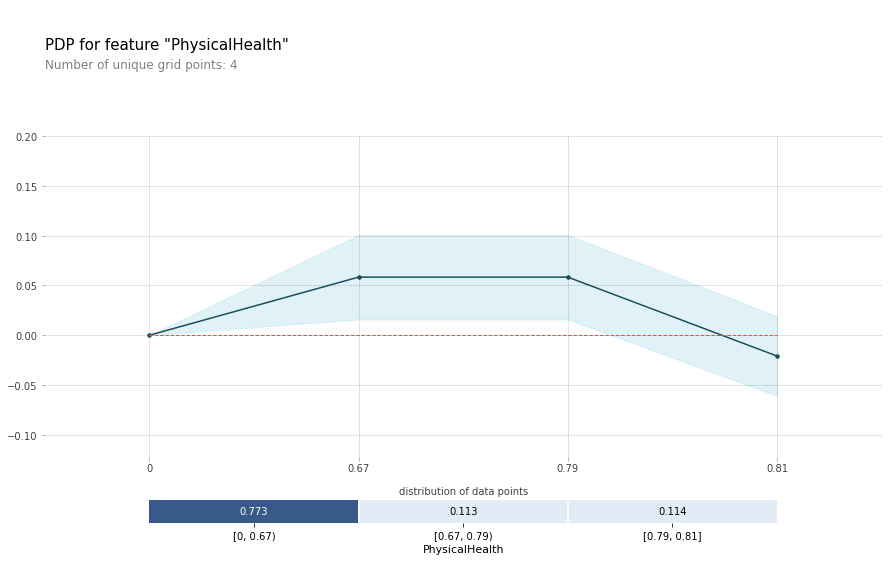

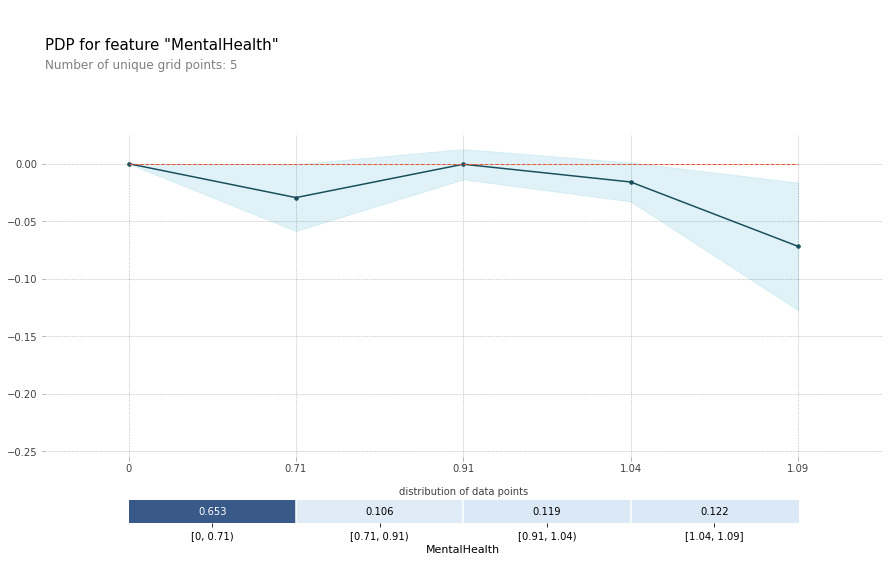

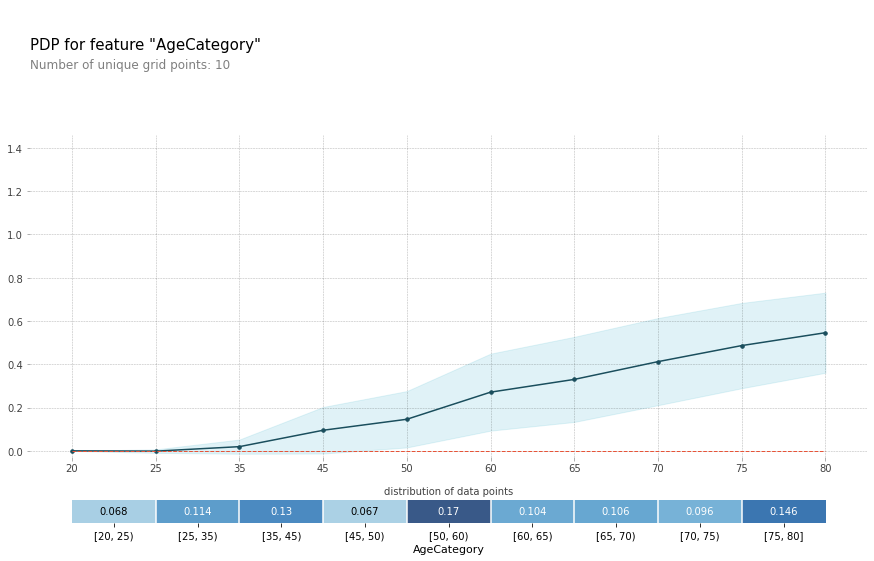

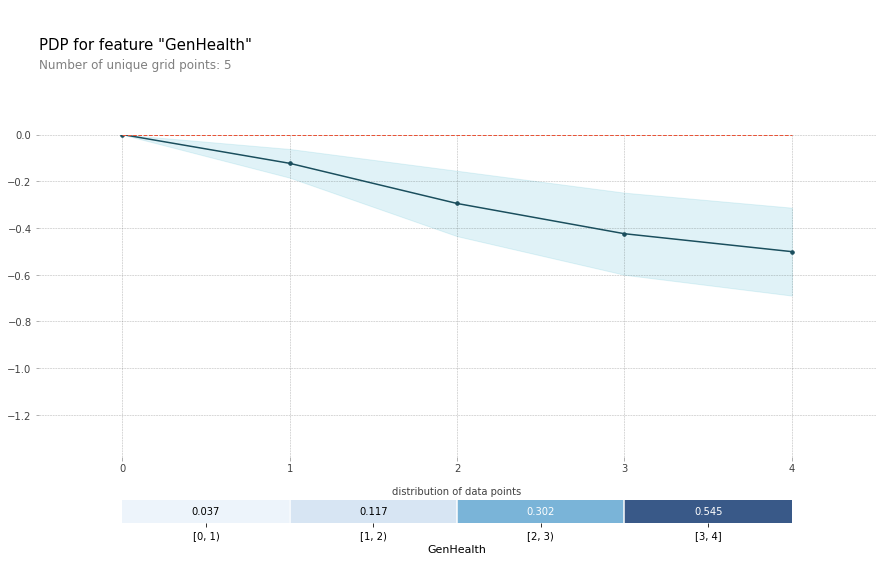

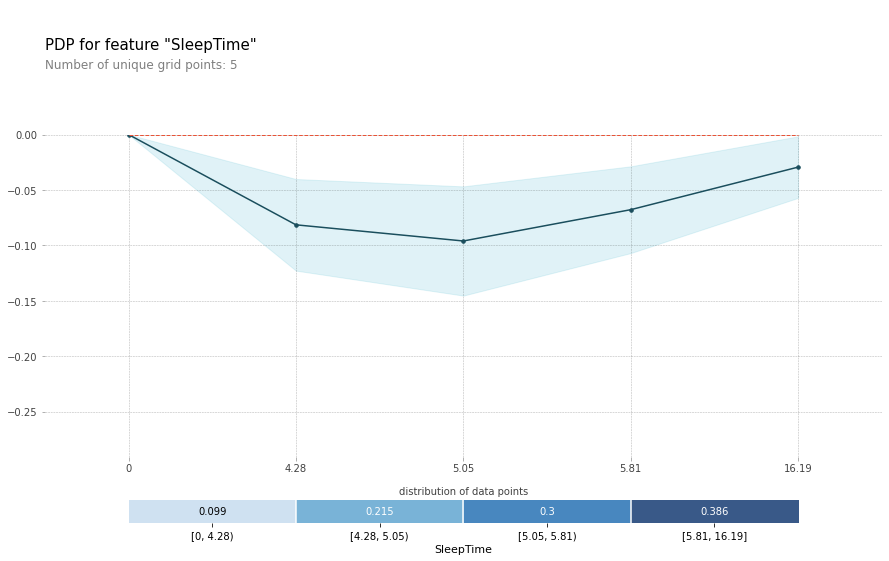

In [55]:
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [56]:
# ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model_SMOTEENN, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

100%|===================| 60049/60331 [01:10<00:00]       

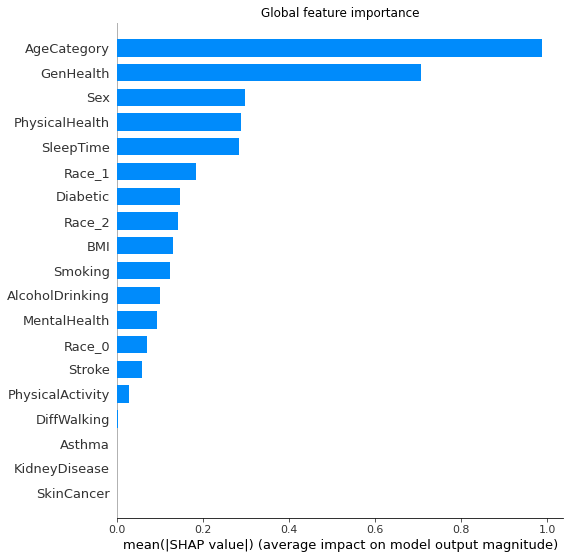

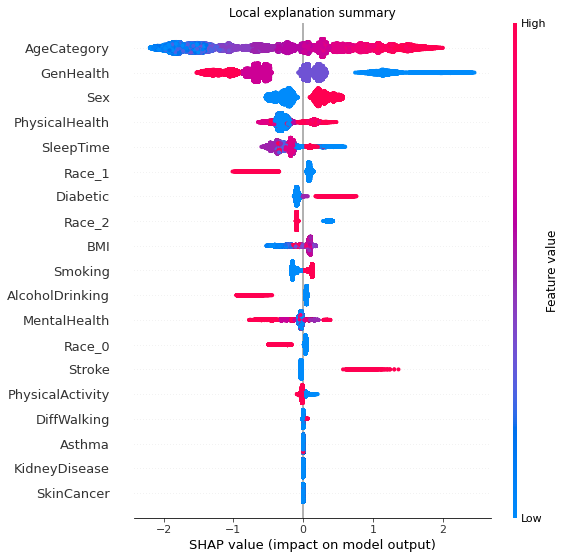

In [57]:
# SHAP
explainer = shap.Explainer(model_SMOTEENN, x_train_SMOTEENN, feature_names=features)
shap_values = explainer(x_test, check_additivity=False)

plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar")


plt.title('Local explanation summary')
shap.summary_plot(shap_values)